# Teste do Algoritmo DeepSVDD
Teste dos algoritmos de detecção de anomalias para comparação e seleção dos integrantes do aplicativo

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from pyod.utils.data import evaluate_print
import matplotlib.pyplot as plt

tabelafinal = pd.DataFrame(columns=['algoritmo','contaminacao','acuracia','precisao','recall','f1','fn','fp','tp'])
print(tabelafinal)
 
def avalia(clf_name,Y,y_train_scores,y_train_pred):
    # Avalia e imprime os resultados
    print("Avaliação do modelo "+clf_name+":")
    evaluate_print(clf_name, Y, y_train_scores)
    tn, fp, fn, tp = confusion_matrix(Y,y_train_pred).ravel()
    print('Acurácia='+str(accuracy_score(Y,y_train_pred)*100))   
    print('Precisão='+str(precision_score(Y,y_train_pred)*100))
    print('Recall='+str(recall_score(Y,y_train_pred)*100))
    print('Falso Positivo='+str(fp))
    print('Falso Negativo='+str(fn))
    print('F1-score='+str(f1_score(Y,y_train_pred)*100))
    print('ROC='+str(roc_auc_score(Y,y_train_scores)))

def gera_matriz_de_confusao(Y,y_train_pred,clf_name):
    cm = confusion_matrix(Y,y_train_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal','Anomalia'])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set(title='Matriz de Confusão do '+clf_name,xlabel='Valores preditos', ylabel='Valores reais')
    plt.show()
    
def grava_avaliacao(clf_name,Y,y_train_scores,y_train_pred,contamination):
    # Grava os resultados da avaliação na tabela final
    tn, fp, fn, tp = confusion_matrix(Y,y_train_pred).ravel()
    ac=("{:.2f}".format(round(accuracy_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Acurácia='+ac)   
    pc=("{:.2f}".format(round(precision_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Precisão='+pc)
    rc=("{:.2f}".format(round(recall_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Recall='+rc)
    f1=("{:.2f}".format(round(f1_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('F1='+f1)
    print('Falso Negativo='+str(fn))
    print('Falso Positivo='+str(fp))
    print('Verdadeiro Positivo='+str(tp))
    cont=str(round(contamination,2)).replace(".",",")
    tabelafinal.loc[len(tabelafinal.index)] = [clf_name,cont,ac,pc,rc,f1,fn,fp,tp] 
      

Empty DataFrame
Columns: [algoritmo, contaminacao, acuracia, precisao, recall, f1, fn, fp, tp]
Index: []


# Recuperação dos dados a serem utilizados na avaliação
Leitura do arquivo gerado para o material de catmat_id= 445485 -> Descrição:'ÁGUA MINERAL NATURAL, TIPO SEM GÁS MATERIAL EMBALAGEM PLÁSTICO TIPO EMBALAGEM RETORNÁVEL'.

In [2]:
import os
import pandas as pd
def load_itens(path):
    csv_path = os.path.join(path,"445485.csv")
    return pd.read_csv(csv_path)

df=load_itens(".")
## Retira os campos que não serão utilizados no treinamento
df = df.drop(['licitacao_contrato'],axis=1)
df = df.drop(['id'],axis=1)
df = df.drop(['data'],axis=1)
df = df.drop(['catmat_id'],axis=1)
df = df.drop(['unidade'],axis=1)
df = df.drop(['valor_total'],axis=1)
df = df.drop(['municipio_uasg'],axis=1)
df = df.drop(['municipio_fornecedor'],axis=1)
print(df)

     quantidade  valor_unitario  distancia_uasg_fornecedor  anomalia
0           420           12.00                    935.371         0
1         28000            5.88                      0.000         0
2          2100            5.09                      0.000         0
3           360            7.70                    172.788         0
4           120            7.70                    172.788         0
..          ...             ...                        ...       ...
725        5000           10.45                    398.772         0
726        4000           13.45                    398.772         0
727        1440           11.37                      0.000         0
728        1440           10.58                      0.000         0
729          10           20.00                      0.000         0

[730 rows x 4 columns]


# Separação do Label dos dados

In [3]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
print(X)
print(Y)

     quantidade  valor_unitario  distancia_uasg_fornecedor
0           420           12.00                    935.371
1         28000            5.88                      0.000
2          2100            5.09                      0.000
3           360            7.70                    172.788
4           120            7.70                    172.788
..          ...             ...                        ...
725        5000           10.45                    398.772
726        4000           13.45                    398.772
727        1440           11.37                      0.000
728        1440           10.58                      0.000
729          10           20.00                      0.000

[730 rows x 3 columns]
0      0
1      0
2      0
3      0
4      0
      ..
725    0
726    0
727    0
728    0
729    0
Name: anomalia, Length: 730, dtype: int64


# Pré-processamento normalização dos dados min-max e robust

In [4]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import numpy as np

# Cria uma instância do RobustScaler
robust_scaler = RobustScaler()

# Ajusta e transforma os dados com o RobustScaler
X_robust = robust_scaler.fit_transform(X)

# Cria uma instância do MinMaxScaler
minmax_scaler = MinMaxScaler()

# Ajusta e transforma os dados com o MinMaxScaler
X_minmax =  minmax_scaler.fit_transform(X)
X_minmaxrobust =  minmax_scaler.fit_transform(X_robust)



# DeepSVDD

In [5]:
## class pyod.models.deep_svdd.DeepSVDD(c=None, use_ae=False, hidden_neurons=None, hidden_activation='relu', 
# output_activation='sigmoid', optimizer='adam', epochs=100, batch_size=32, dropout_rate=0.2, l2_regularizer=0.1, 
# validation_size=0.1, preprocessing=True, verbose=1, random_state=None, contamination=0.1)

from pyod.models.deep_svdd import DeepSVDD

clf = DeepSVDD()
clf_name='DeepSVDD'

parametros = {'contamination': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15],
             'preprocessing':[False],
             'verbose':[2],
             'random_state':[69]}

grid = GridSearchCV(estimator = clf,          
                param_grid = parametros,  
                scoring = 'recall',           
                cv = 10) 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 953us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_1 (Dense)             (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_1 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_1 (TFOpL  (None,)                  0         
 amb

Epoch 78/100
19/19 - 0s - loss: 0.1300 - val_loss: 0.2064 - 215ms/epoch - 11ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1283 - val_loss: 0.2070 - 99ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1299 - val_loss: 0.2108 - 61ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1296 - val_loss: 0.2051 - 62ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1301 - val_loss: 0.2015 - 64ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1283 - val_loss: 0.2010 - 146ms/epoch - 8ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1297 - val_loss: 0.2011 - 67ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1299 - val_loss: 0.1998 - 200ms/epoch - 11ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1299 - val_loss: 0.2028 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1299 - val_loss: 0.1990 - 210ms/epoch - 11ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1300 - val_loss: 0.2005 - 101ms/epoch - 5ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1294 - val_loss: 0.2007 - 118ms/epoch - 6ms/step
Epoch 9

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 781us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_3 (Dense)             (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_3 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_3 (TFOpL  (None,)                  0         
 amb

Epoch 78/100
19/19 - 0s - loss: 0.1511 - val_loss: 0.1801 - 61ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1516 - val_loss: 0.1796 - 78ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1543 - val_loss: 0.1794 - 99ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1513 - val_loss: 0.1806 - 69ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1521 - val_loss: 0.1803 - 99ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1517 - val_loss: 0.1799 - 62ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1521 - val_loss: 0.1800 - 83ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1503 - val_loss: 0.1798 - 66ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1515 - val_loss: 0.1798 - 67ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1525 - val_loss: 0.1796 - 131ms/epoch - 7ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1519 - val_loss: 0.1803 - 58ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1519 - val_loss: 0.1800 - 57ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_5 (Dense)             (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_5 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_5 (TFOpL  (None,)                  0         
 ambda)                                                    

19/19 - 0s - loss: 0.1313 - val_loss: 0.1356 - 126ms/epoch - 7ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1331 - val_loss: 0.1358 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1334 - val_loss: 0.1361 - 61ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1325 - val_loss: 0.1365 - 62ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1326 - val_loss: 0.1348 - 150ms/epoch - 8ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1326 - val_loss: 0.1358 - 64ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1328 - val_loss: 0.1357 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1315 - val_loss: 0.1357 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1328 - val_loss: 0.1359 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.1348 - 150ms/epoch - 8ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1318 - val_loss: 0.1351 - 57ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1308 - val_loss: 0.1349 - 63ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_7 (Dense)             (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_7 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_7 (TFOpL  (None,)                  0         
 ambd

Epoch 78/100
19/19 - 0s - loss: 0.1276 - val_loss: 1.2757 - 137ms/epoch - 7ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1259 - val_loss: 1.3228 - 61ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1270 - val_loss: 1.2962 - 74ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1280 - val_loss: 1.3062 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1281 - val_loss: 1.3396 - 86ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1294 - val_loss: 1.3329 - 81ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1267 - val_loss: 1.2612 - 81ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1279 - val_loss: 1.2695 - 127ms/epoch - 7ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1278 - val_loss: 1.2608 - 64ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1271 - val_loss: 1.3101 - 67ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1277 - val_loss: 1.2988 - 73ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1269 - val_loss: 1.3050 - 79ms/epoch - 4ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_9 (Dense)             (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_9 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_9 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_9 (TFOpL  (None,)                  0         
 ambda)                                                   

Epoch 78/100
19/19 - 0s - loss: 0.1362 - val_loss: 0.0916 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.0915 - 67ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.0912 - 79ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.0913 - 222ms/epoch - 12ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1361 - val_loss: 0.0912 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1357 - val_loss: 0.0911 - 113ms/epoch - 6ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1359 - val_loss: 0.0911 - 88ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.0911 - 133ms/epoch - 7ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1364 - val_loss: 0.0912 - 140ms/epoch - 7ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1355 - val_loss: 0.0911 - 61ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.0911 - 61ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1354 - val_loss: 0.0910 - 61ms/epoch - 3ms/step
Epoch 90/10

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_11 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_11 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_11 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_11 (TFOp  (None,)                  0         
 Lamb

Epoch 78/100
19/19 - 0s - loss: 0.1638 - val_loss: 0.1601 - 111ms/epoch - 6ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1627 - val_loss: 0.1600 - 103ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1638 - val_loss: 0.1599 - 62ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1642 - val_loss: 0.1600 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1600 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1640 - val_loss: 0.1600 - 94ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1644 - val_loss: 0.1600 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1623 - val_loss: 0.1601 - 65ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1634 - val_loss: 0.1601 - 66ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1625 - val_loss: 0.1600 - 107ms/epoch - 6ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1643 - val_loss: 0.1600 - 62ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1642 - val_loss: 0.1602 - 62ms/epoch - 3ms/step
Epoch 90/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_13 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_13 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_13 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_13 (TFOp  (None,)                  0         
 Lamb

Epoch 78/100
19/19 - 0s - loss: 0.1469 - val_loss: 0.1569 - 61ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1475 - val_loss: 0.1565 - 151ms/epoch - 8ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1486 - val_loss: 0.1563 - 79ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1481 - val_loss: 0.1562 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1559 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1483 - val_loss: 0.1560 - 106ms/epoch - 6ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1479 - val_loss: 0.1558 - 58ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1481 - val_loss: 0.1558 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1478 - val_loss: 0.1556 - 61ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1484 - val_loss: 0.1555 - 72ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1476 - val_loss: 0.1553 - 98ms/epoch - 5ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1473 - val_loss: 0.1555 - 85ms/epoch - 4ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_15 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_15 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_15 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_15 (TFOp  (None,)                  0         
 Lamb

Epoch 78/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1551 - 114ms/epoch - 6ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1466 - val_loss: 0.1547 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.1551 - 61ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.1552 - 184ms/epoch - 10ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.1548 - 69ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1426 - val_loss: 0.1549 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1439 - val_loss: 0.1551 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1442 - val_loss: 0.1549 - 128ms/epoch - 7ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.1550 - 59ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1434 - val_loss: 0.1546 - 64ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1430 - val_loss: 0.1546 - 180ms/epoch - 9ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1429 - val_loss: 0.1546 - 57ms/epoch - 3ms/step
Epoch 90/10

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_17 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_17 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_17 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_17 (TFOp  (None,)                  0         
 Lamb

Epoch 78/100
19/19 - 0s - loss: 0.1234 - val_loss: 0.0991 - 69ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1226 - val_loss: 0.0998 - 41ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1228 - val_loss: 0.0997 - 40ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1212 - val_loss: 0.0993 - 42ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1222 - val_loss: 0.0995 - 71ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1222 - val_loss: 0.0992 - 71ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1230 - val_loss: 0.0998 - 44ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1228 - val_loss: 0.0987 - 44ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1224 - val_loss: 0.0998 - 42ms/epoch - 2ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1196 - val_loss: 0.0939 - 75ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1188 - val_loss: 0.0930 - 84ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1172 - val_loss: 0.0942 - 71ms/epoch - 4ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_19 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_19 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_19 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_19 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1449 - val_loss: 0.1706 - 56ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1449 - val_loss: 0.1712 - 54ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1449 - val_loss: 0.1721 - 98ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1442 - val_loss: 0.1704 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1440 - val_loss: 0.1721 - 49ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1447 - val_loss: 0.1718 - 52ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1455 - val_loss: 0.1708 - 64ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1434 - val_loss: 0.1715 - 149ms/epoch - 8ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1443 - val_loss: 0.1715 - 49ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1439 - val_loss: 0.1715 - 50ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1460 - val_loss: 0.1716 - 53ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.1717 - 50ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_21 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_21 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_21 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_21 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1220 - val_loss: 0.1710 - 66ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1219 - val_loss: 0.1715 - 67ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1221 - val_loss: 0.1727 - 104ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1214 - val_loss: 0.1736 - 72ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1229 - val_loss: 0.1738 - 74ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1215 - val_loss: 0.1736 - 95ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1220 - val_loss: 0.1738 - 142ms/epoch - 7ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1224 - val_loss: 0.1745 - 93ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1207 - val_loss: 0.1751 - 73ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1204 - val_loss: 0.1750 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1225 - val_loss: 0.1751 - 64ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1204 - val_loss: 0.1770 - 144ms/epoch - 8ms/step
Epoch 90/100
19/19 - 0s - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_23 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_23 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_23 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_23 (TFOp  (None,)                  0         
 Lambda)                                                  

Epoch 78/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1535 - 51ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1363 - val_loss: 0.1535 - 52ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1534 - 193ms/epoch - 10ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.1536 - 53ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1362 - val_loss: 0.1534 - 53ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1356 - val_loss: 0.1535 - 112ms/epoch - 6ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1381 - val_loss: 0.1532 - 62ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1536 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1364 - val_loss: 0.1533 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1376 - val_loss: 0.1535 - 65ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1535 - 57ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1362 - val_loss: 0.1533 - 55ms/epoch - 3ms/step
Epoch 90/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_25 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_25 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_25 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_25 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1456 - val_loss: 0.6176 - 52ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1447 - val_loss: 0.6194 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1469 - val_loss: 0.6152 - 54ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1460 - val_loss: 0.6156 - 120ms/epoch - 6ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1451 - val_loss: 0.6135 - 59ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1453 - val_loss: 0.6243 - 49ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1452 - val_loss: 0.6116 - 49ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1465 - val_loss: 0.6086 - 85ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1450 - val_loss: 0.6115 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1465 - val_loss: 0.6119 - 77ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1503 - val_loss: 0.6220 - 66ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1445 - val_loss: 0.5836 - 115ms/epoch - 6ms/step
Epoch 90/100
19/19 - 0s - l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_27 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_27 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_27 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_27 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1638 - val_loss: 0.6766 - 49ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1630 - val_loss: 0.6565 - 110ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1676 - val_loss: 0.6764 - 48ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1624 - val_loss: 0.6265 - 49ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1625 - val_loss: 0.6140 - 66ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1632 - val_loss: 0.6218 - 63ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1636 - val_loss: 0.6358 - 104ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1640 - val_loss: 0.6432 - 54ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1637 - val_loss: 0.6391 - 49ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1634 - val_loss: 0.6401 - 50ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1631 - val_loss: 0.6406 - 64ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1641 - val_loss: 0.6404 - 183ms/epoch - 10ms/step
Epoch 90/100
19/19 - 0s -

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_29 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_29 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_29 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_29 (TFOp  (None,)                  0         
 Lambda)                                                  

Epoch 78/100
19/19 - 0s - loss: 0.1401 - val_loss: 0.1775 - 49ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1385 - val_loss: 0.1774 - 47ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.1773 - 47ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1409 - val_loss: 0.1775 - 136ms/epoch - 7ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1387 - val_loss: 0.1775 - 62ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1405 - val_loss: 0.1776 - 67ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1403 - val_loss: 0.1777 - 197ms/epoch - 10ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.1776 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1392 - val_loss: 0.1778 - 50ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1393 - val_loss: 0.1778 - 123ms/epoch - 6ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.1779 - 55ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.1779 - 52ms/epoch - 3ms/step
Epoch 90/100

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 781us/step
Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_31 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_31 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_31 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_31 (TFOp  (None,)                  0         
 La

Epoch 78/100
19/19 - 0s - loss: 0.1802 - val_loss: 0.1771 - 87ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1807 - val_loss: 0.1767 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1802 - val_loss: 0.1769 - 47ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1780 - val_loss: 0.1766 - 53ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1788 - val_loss: 0.1763 - 50ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1788 - val_loss: 0.1764 - 50ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1790 - val_loss: 0.1762 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1793 - val_loss: 0.1761 - 88ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1793 - val_loss: 0.1762 - 52ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1791 - val_loss: 0.1761 - 48ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1788 - val_loss: 0.1769 - 47ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1798 - val_loss: 0.1763 - 55ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_33 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_33 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_33 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_33 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1236 - val_loss: 0.1487 - 48ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1218 - val_loss: 0.1489 - 52ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1231 - val_loss: 0.1487 - 63ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1233 - val_loss: 0.1484 - 112ms/epoch - 6ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1224 - val_loss: 0.1485 - 48ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1235 - val_loss: 0.1484 - 48ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1232 - val_loss: 0.1483 - 48ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1218 - val_loss: 0.1482 - 51ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1223 - val_loss: 0.1481 - 86ms/epoch - 5ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1223 - val_loss: 0.1482 - 62ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1228 - val_loss: 0.1479 - 45ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1231 - val_loss: 0.1480 - 48ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_35 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_35 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_35 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_35 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1473 - val_loss: 0.1387 - 76ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1461 - val_loss: 0.1382 - 75ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1477 - val_loss: 0.1380 - 199ms/epoch - 10ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1382 - 80ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1474 - val_loss: 0.1377 - 148ms/epoch - 8ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1479 - val_loss: 0.1382 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1475 - val_loss: 0.1379 - 122ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1460 - val_loss: 0.1382 - 56ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1384 - 63ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1466 - val_loss: 0.1379 - 126ms/epoch - 7ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1471 - val_loss: 0.1383 - 70ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1376 - 117ms/epoch - 6ms/step
Epoch 90/100
19/19 - 0s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_37 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_37 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_37 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_37 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1637 - val_loss: 0.1486 - 46ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1632 - val_loss: 0.1486 - 45ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1647 - val_loss: 0.1486 - 50ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1486 - 52ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1642 - val_loss: 0.1486 - 50ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1639 - val_loss: 0.1486 - 51ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1638 - val_loss: 0.1486 - 51ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1641 - val_loss: 0.1488 - 47ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1650 - val_loss: 0.1487 - 51ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1653 - val_loss: 0.1486 - 62ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1631 - val_loss: 0.1486 - 48ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1642 - val_loss: 0.1486 - 72ms/epoch - 4ms/step
Epoch 90/100
19/19 - 0s - los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 827us/step
Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_39 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_39 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_39 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_39 (TFOp  (None,)                  0         
 La

Epoch 78/100
19/19 - 0s - loss: 0.1228 - val_loss: 0.1060 - 49ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1238 - val_loss: 0.1058 - 47ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1228 - val_loss: 0.1059 - 87ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1235 - val_loss: 0.1058 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1233 - val_loss: 0.1058 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1220 - val_loss: 0.1056 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1226 - val_loss: 0.1055 - 114ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1238 - val_loss: 0.1058 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1225 - val_loss: 0.1058 - 49ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1227 - val_loss: 0.1058 - 48ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1216 - val_loss: 0.1058 - 64ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1223 - val_loss: 0.1059 - 48ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 693us/step
Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_41 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_41 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_41 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_41 (TFOp  (None,)                  0         
 La

Epoch 78/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1871 - 53ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1418 - val_loss: 0.1868 - 49ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.1867 - 76ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.1866 - 88ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1417 - val_loss: 0.1865 - 54ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1429 - val_loss: 0.1864 - 48ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.1863 - 130ms/epoch - 7ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1429 - val_loss: 0.1861 - 61ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1431 - val_loss: 0.1860 - 61ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1430 - val_loss: 0.1859 - 87ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1423 - val_loss: 0.1858 - 48ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1856 - 48ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_43 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_43 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_43 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_43 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1426 - val_loss: 0.1503 - 108ms/epoch - 6ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1426 - val_loss: 0.1500 - 76ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1502 - 51ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1428 - val_loss: 0.1506 - 49ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1419 - val_loss: 0.1503 - 85ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1419 - val_loss: 0.1497 - 64ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.1507 - 49ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1457 - val_loss: 0.1499 - 48ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1497 - 159ms/epoch - 8ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1505 - 57ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1428 - val_loss: 0.1507 - 49ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.1496 - 78ms/epoch - 4ms/step
Epoch 90/100
19/19 - 0s - l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_45 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_45 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_45 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_45 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1163 - val_loss: 0.1455 - 44ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1168 - val_loss: 0.1454 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1178 - val_loss: 0.1455 - 54ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1165 - val_loss: 0.1454 - 46ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1179 - val_loss: 0.1454 - 88ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1167 - val_loss: 0.1453 - 46ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1167 - val_loss: 0.1452 - 43ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1182 - val_loss: 0.1455 - 44ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1170 - val_loss: 0.1453 - 62ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1164 - val_loss: 0.1453 - 51ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1167 - val_loss: 0.1453 - 48ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1197 - val_loss: 0.1451 - 48ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_47 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_47 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_47 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_47 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1540 - val_loss: 0.1699 - 78ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1523 - val_loss: 0.1703 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1532 - val_loss: 0.1694 - 48ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1528 - val_loss: 0.1700 - 48ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1528 - val_loss: 0.1700 - 51ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1526 - val_loss: 0.1694 - 145ms/epoch - 8ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1525 - val_loss: 0.1692 - 51ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1542 - val_loss: 0.1695 - 48ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1524 - val_loss: 0.1693 - 47ms/epoch - 2ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1533 - val_loss: 0.1695 - 119ms/epoch - 6ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1532 - val_loss: 0.1692 - 50ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1520 - val_loss: 0.1697 - 67ms/epoch - 4ms/step
Epoch 90/100
19/19 - 0s - l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_49 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_49 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_49 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_49 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1392 - val_loss: 0.1688 - 134ms/epoch - 7ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1379 - val_loss: 0.1687 - 49ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1693 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.1689 - 50ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.1696 - 93ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.1691 - 57ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1370 - val_loss: 0.1689 - 51ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1375 - val_loss: 0.1693 - 57ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1693 - 119ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1379 - val_loss: 0.1689 - 50ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1691 - 49ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1381 - val_loss: 0.1694 - 51ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 776us/step
Model: "model_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_51 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_51 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_51 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_51 (TFOp  (None,)                  0         
 La

Epoch 78/100
19/19 - 0s - loss: 0.1595 - val_loss: 0.1508 - 85ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1600 - val_loss: 0.1505 - 53ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1601 - val_loss: 0.1509 - 53ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1586 - val_loss: 0.1504 - 75ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1586 - val_loss: 0.1506 - 54ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1586 - val_loss: 0.1501 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1579 - val_loss: 0.1507 - 96ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1594 - val_loss: 0.1502 - 51ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1589 - val_loss: 0.1501 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1583 - val_loss: 0.1504 - 73ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1587 - val_loss: 0.1502 - 52ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1574 - val_loss: 0.1501 - 50ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_53 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_53 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_53 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_53 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1333 - val_loss: 0.1358 - 53ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1334 - val_loss: 0.1358 - 51ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1341 - val_loss: 0.1357 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1330 - val_loss: 0.1357 - 76ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1326 - val_loss: 0.1357 - 56ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1325 - val_loss: 0.1357 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1331 - val_loss: 0.1356 - 50ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1335 - val_loss: 0.1356 - 49ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1329 - val_loss: 0.1355 - 57ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1337 - val_loss: 0.1356 - 84ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.1356 - 48ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1339 - val_loss: 0.1356 - 48ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_55 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_55 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_55 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_55 (TFOp  (None,)                  0         
 Lambda)                                                  

Epoch 78/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1361 - 51ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1476 - val_loss: 0.1362 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1463 - val_loss: 0.1362 - 150ms/epoch - 8ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1479 - val_loss: 0.1362 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1468 - val_loss: 0.1362 - 59ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1469 - val_loss: 0.1360 - 101ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1463 - val_loss: 0.1361 - 86ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1362 - 53ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1466 - val_loss: 0.1360 - 48ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1489 - val_loss: 0.1362 - 164ms/epoch - 9ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1459 - val_loss: 0.1361 - 53ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1465 - val_loss: 0.1361 - 52ms/epoch - 3ms/step
Epoch 90/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_57 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_57 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_57 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_57 (TFOp  (None,)                  0         
 Lambda)                                                  

Epoch 78/100
19/19 - 0s - loss: 0.1363 - val_loss: 0.1029 - 52ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1027 - 50ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1358 - val_loss: 0.1025 - 48ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1351 - val_loss: 0.1024 - 49ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1025 - 66ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1025 - 49ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1021 - 62ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1363 - val_loss: 0.1021 - 47ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1358 - val_loss: 0.1021 - 50ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1362 - val_loss: 0.1020 - 49ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1362 - val_loss: 0.1019 - 55ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.1017 - 68ms/epoch - 4ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_59 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_59 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_59 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_59 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1368 - val_loss: 0.1610 - 115ms/epoch - 6ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1381 - val_loss: 0.1610 - 51ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1611 - 47ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1611 - 50ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1375 - val_loss: 0.1611 - 50ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1355 - val_loss: 0.1610 - 126ms/epoch - 7ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1359 - val_loss: 0.1612 - 69ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1612 - 59ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1365 - val_loss: 0.1612 - 51ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1612 - 66ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1361 - val_loss: 0.1610 - 49ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1612 - 51ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 826us/step
Model: "model_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_61 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_61 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_61 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_61 (TFOp  (None,)                  0         
 La

Epoch 78/100
19/19 - 0s - loss: 0.1047 - val_loss: 0.1101 - 72ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1047 - val_loss: 0.1101 - 156ms/epoch - 8ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1052 - val_loss: 0.1101 - 51ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1044 - val_loss: 0.1101 - 53ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1052 - val_loss: 0.1101 - 50ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1046 - val_loss: 0.1100 - 98ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1047 - val_loss: 0.1100 - 79ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1052 - val_loss: 0.1099 - 61ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1052 - val_loss: 0.1104 - 52ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1054 - val_loss: 0.1102 - 50ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1047 - val_loss: 0.1102 - 85ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1041 - val_loss: 0.1101 - 69ms/epoch - 4ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_63 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_63 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_63 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_63 (TFOp  (None,)                  0         
 Lambda)                                                  

Epoch 78/100
19/19 - 0s - loss: 0.1319 - val_loss: 0.2153 - 51ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1312 - val_loss: 0.2142 - 202ms/epoch - 11ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1305 - val_loss: 0.2130 - 66ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1316 - val_loss: 0.2140 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1318 - val_loss: 0.2154 - 130ms/epoch - 7ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1318 - val_loss: 0.2126 - 64ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1315 - val_loss: 0.2125 - 56ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1318 - val_loss: 0.2085 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1309 - val_loss: 0.2060 - 151ms/epoch - 8ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1311 - val_loss: 0.2080 - 62ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1319 - val_loss: 0.2086 - 55ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1316 - val_loss: 0.2116 - 129ms/epoch - 7ms/step
Epoch 90/10

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_65 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_65 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_65 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_65 (TFOp  (None,)                  0         
 Lambda)                                                  

19/19 - 0s - loss: 0.1421 - val_loss: 0.1878 - 49ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1879 - 51ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.1880 - 135ms/epoch - 7ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.1884 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1884 - 52ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.1881 - 50ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1416 - val_loss: 0.1888 - 86ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.1882 - 53ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1420 - val_loss: 0.1887 - 50ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1423 - val_loss: 0.1891 - 64ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1892 - 67ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.1895 - 84ms/epoch - 4ms/step
Epoch 90/100
19/19 - 0s - lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_68 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_67 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_67 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_67 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_67 (TFOp  (None,)                  0         
 Lambda)                                                 

19/19 - 0s - loss: 0.1371 - val_loss: 0.1663 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1364 - val_loss: 0.1658 - 92ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1365 - val_loss: 0.1661 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1356 - val_loss: 0.1658 - 57ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1369 - val_loss: 0.1659 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1657 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1386 - val_loss: 0.1660 - 99ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1359 - val_loss: 0.1658 - 63ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.1659 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1364 - val_loss: 0.1657 - 51ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1353 - val_loss: 0.1658 - 58ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1657 - 176ms/epoch - 9ms/step
Epoch 90/100
19/19 - 0s - lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_69 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_69 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_69 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_69 (TFOp  (None,)                  0         
 Lambda)                                                 

Epoch 78/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.1831 - 58ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1437 - val_loss: 0.1829 - 51ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1439 - val_loss: 0.1832 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1431 - val_loss: 0.1829 - 155ms/epoch - 8ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1417 - val_loss: 0.1829 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1426 - val_loss: 0.1830 - 54ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1438 - val_loss: 0.1831 - 57ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1428 - val_loss: 0.1832 - 120ms/epoch - 6ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1419 - val_loss: 0.1826 - 75ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1439 - val_loss: 0.1825 - 62ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.1826 - 57ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1426 - val_loss: 0.1826 - 127ms/epoch - 7ms/step
Epoch 90/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_71 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_71 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_71 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_71 (TFOp  (None,)                  0         
 Lam

Epoch 78/100
19/19 - 0s - loss: 0.1333 - val_loss: 0.1211 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1347 - val_loss: 0.1210 - 108ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1343 - val_loss: 0.1211 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1334 - val_loss: 0.1212 - 58ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1340 - val_loss: 0.1210 - 63ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1330 - val_loss: 0.1211 - 77ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1333 - val_loss: 0.1211 - 66ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1323 - val_loss: 0.1212 - 83ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1330 - val_loss: 0.1209 - 95ms/epoch - 5ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1331 - val_loss: 0.1209 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1329 - val_loss: 0.1210 - 54ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1338 - val_loss: 0.1209 - 53ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_74 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_73 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_73 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_73 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_73 (TFOp  (None,)                  0         
 Lambda)                                                 

19/19 - 0s - loss: 0.1373 - val_loss: 0.1483 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1381 - val_loss: 0.1486 - 131ms/epoch - 7ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1500 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1369 - val_loss: 0.1478 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1513 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1386 - val_loss: 0.1486 - 104ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1483 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1492 - 65ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1378 - val_loss: 0.1475 - 63ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1490 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1386 - val_loss: 0.1476 - 102ms/epoch - 5ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1489 - 84ms/epoch - 4ms/step
Epoch 90/100
19/19 - 0s - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 900us/step
Model: "model_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_76 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_75 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_75 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_75 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_75 (TFOp  (None,)                  0         
 L

Epoch 78/100
19/19 - 0s - loss: 0.1773 - val_loss: 0.2083 - 74ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1777 - val_loss: 0.2078 - 68ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1764 - val_loss: 0.2080 - 61ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1771 - val_loss: 0.2075 - 57ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1755 - val_loss: 0.2072 - 99ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1768 - val_loss: 0.2074 - 63ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1773 - val_loss: 0.2074 - 57ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1763 - val_loss: 0.2068 - 54ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1753 - val_loss: 0.2071 - 85ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1773 - val_loss: 0.2070 - 124ms/epoch - 7ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1759 - val_loss: 0.2070 - 72ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1769 - val_loss: 0.2070 - 61ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_78 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_77 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_77 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_77 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_77 (TFOp  (None,)                  0         
 Lambda)                                                 

Epoch 78/100
19/19 - 0s - loss: 0.1270 - val_loss: 0.1292 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1259 - val_loss: 0.1290 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1266 - val_loss: 0.1287 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1270 - val_loss: 0.1287 - 78ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1265 - val_loss: 0.1287 - 62ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1270 - val_loss: 0.1284 - 87ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1263 - val_loss: 0.1283 - 58ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1273 - val_loss: 0.1285 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1271 - val_loss: 0.1285 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1269 - val_loss: 0.1284 - 57ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1272 - val_loss: 0.1280 - 69ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1264 - val_loss: 0.1278 - 65ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 776us/step
Model: "model_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_80 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_79 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_79 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_79 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_79 (TFOp  (None,)                  0         
 L

Epoch 78/100
19/19 - 0s - loss: 0.1108 - val_loss: 0.1206 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1111 - val_loss: 0.1204 - 52ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1115 - val_loss: 0.1218 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1109 - val_loss: 0.1201 - 48ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1108 - val_loss: 0.1200 - 89ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1112 - val_loss: 0.1204 - 72ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1108 - val_loss: 0.1197 - 75ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1126 - val_loss: 0.1218 - 57ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1113 - val_loss: 0.1194 - 109ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1114 - val_loss: 0.1204 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1110 - val_loss: 0.1202 - 64ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1110 - val_loss: 0.1194 - 51ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 830us/step
Model: "model_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_82 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_81 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_81 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_81 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_81 (TFOp  (None,)                  0         
 L

Epoch 78/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.1414 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1375 - val_loss: 0.1372 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1334 - val_loss: 0.1333 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.1330 - 86ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1314 - val_loss: 0.1326 - 53ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1311 - val_loss: 0.1322 - 51ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1305 - val_loss: 0.1323 - 54ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1306 - val_loss: 0.1325 - 56ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1306 - val_loss: 0.1320 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1298 - val_loss: 0.1321 - 75ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1294 - val_loss: 0.1325 - 52ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1300 - val_loss: 0.1320 - 53ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_84 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_83 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_83 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_83 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_83 (TFOp  (None,)                  0         
 Lambda)                                                 

Epoch 78/100
19/19 - 0s - loss: 0.1401 - val_loss: 0.9736 - 46ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1404 - val_loss: 0.9379 - 74ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1400 - val_loss: 0.9038 - 159ms/epoch - 8ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1392 - val_loss: 0.9394 - 52ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1404 - val_loss: 0.9168 - 47ms/epoch - 2ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1392 - val_loss: 0.9236 - 47ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1434 - val_loss: 0.9326 - 107ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1399 - val_loss: 0.8364 - 51ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.8578 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.8695 - 63ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1399 - val_loss: 0.8735 - 88ms/epoch - 5ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.9379 - 76ms/epoch - 4ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_86 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_85 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_85 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_85 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_85 (TFOp  (None,)                  0         
 Lambda)                                                 

19/19 - 0s - loss: 0.1390 - val_loss: 0.1204 - 66ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1381 - val_loss: 0.1201 - 47ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1385 - val_loss: 0.1207 - 51ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1389 - val_loss: 0.1200 - 52ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1369 - val_loss: 0.1162 - 49ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1349 - val_loss: 0.1148 - 47ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1319 - val_loss: 0.1144 - 50ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1336 - val_loss: 0.1146 - 47ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.1140 - 66ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1332 - val_loss: 0.1142 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1335 - val_loss: 0.1144 - 55ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1335 - val_loss: 0.1139 - 102ms/epoch - 5ms/step
Epoch 90/100
19/19 - 0s - lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_88 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_87 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_87 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_87 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_87 (TFOp  (None,)                  0         
 Lambda)                                                 

19/19 - 0s - loss: 0.1471 - val_loss: 0.1155 - 47ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1445 - val_loss: 0.1159 - 48ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1446 - val_loss: 0.1158 - 53ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1445 - val_loss: 0.1160 - 50ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1442 - val_loss: 0.1159 - 57ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1440 - val_loss: 0.1153 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1440 - val_loss: 0.1153 - 47ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.1154 - 91ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1434 - val_loss: 0.1152 - 48ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1442 - val_loss: 0.1147 - 46ms/epoch - 2ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.1148 - 48ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1437 - val_loss: 0.1145 - 48ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_90 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_89 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_89 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_89 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_89 (TFOp  (None,)                  0         
 Lambda)                                                 

19/19 - 0s - loss: 0.1396 - val_loss: 0.1557 - 48ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1386 - val_loss: 0.1559 - 100ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1381 - val_loss: 0.1556 - 53ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1390 - val_loss: 0.1562 - 52ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1378 - val_loss: 0.1565 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1563 - 116ms/epoch - 6ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1378 - val_loss: 0.1570 - 58ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.1553 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1384 - val_loss: 0.1557 - 105ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1390 - val_loss: 0.1558 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1560 - 50ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1379 - val_loss: 0.1555 - 55ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_92 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_91 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_91 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_91 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_91 (TFOp  (None,)                  0         
 Lambda)                                                 

Epoch 78/100
19/19 - 0s - loss: 0.1573 - val_loss: 0.1512 - 49ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1530 - val_loss: 0.1488 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1526 - val_loss: 0.1481 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1526 - val_loss: 0.1485 - 46ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1510 - val_loss: 0.1481 - 44ms/epoch - 2ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1519 - val_loss: 0.1484 - 45ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1520 - val_loss: 0.1481 - 46ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1509 - val_loss: 0.1483 - 50ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1516 - val_loss: 0.1476 - 48ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1521 - val_loss: 0.1481 - 48ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1509 - val_loss: 0.1480 - 50ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1515 - val_loss: 0.1479 - 45ms/epoch - 2ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_94 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_93 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_93 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_93 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_93 (TFOp  (None,)                  0         
 Lambda)                                                 

19/19 - 0s - loss: 0.1488 - val_loss: 0.1356 - 74ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1483 - val_loss: 0.1354 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1486 - val_loss: 0.1353 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1476 - val_loss: 0.1356 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1487 - val_loss: 0.1356 - 54ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1494 - val_loss: 0.1353 - 86ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1492 - val_loss: 0.1357 - 54ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1480 - val_loss: 0.1352 - 51ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1487 - val_loss: 0.1350 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1351 - 87ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1489 - val_loss: 0.1351 - 50ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1480 - val_loss: 0.1350 - 51ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_96 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_95 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_95 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_95 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_95 (TFOp  (None,)                  0         
 Lambda)                                                 

19/19 - 0s - loss: 0.1445 - val_loss: 0.6854 - 49ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.6847 - 47ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.6636 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.6760 - 148ms/epoch - 8ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1434 - val_loss: 0.7054 - 48ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.6835 - 48ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1453 - val_loss: 0.6882 - 47ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1430 - val_loss: 0.7057 - 53ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1430 - val_loss: 0.6883 - 89ms/epoch - 5ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.6718 - 74ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1434 - val_loss: 0.6927 - 55ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.7052 - 52ms/epoch - 3ms/step
Epoch 90/100
19/19 - 0s - lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_98 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_97 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_97 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_97 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_97 (TFOp  (None,)                  0         
 Lambda)                                                 

Epoch 78/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1561 - 48ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1559 - 106ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.1566 - 88ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1566 - 48ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1388 - val_loss: 0.1573 - 51ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1396 - val_loss: 0.1572 - 188ms/epoch - 10ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1575 - 48ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1584 - 57ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1582 - 91ms/epoch - 5ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1369 - val_loss: 0.1585 - 78ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1364 - val_loss: 0.1594 - 54ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1369 - val_loss: 0.1591 - 49ms/epoch - 3ms/step
Epoch 90/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_100 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_99 (Dense)            (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_99 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_99 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_99 (TFOp  (None,)                  0         
 Lambda)                                                 

19/19 - 0s - loss: 0.1086 - val_loss: 0.1339 - 99ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1090 - val_loss: 0.1336 - 44ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1090 - val_loss: 0.1340 - 46ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1078 - val_loss: 0.1345 - 50ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1095 - val_loss: 0.1337 - 52ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1103 - val_loss: 0.1344 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1084 - val_loss: 0.1350 - 57ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1090 - val_loss: 0.1357 - 90ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1081 - val_loss: 0.1354 - 48ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1093 - val_loss: 0.1351 - 46ms/epoch - 2ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1091 - val_loss: 0.1353 - 47ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1099 - val_loss: 0.1354 - 45ms/epoch - 2ms/step
Epoch 90/100
19/19 - 0s - los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_102 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_101 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_101 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_101 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_101 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1093 - val_loss: 0.0872 - 54ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1107 - val_loss: 0.0871 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1090 - val_loss: 0.0867 - 47ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1113 - val_loss: 0.0869 - 46ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1094 - val_loss: 0.0870 - 50ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1100 - val_loss: 0.0864 - 78ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1094 - val_loss: 0.0867 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1097 - val_loss: 0.0858 - 79ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1093 - val_loss: 0.0865 - 71ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1102 - val_loss: 0.0867 - 138ms/epoch - 7ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1101 - val_loss: 0.0870 - 52ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1091 - val_loss: 0.0858 - 54ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_155"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_104 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_103 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_103 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_103 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_103 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1288 - val_loss: 0.1953 - 44ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1279 - val_loss: 0.1909 - 197ms/epoch - 10ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1274 - val_loss: 0.1952 - 76ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1270 - val_loss: 0.1922 - 103ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1280 - val_loss: 0.1895 - 70ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1285 - val_loss: 0.1919 - 47ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1281 - val_loss: 0.1879 - 49ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1285 - val_loss: 0.1862 - 109ms/epoch - 6ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1280 - val_loss: 0.1843 - 103ms/epoch - 5ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1277 - val_loss: 0.1866 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1293 - val_loss: 0.1864 - 48ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1281 - val_loss: 0.1873 - 177ms/epoch - 9ms/step
Epoch 90/1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_158"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_106 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_105 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_105 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_105 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_105 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1378 - val_loss: 0.1628 - 56ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1624 - 74ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1625 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1623 - 58ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.1623 - 58ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1625 - 48ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1625 - 50ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1622 - 85ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1376 - val_loss: 0.1623 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1623 - 66ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1622 - 93ms/epoch - 5ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1620 - 59ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_108 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_107 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_107 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_107 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_107 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1336 - val_loss: 0.1786 - 45ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1335 - val_loss: 0.1791 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1339 - val_loss: 0.1803 - 48ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1333 - val_loss: 0.1804 - 47ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1326 - val_loss: 0.1807 - 51ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1341 - val_loss: 0.1809 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1333 - val_loss: 0.1825 - 71ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1326 - val_loss: 0.1808 - 48ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1358 - val_loss: 0.1838 - 46ms/epoch - 2ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1335 - val_loss: 0.1782 - 46ms/epoch - 2ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1330 - val_loss: 0.1792 - 48ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1345 - val_loss: 0.1802 - 57ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 766us/step
Model: "model_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_110 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_109 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_109 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_109 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1357 - val_loss: 0.1100 - 49ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1375 - val_loss: 0.1097 - 47ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1356 - val_loss: 0.1092 - 45ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1099 - 50ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1363 - val_loss: 0.1099 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1355 - val_loss: 0.1090 - 69ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.1096 - 89ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1078 - 74ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.1114 - 75ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1363 - val_loss: 0.1094 - 54ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1361 - val_loss: 0.1098 - 130ms/epoch - 7ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1361 - val_loss: 0.1090 - 48ms/epoch - 3ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 905us/step
Model: "model_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_112 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_111 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_111 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_111 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1731 - val_loss: 0.1586 - 52ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1736 - val_loss: 0.1584 - 200ms/epoch - 11ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1721 - val_loss: 0.1584 - 63ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1723 - val_loss: 0.1586 - 52ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1721 - val_loss: 0.1581 - 52ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1724 - val_loss: 0.1582 - 88ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1720 - val_loss: 0.1582 - 78ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1721 - val_loss: 0.1579 - 53ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1729 - val_loss: 0.1579 - 59ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1733 - val_loss: 0.1580 - 130ms/epoch - 7ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1723 - val_loss: 0.1574 - 71ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1716 - val_loss: 0.1577 - 51ms/epoch - 3ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_114 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_113 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_113 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_113 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1412 - val_loss: 0.1699 - 50ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1405 - val_loss: 0.1697 - 52ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1417 - val_loss: 0.1697 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1409 - val_loss: 0.1694 - 131ms/epoch - 7ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1407 - val_loss: 0.1691 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1397 - val_loss: 0.1690 - 56ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1405 - val_loss: 0.1690 - 57ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.1688 - 86ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1411 - val_loss: 0.1688 - 54ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1688 - 72ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1395 - val_loss: 0.1684 - 78ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.1684 - 54ms/epoch - 3ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_116 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_115 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_115 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_115 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_115 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1643 - val_loss: 0.1618 - 53ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1655 - val_loss: 0.1613 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1663 - val_loss: 0.1613 - 121ms/epoch - 6ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1620 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1644 - val_loss: 0.1615 - 74ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1649 - val_loss: 0.1617 - 49ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1653 - val_loss: 0.1616 - 72ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1655 - val_loss: 0.1612 - 63ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1614 - 52ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1655 - val_loss: 0.1611 - 73ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1641 - val_loss: 0.1614 - 60ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1611 - 162ms/epoch - 9ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_176"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_118 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_117 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_117 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_117 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_117 (TFO  (None,)                  0 

19/19 - 0s - loss: 0.1481 - val_loss: 0.1728 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1479 - val_loss: 0.1717 - 149ms/epoch - 8ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1475 - val_loss: 0.1746 - 61ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1746 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1480 - val_loss: 0.1726 - 62ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1482 - val_loss: 0.1676 - 180ms/epoch - 9ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1478 - val_loss: 0.1685 - 77ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1475 - val_loss: 0.1681 - 68ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1463 - val_loss: 0.1675 - 104ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1455 - val_loss: 0.1649 - 63ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1466 - val_loss: 0.1634 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1474 - val_loss: 0.1635 - 86ms/epoch - 5ms/step
Epoch 89/100
19/19 - 0s - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 901us/step
Model: "model_179"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_120 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_119 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_119 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_119 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1264 - val_loss: 0.1397 - 53ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1259 - val_loss: 0.1397 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1252 - val_loss: 0.1396 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1259 - val_loss: 0.1394 - 53ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1257 - val_loss: 0.1397 - 76ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1246 - val_loss: 0.1393 - 56ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1244 - val_loss: 0.1392 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1249 - val_loss: 0.1392 - 131ms/epoch - 7ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1250 - val_loss: 0.1392 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1255 - val_loss: 0.1394 - 59ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1253 - val_loss: 0.1393 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1247 - val_loss: 0.1394 - 74ms/epoch - 4ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 877us/step
Model: "model_182"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_122 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_121 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_121 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_121 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1293 - val_loss: 0.1301 - 53ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1274 - val_loss: 0.1319 - 63ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1283 - val_loss: 0.1301 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1288 - val_loss: 0.1302 - 104ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1269 - val_loss: 0.1302 - 52ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1281 - val_loss: 0.1296 - 56ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1277 - val_loss: 0.1306 - 52ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1279 - val_loss: 0.1298 - 67ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1276 - val_loss: 0.1298 - 168ms/epoch - 9ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1288 - val_loss: 0.1300 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1275 - val_loss: 0.1297 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1276 - val_loss: 0.1297 - 56ms/epoch - 3ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_185"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_124 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_123 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_123 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_123 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_123 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1589 - val_loss: 0.1200 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1597 - val_loss: 0.1202 - 156ms/epoch - 8ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1583 - val_loss: 0.1199 - 61ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1578 - val_loss: 0.1196 - 69ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1593 - val_loss: 0.1200 - 59ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1596 - val_loss: 0.1199 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1593 - val_loss: 0.1198 - 106ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1585 - val_loss: 0.1196 - 56ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1593 - val_loss: 0.1199 - 52ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1590 - val_loss: 0.1202 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1599 - val_loss: 0.1199 - 121ms/epoch - 6ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1594 - val_loss: 0.1197 - 56ms/epoch - 3ms/step
Epoch 90/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_188"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_126 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_125 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_125 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_125 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_125 (TFO  (None,)                  0 

19/19 - 0s - loss: 0.1436 - val_loss: 0.1294 - 70ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.1292 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1292 - 53ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.1291 - 58ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1439 - val_loss: 0.1293 - 80ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1291 - 54ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1428 - val_loss: 0.1292 - 56ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.1292 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.1290 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.1290 - 51ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1290 - 84ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.1291 - 65ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_191"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_128 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_127 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_127 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_127 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_127 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1620 - val_loss: 0.1782 - 47ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1637 - val_loss: 0.1786 - 52ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1627 - val_loss: 0.1784 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1642 - val_loss: 0.1783 - 99ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1629 - val_loss: 0.1783 - 56ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1620 - val_loss: 0.1784 - 51ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1627 - val_loss: 0.1784 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1626 - val_loss: 0.1784 - 50ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1617 - val_loss: 0.1783 - 74ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1620 - val_loss: 0.1783 - 51ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1615 - val_loss: 0.1784 - 54ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1622 - val_loss: 0.1787 - 54ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_194"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_130 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_129 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_129 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_129 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_129 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1259 - val_loss: 0.0827 - 53ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1248 - val_loss: 0.0827 - 50ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1269 - val_loss: 0.0828 - 93ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1264 - val_loss: 0.0829 - 94ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1262 - val_loss: 0.0832 - 47ms/epoch - 2ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1253 - val_loss: 0.0829 - 61ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1260 - val_loss: 0.0833 - 72ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1263 - val_loss: 0.0834 - 144ms/epoch - 8ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1255 - val_loss: 0.0835 - 59ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1265 - val_loss: 0.0835 - 48ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1248 - val_loss: 0.0834 - 53ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1256 - val_loss: 0.0835 - 53ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 946us/step
Model: "model_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_132 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_131 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_131 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_131 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1559 - val_loss: 0.8829 - 50ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1568 - val_loss: 0.8860 - 164ms/epoch - 9ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1568 - val_loss: 0.8534 - 50ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1557 - val_loss: 0.8757 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1554 - val_loss: 0.8567 - 98ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1565 - val_loss: 0.8530 - 85ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1564 - val_loss: 0.8784 - 52ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1562 - val_loss: 0.8657 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1570 - val_loss: 0.8906 - 169ms/epoch - 9ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1571 - val_loss: 0.8942 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1551 - val_loss: 0.8745 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1564 - val_loss: 0.8932 - 108ms/epoch - 6ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_200"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_134 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_133 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_133 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_133 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_133 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1529 - val_loss: 0.1536 - 74ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1532 - val_loss: 0.1538 - 53ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1547 - val_loss: 0.1536 - 58ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1539 - val_loss: 0.1534 - 75ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1543 - val_loss: 0.1537 - 52ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1515 - val_loss: 0.1532 - 49ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1533 - val_loss: 0.1536 - 47ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1516 - val_loss: 0.1531 - 69ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1530 - val_loss: 0.1534 - 49ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1530 - val_loss: 0.1530 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1533 - val_loss: 0.1530 - 74ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1538 - val_loss: 0.1531 - 51ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 955us/step
Model: "model_203"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_136 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_135 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_135 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_135 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1577 - val_loss: 0.1566 - 48ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1573 - val_loss: 0.1565 - 47ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1574 - val_loss: 0.1564 - 82ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1571 - val_loss: 0.1563 - 71ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1585 - val_loss: 0.1564 - 51ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1584 - val_loss: 0.1564 - 50ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1591 - val_loss: 0.1565 - 47ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1564 - val_loss: 0.1566 - 77ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1575 - val_loss: 0.1563 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1574 - val_loss: 0.1563 - 47ms/epoch - 2ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1584 - val_loss: 0.1562 - 57ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1573 - val_loss: 0.1560 - 48ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_206"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_138 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_137 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_137 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_137 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_137 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1388 - val_loss: 0.1179 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1192 - 48ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1404 - val_loss: 0.1173 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1409 - val_loss: 0.1179 - 87ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1399 - val_loss: 0.1174 - 68ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1381 - val_loss: 0.1184 - 54ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1172 - 50ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1182 - 92ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1399 - val_loss: 0.1179 - 56ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1400 - val_loss: 0.1171 - 52ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1383 - val_loss: 0.1174 - 54ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1393 - val_loss: 0.1168 - 142ms/epoch - 7ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_209"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_140 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_139 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_139 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_139 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_139 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1321 - val_loss: 0.1011 - 47ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1327 - val_loss: 0.1010 - 49ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.1018 - 51ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1314 - val_loss: 0.1006 - 52ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1316 - val_loss: 0.1012 - 49ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1309 - val_loss: 0.1012 - 72ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1312 - val_loss: 0.1007 - 54ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1319 - val_loss: 0.1014 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1326 - val_loss: 0.1014 - 68ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1317 - val_loss: 0.1008 - 47ms/epoch - 2ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1307 - val_loss: 0.1011 - 47ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1310 - val_loss: 0.1015 - 64ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_212"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_142 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_141 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_141 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_141 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_141 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1319 - val_loss: 0.0967 - 101ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1317 - val_loss: 0.0950 - 96ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1284 - val_loss: 0.0904 - 48ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1279 - val_loss: 0.0906 - 73ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1268 - val_loss: 0.0900 - 50ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1268 - val_loss: 0.0901 - 48ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1265 - val_loss: 0.0899 - 52ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1269 - val_loss: 0.0899 - 102ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1270 - val_loss: 0.0898 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1262 - val_loss: 0.0898 - 49ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1259 - val_loss: 0.0897 - 50ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1264 - val_loss: 0.0898 - 85ms/epoch - 4ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_215"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_144 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_143 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_143 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_143 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_143 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1515 - val_loss: 0.1887 - 46ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1503 - val_loss: 0.1902 - 46ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1501 - val_loss: 0.1913 - 52ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1501 - val_loss: 0.1917 - 89ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1513 - val_loss: 0.1928 - 48ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1495 - val_loss: 0.1924 - 44ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1503 - val_loss: 0.1923 - 44ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1492 - val_loss: 0.1926 - 49ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1509 - val_loss: 0.1936 - 135ms/epoch - 7ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1491 - val_loss: 0.1926 - 49ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1502 - val_loss: 0.1931 - 45ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1505 - val_loss: 0.1941 - 44ms/epoch - 2ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_218"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_146 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_145 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_145 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_145 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_145 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1284 - val_loss: 0.1233 - 91ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1277 - val_loss: 0.1232 - 69ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1278 - val_loss: 0.1231 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1289 - val_loss: 0.1233 - 49ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1292 - val_loss: 0.1232 - 80ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1290 - val_loss: 0.1231 - 65ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1281 - val_loss: 0.1231 - 49ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1273 - val_loss: 0.1231 - 46ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1285 - val_loss: 0.1233 - 51ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1279 - val_loss: 0.1231 - 149ms/epoch - 8ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1293 - val_loss: 0.1233 - 49ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1285 - val_loss: 0.1230 - 53ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_221"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_148 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_147 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_147 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_147 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_147 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1491 - val_loss: 0.2138 - 45ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1482 - val_loss: 0.2139 - 46ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1486 - val_loss: 0.2142 - 47ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1487 - val_loss: 0.2144 - 71ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1494 - val_loss: 0.2152 - 56ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1486 - val_loss: 0.2147 - 49ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1493 - val_loss: 0.2151 - 49ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1490 - val_loss: 0.2159 - 85ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1488 - val_loss: 0.2159 - 47ms/epoch - 2ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1490 - val_loss: 0.2160 - 45ms/epoch - 2ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1497 - val_loss: 0.2156 - 49ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1506 - val_loss: 0.2160 - 50ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_150 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_149 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_149 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_149 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_149 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1298 - val_loss: 0.0990 - 89ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1290 - val_loss: 0.0989 - 47ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1313 - val_loss: 0.0990 - 43ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1306 - val_loss: 0.0993 - 46ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1304 - val_loss: 0.0992 - 44ms/epoch - 2ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1301 - val_loss: 0.0995 - 122ms/epoch - 6ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1297 - val_loss: 0.0993 - 47ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1302 - val_loss: 0.0995 - 46ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1308 - val_loss: 0.0998 - 44ms/epoch - 2ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1300 - val_loss: 0.0999 - 84ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1299 - val_loss: 0.1000 - 47ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1304 - val_loss: 0.0996 - 44ms/epoch - 2ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_227"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_152 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_151 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_151 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_151 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_151 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.1372 - 56ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1369 - val_loss: 0.1374 - 147ms/epoch - 8ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1384 - val_loss: 0.1372 - 50ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1372 - 51ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.1372 - 126ms/epoch - 7ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1365 - val_loss: 0.1373 - 48ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1378 - val_loss: 0.1372 - 45ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.1371 - 87ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1387 - val_loss: 0.1373 - 80ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1367 - val_loss: 0.1368 - 45ms/epoch - 2ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1374 - 47ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1368 - 46ms/epoch - 2ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_230"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_154 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_153 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_153 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_153 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_153 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1609 - val_loss: 0.1820 - 47ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1604 - val_loss: 0.1828 - 93ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1606 - val_loss: 0.1832 - 79ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1611 - val_loss: 0.1833 - 50ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1596 - val_loss: 0.1839 - 49ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1599 - val_loss: 0.1845 - 47ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1592 - val_loss: 0.1849 - 46ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1598 - val_loss: 0.1844 - 45ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1596 - val_loss: 0.1848 - 123ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1597 - val_loss: 0.1857 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1594 - val_loss: 0.1864 - 79ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1597 - val_loss: 0.1862 - 45ms/epoch - 2ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_233"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_156 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_155 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_155 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_155 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_155 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1658 - val_loss: 0.1192 - 47ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1677 - val_loss: 0.1188 - 47ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1188 - 51ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1665 - val_loss: 0.1189 - 136ms/epoch - 7ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1655 - val_loss: 0.1188 - 50ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1658 - val_loss: 0.1188 - 51ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1658 - val_loss: 0.1189 - 52ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1676 - val_loss: 0.1193 - 54ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1650 - val_loss: 0.1188 - 106ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1651 - val_loss: 0.1186 - 48ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1653 - val_loss: 0.1193 - 51ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1684 - val_loss: 0.1183 - 49ms/epoch - 3ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_236"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_158 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_157 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_157 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_157 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_157 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1265 - val_loss: 0.1314 - 49ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1254 - val_loss: 0.1316 - 48ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1247 - val_loss: 0.1314 - 104ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1249 - val_loss: 0.1313 - 47ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1249 - val_loss: 0.1317 - 49ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1258 - val_loss: 0.1311 - 49ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1264 - val_loss: 0.1311 - 48ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1257 - val_loss: 0.1309 - 82ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1251 - val_loss: 0.1311 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1248 - val_loss: 0.1309 - 58ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1259 - val_loss: 0.1313 - 58ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1249 - val_loss: 0.1306 - 177ms/epoch - 9ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 802us/step
Model: "model_239"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_160 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_159 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_159 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_159 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1500 - val_loss: 0.2762 - 52ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1498 - val_loss: 0.2809 - 90ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1493 - val_loss: 0.2755 - 74ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1504 - val_loss: 0.2713 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1515 - val_loss: 0.2752 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1504 - val_loss: 0.2697 - 53ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1512 - val_loss: 0.2713 - 125ms/epoch - 7ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1497 - val_loss: 0.2709 - 52ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1510 - val_loss: 0.2719 - 54ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1506 - val_loss: 0.2641 - 120ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1508 - val_loss: 0.2655 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1495 - val_loss: 0.2613 - 52ms/epoch - 3ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_242"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_162 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_161 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_161 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_161 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_161 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1340 - val_loss: 0.1347 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1332 - val_loss: 0.1348 - 53ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1320 - val_loss: 0.1345 - 81ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1347 - val_loss: 0.1346 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1351 - val_loss: 0.1346 - 49ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1336 - val_loss: 0.1351 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1339 - val_loss: 0.1345 - 50ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1348 - val_loss: 0.1346 - 94ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1331 - val_loss: 0.1345 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1332 - val_loss: 0.1344 - 49ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1335 - val_loss: 0.1345 - 49ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1343 - val_loss: 0.1344 - 50ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_245"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_164 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_163 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_163 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_163 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_163 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1429 - val_loss: 0.2297 - 53ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1423 - val_loss: 0.2306 - 53ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1437 - val_loss: 0.2328 - 173ms/epoch - 9ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1415 - val_loss: 0.2356 - 58ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1407 - val_loss: 0.2361 - 53ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1420 - val_loss: 0.2380 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1430 - val_loss: 0.2359 - 76ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.2382 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.2402 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1411 - val_loss: 0.2409 - 57ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.2426 - 55ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.2447 - 100ms/epoch - 5ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_248"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_166 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_165 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_165 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_165 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_165 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1206 - val_loss: 0.1598 - 93ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1212 - val_loss: 0.1598 - 93ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1211 - val_loss: 0.1599 - 51ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1222 - val_loss: 0.1598 - 56ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1211 - val_loss: 0.1598 - 150ms/epoch - 8ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1209 - val_loss: 0.1599 - 54ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1210 - val_loss: 0.1598 - 53ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1210 - val_loss: 0.1598 - 54ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1208 - val_loss: 0.1598 - 81ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1211 - val_loss: 0.1597 - 88ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1207 - val_loss: 0.1600 - 53ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1220 - val_loss: 0.1599 - 49ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_251"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_168 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_167 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_167 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_167 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_167 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1663 - val_loss: 0.1695 - 56ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1659 - val_loss: 0.1691 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1643 - val_loss: 0.1699 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1644 - val_loss: 0.1692 - 85ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1659 - val_loss: 0.1695 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1646 - val_loss: 0.1700 - 84ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1650 - val_loss: 0.1696 - 58ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1662 - val_loss: 0.1691 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1630 - val_loss: 0.1695 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1652 - val_loss: 0.1689 - 64ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1652 - val_loss: 0.1698 - 64ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1653 - val_loss: 0.1689 - 59ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 960us/step
Model: "model_254"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_170 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_169 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_169 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_169 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1473 - val_loss: 0.1629 - 164ms/epoch - 9ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1482 - val_loss: 0.1634 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1488 - val_loss: 0.1633 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1488 - val_loss: 0.1633 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1469 - val_loss: 0.1630 - 54ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1482 - val_loss: 0.1629 - 86ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1468 - val_loss: 0.1627 - 50ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1467 - val_loss: 0.1629 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1476 - val_loss: 0.1627 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1486 - val_loss: 0.1624 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1482 - val_loss: 0.1621 - 78ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1490 - val_loss: 0.1624 - 67ms/epoch - 4ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_257"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_172 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_171 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_171 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_171 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_171 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1673 - val_loss: 0.1392 - 87ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1673 - val_loss: 0.1384 - 66ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1676 - val_loss: 0.1383 - 54ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1679 - val_loss: 0.1383 - 52ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1669 - val_loss: 0.1385 - 51ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1678 - val_loss: 0.1382 - 54ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1668 - val_loss: 0.1384 - 114ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1667 - val_loss: 0.1383 - 61ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1679 - val_loss: 0.1391 - 56ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1672 - val_loss: 0.1383 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1677 - val_loss: 0.1384 - 128ms/epoch - 7ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1676 - val_loss: 0.1380 - 52ms/epoch - 3ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_260"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_174 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_173 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_173 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_173 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_173 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1455 - val_loss: 0.1668 - 56ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1447 - val_loss: 0.1686 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1447 - val_loss: 0.1693 - 50ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1456 - val_loss: 0.1677 - 52ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1454 - val_loss: 0.1677 - 58ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1448 - val_loss: 0.1711 - 53ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1452 - val_loss: 0.1691 - 56ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1439 - val_loss: 0.1689 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1454 - val_loss: 0.1705 - 61ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1449 - val_loss: 0.1711 - 70ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1440 - val_loss: 0.1705 - 51ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1463 - val_loss: 0.1708 - 49ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_263"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_176 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_175 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_175 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_175 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_175 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.1289 - 56ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1415 - val_loss: 0.1290 - 54ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1418 - val_loss: 0.1287 - 59ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1289 - 95ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.1288 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1420 - val_loss: 0.1289 - 50ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.1291 - 49ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.1285 - 89ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.1287 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1428 - val_loss: 0.1285 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1413 - val_loss: 0.1293 - 59ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1423 - val_loss: 0.1286 - 56ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_266"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_178 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_177 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_177 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_177 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_177 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1166 - val_loss: 0.1229 - 48ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1162 - val_loss: 0.1230 - 47ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1165 - val_loss: 0.1229 - 99ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1169 - val_loss: 0.1227 - 49ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1166 - val_loss: 0.1236 - 52ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1166 - val_loss: 0.1242 - 51ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1152 - val_loss: 0.1231 - 48ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1155 - val_loss: 0.1234 - 88ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1153 - val_loss: 0.1214 - 66ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1156 - val_loss: 0.1239 - 49ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1163 - val_loss: 0.1217 - 57ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1162 - val_loss: 0.1226 - 49ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 772us/step
Model: "model_269"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_180 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_179 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_179 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_179 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1086 - val_loss: 0.0941 - 135ms/epoch - 7ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1070 - val_loss: 0.0941 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1074 - val_loss: 0.0940 - 53ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1084 - val_loss: 0.0941 - 98ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1092 - val_loss: 0.0939 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1074 - val_loss: 0.0938 - 51ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1068 - val_loss: 0.0937 - 57ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1077 - val_loss: 0.0938 - 166ms/epoch - 9ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1083 - val_loss: 0.0936 - 49ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1078 - val_loss: 0.0936 - 49ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1067 - val_loss: 0.0938 - 91ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1076 - val_loss: 0.0937 - 60ms/epoch - 3ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 683us/step
Model: "model_272"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_182 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_181 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_181 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_181 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1260 - val_loss: 0.1311 - 46ms/epoch - 2ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1266 - val_loss: 0.1313 - 99ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1256 - val_loss: 0.1316 - 62ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1263 - val_loss: 0.1309 - 47ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1279 - val_loss: 0.1315 - 58ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1259 - val_loss: 0.1312 - 48ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1264 - val_loss: 0.1314 - 49ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1262 - val_loss: 0.1312 - 48ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1254 - val_loss: 0.1322 - 80ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1259 - val_loss: 0.1311 - 56ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1256 - val_loss: 0.1311 - 50ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1263 - val_loss: 0.1308 - 71ms/epoch - 4ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_275"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_184 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_183 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_183 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_183 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_183 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.1035 - 53ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1044 - 92ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.1040 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1426 - val_loss: 0.1035 - 71ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.1035 - 49ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1040 - 47ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.1030 - 98ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1036 - 50ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.1038 - 66ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.1037 - 58ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.1035 - 82ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1434 - val_loss: 0.1030 - 73ms/epoch - 4ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 776us/step
Model: "model_278"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_186 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_185 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_185 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_185 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1328 - val_loss: 0.2114 - 46ms/epoch - 2ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1313 - val_loss: 0.2046 - 78ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1256 - val_loss: 0.1991 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1239 - val_loss: 0.2016 - 50ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1244 - val_loss: 0.2058 - 47ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1237 - val_loss: 0.2047 - 129ms/epoch - 7ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1238 - val_loss: 0.2015 - 44ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1239 - val_loss: 0.2052 - 47ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1235 - val_loss: 0.2020 - 45ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1225 - val_loss: 0.2020 - 106ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1238 - val_loss: 0.2038 - 52ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1229 - val_loss: 0.1991 - 66ms/epoch - 3ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_281"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_188 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_187 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_187 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_187 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_187 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1341 - val_loss: 0.1243 - 44ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1336 - val_loss: 0.1245 - 44ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1354 - val_loss: 0.1249 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1342 - val_loss: 0.1241 - 49ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1350 - val_loss: 0.1239 - 47ms/epoch - 2ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1348 - val_loss: 0.1267 - 56ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1348 - val_loss: 0.1241 - 49ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1355 - val_loss: 0.1258 - 46ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1348 - val_loss: 0.1234 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1345 - val_loss: 0.1256 - 48ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1353 - val_loss: 0.1250 - 51ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1355 - val_loss: 0.1245 - 51ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_284"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_190 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_189 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_189 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_189 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_189 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1251 - val_loss: 0.1275 - 49ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1250 - val_loss: 0.1274 - 47ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1256 - val_loss: 0.1272 - 45ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1240 - val_loss: 0.1272 - 46ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1256 - val_loss: 0.1271 - 80ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1250 - val_loss: 0.1272 - 53ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1245 - val_loss: 0.1271 - 48ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1252 - val_loss: 0.1270 - 47ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1262 - val_loss: 0.1270 - 47ms/epoch - 2ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1254 - val_loss: 0.1272 - 69ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1245 - val_loss: 0.1270 - 45ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1243 - val_loss: 0.1269 - 46ms/epoch - 2ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_287"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_192 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_191 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_191 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_191 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_191 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1327 - val_loss: 0.1239 - 139ms/epoch - 7ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1318 - val_loss: 0.1241 - 49ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1328 - val_loss: 0.1243 - 44ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1317 - val_loss: 0.1238 - 43ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.1241 - 45ms/epoch - 2ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1314 - val_loss: 0.1240 - 96ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1323 - val_loss: 0.1240 - 51ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1323 - val_loss: 0.1237 - 62ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1316 - val_loss: 0.1239 - 46ms/epoch - 2ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.1238 - 90ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1319 - val_loss: 0.1240 - 46ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1328 - val_loss: 0.1236 - 47ms/epoch - 2ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_290"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_194 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_193 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_193 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_193 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_193 (TFO  (None,)                  0 

19/19 - 0s - loss: 0.1461 - val_loss: 0.6923 - 45ms/epoch - 2ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1465 - val_loss: 0.7051 - 69ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1462 - val_loss: 0.6810 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1469 - val_loss: 0.6916 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1464 - val_loss: 0.6887 - 49ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1473 - val_loss: 0.6882 - 83ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1478 - val_loss: 0.6961 - 61ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1463 - val_loss: 0.6924 - 46ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.6876 - 47ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1474 - val_loss: 0.6938 - 162ms/epoch - 9ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1477 - val_loss: 0.6969 - 48ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1490 - val_loss: 0.7098 - 46ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 775us/step
Model: "model_293"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_196 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_195 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_195 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_195 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1705 - val_loss: 0.1566 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1699 - val_loss: 0.1565 - 45ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1698 - val_loss: 0.1565 - 46ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1707 - val_loss: 0.1565 - 45ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1699 - val_loss: 0.1567 - 58ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1711 - val_loss: 0.1562 - 62ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1709 - val_loss: 0.1566 - 50ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1689 - val_loss: 0.1562 - 46ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1733 - val_loss: 0.1562 - 46ms/epoch - 2ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1691 - val_loss: 0.1564 - 71ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1707 - val_loss: 0.1563 - 47ms/epoch - 2ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1711 - val_loss: 0.1562 - 48ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_296"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_198 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_197 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_197 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_197 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_197 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1415 - val_loss: 0.1401 - 52ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1418 - val_loss: 0.1400 - 52ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1413 - val_loss: 0.1398 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1400 - 97ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.1399 - 51ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1416 - val_loss: 0.1396 - 46ms/epoch - 2ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1415 - val_loss: 0.1398 - 46ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1422 - val_loss: 0.1396 - 53ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1417 - val_loss: 0.1396 - 75ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1409 - val_loss: 0.1395 - 51ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1405 - val_loss: 0.1397 - 48ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1400 - 48ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_299"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_200 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_199 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_199 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_199 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_199 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1455 - val_loss: 0.1457 - 138ms/epoch - 7ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1497 - val_loss: 0.1459 - 46ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.1457 - 47ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1456 - 45ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1457 - val_loss: 0.1459 - 72ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1466 - val_loss: 0.1457 - 79ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1456 - val_loss: 0.1458 - 51ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1461 - val_loss: 0.1458 - 49ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1474 - val_loss: 0.1462 - 71ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1462 - val_loss: 0.1457 - 47ms/epoch - 2ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1443 - val_loss: 0.1457 - 45ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1454 - val_loss: 0.1460 - 127ms/epoch - 7ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_302"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_202 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_201 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_201 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_201 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_201 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1535 - val_loss: 0.2429 - 53ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1550 - val_loss: 0.2363 - 51ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1530 - val_loss: 0.2339 - 47ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1537 - val_loss: 0.2340 - 71ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1528 - val_loss: 0.2309 - 47ms/epoch - 2ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1541 - val_loss: 0.2301 - 49ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1551 - val_loss: 0.2310 - 47ms/epoch - 2ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1530 - val_loss: 0.2276 - 101ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1530 - val_loss: 0.2283 - 57ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1543 - val_loss: 0.2214 - 51ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1538 - val_loss: 0.2279 - 83ms/epoch - 4ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1530 - val_loss: 0.2232 - 50ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_305"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_204 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_203 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_203 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_203 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_203 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1543 - val_loss: 0.1705 - 46ms/epoch - 2ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1542 - val_loss: 0.1700 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1536 - val_loss: 0.1706 - 48ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1543 - val_loss: 0.1699 - 82ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1533 - val_loss: 0.1701 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1536 - val_loss: 0.1697 - 49ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1543 - val_loss: 0.1703 - 50ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1538 - val_loss: 0.1703 - 48ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1532 - val_loss: 0.1701 - 159ms/epoch - 8ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1537 - val_loss: 0.1698 - 58ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1542 - val_loss: 0.1700 - 46ms/epoch - 2ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1576 - val_loss: 0.1697 - 50ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_308"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_206 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_205 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_205 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_205 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_205 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.1542 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1399 - val_loss: 0.1542 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1400 - val_loss: 0.1540 - 173ms/epoch - 9ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1540 - 52ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1403 - val_loss: 0.1539 - 53ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1400 - val_loss: 0.1537 - 115ms/epoch - 6ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1396 - val_loss: 0.1542 - 52ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1407 - val_loss: 0.1539 - 54ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1396 - val_loss: 0.1536 - 54ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1537 - 113ms/epoch - 6ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1401 - val_loss: 0.1536 - 53ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1537 - 55ms/epoch - 3ms/step
Epoch 90/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 877us/step
Model: "model_311"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_208 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_207 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_207 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_207 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1545 - val_loss: 0.1898 - 54ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1551 - val_loss: 0.1897 - 63ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1532 - val_loss: 0.1897 - 49ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1535 - val_loss: 0.1893 - 50ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1546 - val_loss: 0.1894 - 51ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1546 - val_loss: 0.1894 - 58ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1535 - val_loss: 0.1894 - 54ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1531 - val_loss: 0.1892 - 48ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1533 - val_loss: 0.1894 - 65ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1533 - val_loss: 0.1890 - 49ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1535 - val_loss: 0.1891 - 49ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1523 - val_loss: 0.1891 - 54ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_314"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_210 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_209 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_209 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_209 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_209 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1516 - val_loss: 0.1030 - 50ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1495 - val_loss: 0.0951 - 86ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.0926 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.0916 - 50ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.0907 - 52ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.0904 - 151ms/epoch - 8ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1411 - val_loss: 0.0901 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1422 - val_loss: 0.0893 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1404 - val_loss: 0.0893 - 50ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1422 - val_loss: 0.0895 - 105ms/epoch - 6ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.0893 - 56ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1416 - val_loss: 0.0890 - 53ms/epoch - 3ms/step
Epoch 90/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 906us/step
Model: "model_317"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_212 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_211 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_211 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_211 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1477 - val_loss: 0.1139 - 105ms/epoch - 6ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1514 - val_loss: 0.1141 - 68ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1478 - val_loss: 0.1140 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1481 - val_loss: 0.1142 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1479 - val_loss: 0.1139 - 49ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1475 - val_loss: 0.1143 - 92ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1516 - val_loss: 0.1144 - 79ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1480 - val_loss: 0.1144 - 50ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1468 - val_loss: 0.1141 - 59ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1478 - val_loss: 0.1143 - 59ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1487 - val_loss: 0.1142 - 98ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1468 - val_loss: 0.1140 - 82ms/epoch - 4ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_320"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_214 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_213 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_213 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_213 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_213 (TFO  (None,)                  0 

19/19 - 0s - loss: 0.1617 - val_loss: 0.1554 - 50ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1622 - val_loss: 0.1555 - 48ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1621 - val_loss: 0.1556 - 114ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1622 - val_loss: 0.1554 - 74ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1626 - val_loss: 0.1554 - 57ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1617 - val_loss: 0.1552 - 53ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1619 - val_loss: 0.1554 - 108ms/epoch - 6ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1624 - val_loss: 0.1551 - 75ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1623 - val_loss: 0.1550 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1625 - val_loss: 0.1553 - 85ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1623 - val_loss: 0.1553 - 197ms/epoch - 10ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1615 - val_loss: 0.1551 - 55ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s -

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_323"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_216 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_215 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_215 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_215 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_215 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1647 - val_loss: 0.1511 - 85ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1507 - 53ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1650 - val_loss: 0.1511 - 51ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1651 - val_loss: 0.1510 - 51ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1640 - val_loss: 0.1513 - 53ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1657 - val_loss: 0.1516 - 92ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1654 - val_loss: 0.1514 - 52ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1642 - val_loss: 0.1519 - 53ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1651 - val_loss: 0.1514 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1648 - val_loss: 0.1523 - 128ms/epoch - 7ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1635 - val_loss: 0.1513 - 51ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1644 - val_loss: 0.1511 - 50ms/epoch - 3ms/step
Epoch 90/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 868us/step
Model: "model_326"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_218 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_217 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_217 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_217 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1458 - val_loss: 0.1805 - 49ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1815 - 48ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1448 - val_loss: 0.1811 - 52ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1462 - val_loss: 0.1813 - 95ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1439 - val_loss: 0.1824 - 54ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1452 - val_loss: 0.1826 - 85ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1439 - val_loss: 0.1830 - 53ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1450 - val_loss: 0.1824 - 100ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1449 - val_loss: 0.1829 - 65ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1455 - val_loss: 0.1843 - 48ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.1835 - 51ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.1843 - 73ms/epoch - 4ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_329"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_220 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_219 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_219 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_219 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_219 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1512 - 92ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1400 - val_loss: 0.1506 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.1504 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1399 - val_loss: 0.1499 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.1496 - 90ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1401 - val_loss: 0.1504 - 61ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1399 - val_loss: 0.1504 - 120ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1393 - val_loss: 0.1500 - 63ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1395 - val_loss: 0.1497 - 106ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.1491 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1405 - val_loss: 0.1498 - 50ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1394 - val_loss: 0.1497 - 111ms/epoch - 6ms/step
Epoch 90/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


23/23 [==============================] - 0s 980us/step
Model: "model_332"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_222 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_221 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_221 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_221 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
21/21 - 0s - loss: 0.1596 - val_loss: 0.2070 - 55ms/epoch - 3ms/step
Epoch 78/100
21/21 - 0s - loss: 0.1607 - val_loss: 0.2040 - 94ms/epoch - 4ms/step
Epoch 79/100
21/21 - 0s - loss: 0.1608 - val_loss: 0.2043 - 60ms/epoch - 3ms/step
Epoch 80/100
21/21 - 0s - loss: 0.1597 - val_loss: 0.1963 - 53ms/epoch - 3ms/step
Epoch 81/100
21/21 - 0s - loss: 0.1608 - val_loss: 0.2007 - 94ms/epoch - 4ms/step
Epoch 82/100
21/21 - 0s - loss: 0.1614 - val_loss: 0.2001 - 56ms/epoch - 3ms/step
Epoch 83/100
21/21 - 0s - loss: 0.1602 - val_loss: 0.2017 - 58ms/epoch - 3ms/step
Epoch 84/100
21/21 - 0s - loss: 0.1603 - val_loss: 0.1933 - 99ms/epoch - 5ms/step
Epoch 85/100
21/21 - 0s - loss: 0.1600 - val_loss: 0.1967 - 85ms/epoch - 4ms/step
Epoch 86/100
21/21 - 0s - loss: 0.1610 - val_loss: 0.1863 - 118ms/epoch - 6ms/step
Epoch 87/100
21/21 - 0s - loss: 0.1606 - val_loss: 0.1858 - 53ms/epoch - 3ms/step
Epoch 88/100
21/21 - 0s - loss: 0.1601 - val_loss: 0.1878 - 53ms/epoch - 3ms/step
Epoch 89/100
21

Epoch 51/100
21/21 - 0s - loss: 0.1609 - val_loss: 0.1443 - 52ms/epoch - 2ms/step
Epoch 52/100
21/21 - 0s - loss: 0.1620 - val_loss: 0.1440 - 101ms/epoch - 5ms/step
Epoch 53/100
21/21 - 0s - loss: 0.1608 - val_loss: 0.1438 - 54ms/epoch - 3ms/step
Epoch 54/100
21/21 - 0s - loss: 0.1612 - val_loss: 0.1437 - 58ms/epoch - 3ms/step
Epoch 55/100
21/21 - 0s - loss: 0.1604 - val_loss: 0.1434 - 58ms/epoch - 3ms/step
Epoch 56/100
21/21 - 0s - loss: 0.1609 - val_loss: 0.1435 - 84ms/epoch - 4ms/step
Epoch 57/100
21/21 - 0s - loss: 0.1608 - val_loss: 0.1431 - 58ms/epoch - 3ms/step
Epoch 58/100
21/21 - 0s - loss: 0.1607 - val_loss: 0.1435 - 52ms/epoch - 2ms/step
Epoch 59/100
21/21 - 0s - loss: 0.1614 - val_loss: 0.1429 - 52ms/epoch - 2ms/step
Epoch 60/100
21/21 - 0s - loss: 0.1605 - val_loss: 0.1427 - 53ms/epoch - 3ms/step
Epoch 61/100
21/21 - 0s - loss: 0.1616 - val_loss: 0.1426 - 138ms/epoch - 7ms/step
Epoch 62/100
21/21 - 0s - loss: 0.1611 - val_loss: 0.1425 - 50ms/epoch - 2ms/step
Epoch 63/100
2

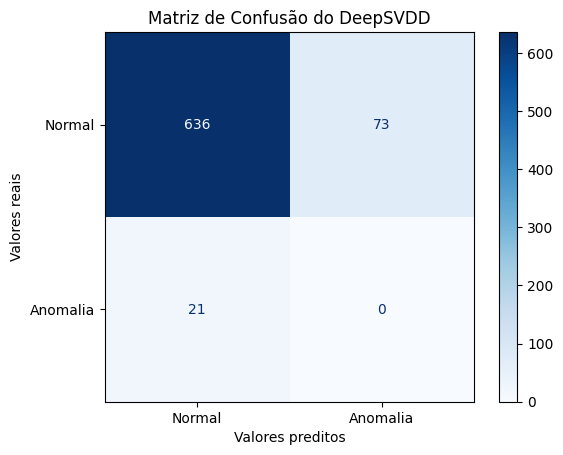

Acurácia=87,12
Precisão=0,00
Recall=0,00
F1=0,00
Falso Negativo=21
Falso Positivo=73
Verdadeiro Positivo=0


In [6]:
# Teste com as duas normalizações

grid_result = grid.fit(X_minmaxrobust, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_minmaxrobust)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' Robusta e minmax',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_338"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_226 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_225 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_225 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_225 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1184 - val_loss: 0.1050 - 148ms/epoch - 8ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1169 - val_loss: 0.1049 - 67ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1182 - val_loss: 0.1048 - 122ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1184 - val_loss: 0.1053 - 101ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1173 - val_loss: 0.1046 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1173 - val_loss: 0.1047 - 195ms/epoch - 10ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1191 - val_loss: 0.1049 - 65ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1182 - val_loss: 0.1050 - 121ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1169 - val_loss: 0.1045 - 70ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1171 - val_loss: 0.1045 - 62ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1171 - val_loss: 0.1045 - 88ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1182 - val_loss: 0.1047 - 82ms/epoch - 4ms/step
Epoch 89/1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_341"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_228 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_227 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_227 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_227 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1496 - val_loss: 0.1664 - 65ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1495 - val_loss: 0.1643 - 67ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1636 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1449 - val_loss: 0.1631 - 83ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1450 - val_loss: 0.1628 - 62ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1469 - val_loss: 0.1625 - 59ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1445 - val_loss: 0.1623 - 82ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1452 - val_loss: 0.1620 - 104ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1618 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1450 - val_loss: 0.1618 - 88ms/epoch - 5ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.1616 - 66ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1447 - val_loss: 0.1616 - 75ms/epoch - 4ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 926us/step
Model: "model_344"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_230 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_229 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_229 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_229 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1269 - val_loss: 0.1267 - 66ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1277 - val_loss: 0.1264 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1273 - val_loss: 0.1263 - 63ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1274 - val_loss: 0.1267 - 129ms/epoch - 7ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1272 - val_loss: 0.1264 - 57ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1272 - val_loss: 0.1265 - 58ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1272 - val_loss: 0.1264 - 62ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1273 - val_loss: 0.1263 - 129ms/epoch - 7ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1264 - val_loss: 0.1261 - 78ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1274 - val_loss: 0.1261 - 62ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1255 - val_loss: 0.1263 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1270 - val_loss: 0.1264 - 109ms/epoch - 6ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_347"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_232 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_231 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_231 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_231 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1530 - val_loss: 0.5824 - 66ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1539 - val_loss: 0.5732 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1538 - val_loss: 0.5925 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1546 - val_loss: 0.5867 - 128ms/epoch - 7ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1542 - val_loss: 0.5854 - 58ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1549 - val_loss: 0.5952 - 53ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1539 - val_loss: 0.5619 - 77ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1549 - val_loss: 0.5766 - 79ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1550 - val_loss: 0.5679 - 59ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1543 - val_loss: 0.5538 - 54ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1538 - val_loss: 0.5677 - 147ms/epoch - 8ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1537 - val_loss: 0.5593 - 58ms/epoch - 3ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_350"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_234 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_233 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_233 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_233 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1437 - val_loss: 0.1205 - 59ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1445 - val_loss: 0.1205 - 70ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1428 - val_loss: 0.1205 - 62ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1456 - val_loss: 0.1203 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1446 - val_loss: 0.1203 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1426 - val_loss: 0.1202 - 98ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1434 - val_loss: 0.1202 - 97ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1442 - val_loss: 0.1202 - 78ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1203 - 57ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1428 - val_loss: 0.1201 - 91ms/epoch - 5ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1201 - 69ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.1200 - 75ms/epoch - 4ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 952us/step
Model: "model_353"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_236 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_235 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_235 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_235 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1404 - val_loss: 0.1764 - 64ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1761 - 53ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1404 - val_loss: 0.1760 - 108ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.1761 - 61ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1757 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.1756 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1755 - 129ms/epoch - 7ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1412 - val_loss: 0.1759 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.1756 - 56ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1759 - 54ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1400 - val_loss: 0.1759 - 107ms/epoch - 6ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1407 - val_loss: 0.1754 - 66ms/epoch - 3ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 951us/step
Model: "model_356"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_238 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_237 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_237 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_237 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1602 - val_loss: 0.1420 - 72ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1618 - val_loss: 0.1423 - 56ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1621 - val_loss: 0.1416 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1612 - val_loss: 0.1420 - 62ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1607 - val_loss: 0.1414 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1603 - val_loss: 0.1412 - 72ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1621 - val_loss: 0.1416 - 54ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1624 - val_loss: 0.1411 - 56ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1626 - val_loss: 0.1407 - 61ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1606 - val_loss: 0.1406 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1604 - val_loss: 0.1409 - 58ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1611 - val_loss: 0.1407 - 69ms/epoch - 4ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 949us/step
Model: "model_359"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_240 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_239 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_239 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_239 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.5924 - 59ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1428 - val_loss: 0.6111 - 109ms/epoch - 6ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1438 - val_loss: 0.6040 - 84ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.6096 - 61ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1447 - val_loss: 0.6232 - 54ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.6003 - 94ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1431 - val_loss: 0.6066 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1446 - val_loss: 0.6008 - 63ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1438 - val_loss: 0.6004 - 65ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1440 - val_loss: 0.6029 - 105ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.5977 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1438 - val_loss: 0.6035 - 54ms/epoch - 3ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 952us/step
Model: "model_362"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_242 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_241 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_241 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_241 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1479 - 58ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1387 - val_loss: 0.1492 - 58ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1478 - 82ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1390 - val_loss: 0.1476 - 74ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1488 - 58ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1484 - 97ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1378 - val_loss: 0.1479 - 75ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1388 - val_loss: 0.1492 - 57ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1486 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1386 - val_loss: 0.1482 - 127ms/epoch - 7ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1491 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1364 - val_loss: 0.1491 - 134ms/epoch - 7ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 933us/step
Model: "model_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_244 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_243 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_243 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_243 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1138 - val_loss: 0.0982 - 64ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1133 - val_loss: 0.0985 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1142 - val_loss: 0.0986 - 91ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1134 - val_loss: 0.0983 - 74ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1138 - val_loss: 0.0985 - 71ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1137 - val_loss: 0.0983 - 58ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1127 - val_loss: 0.0980 - 57ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1126 - val_loss: 0.0980 - 79ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1140 - val_loss: 0.0980 - 66ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1135 - val_loss: 0.0983 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1134 - val_loss: 0.0984 - 95ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1139 - val_loss: 0.0982 - 62ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 952us/step
Model: "model_368"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_246 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_245 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_245 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_245 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1257 - val_loss: 0.1066 - 62ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1263 - val_loss: 0.1065 - 59ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1268 - val_loss: 0.1067 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1264 - val_loss: 0.1065 - 104ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1252 - val_loss: 0.1069 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1259 - val_loss: 0.1063 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1256 - val_loss: 0.1070 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1250 - val_loss: 0.1068 - 120ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1258 - val_loss: 0.1064 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1250 - val_loss: 0.1064 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1260 - val_loss: 0.1064 - 58ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1239 - val_loss: 0.1065 - 94ms/epoch - 5ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_371"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_248 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_247 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_247 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_247 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1619 - val_loss: 0.1660 - 108ms/epoch - 6ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1608 - val_loss: 0.1659 - 74ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1623 - val_loss: 0.1658 - 61ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1613 - val_loss: 0.1662 - 102ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1619 - val_loss: 0.1658 - 74ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1618 - val_loss: 0.1660 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1619 - val_loss: 0.1657 - 62ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1611 - val_loss: 0.1660 - 148ms/epoch - 8ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1620 - val_loss: 0.1653 - 72ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1617 - val_loss: 0.1660 - 106ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1622 - val_loss: 0.1660 - 98ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1612 - val_loss: 0.1652 - 59ms/epoch - 3ms/step
Epoch 89/100

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 952us/step
Model: "model_374"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_250 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_249 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_249 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_249 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1639 - val_loss: 0.1231 - 62ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1627 - val_loss: 0.1232 - 93ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1625 - val_loss: 0.1220 - 64ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1639 - val_loss: 0.1240 - 79ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1615 - val_loss: 0.1253 - 79ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1627 - val_loss: 0.1228 - 63ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1634 - val_loss: 0.1223 - 71ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1630 - val_loss: 0.1219 - 69ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1626 - val_loss: 0.1232 - 122ms/epoch - 6ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1612 - val_loss: 0.1234 - 69ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1639 - val_loss: 0.1215 - 62ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1615 - val_loss: 0.1217 - 61ms/epoch - 3ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 940us/step
Model: "model_377"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_252 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_251 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_251 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_251 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1567 - val_loss: 0.1536 - 63ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1556 - val_loss: 0.1526 - 109ms/epoch - 6ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1554 - val_loss: 0.1543 - 84ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1569 - val_loss: 0.1540 - 68ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1553 - val_loss: 0.1492 - 157ms/epoch - 8ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1570 - val_loss: 0.1554 - 64ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1567 - val_loss: 0.1508 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1561 - val_loss: 0.1510 - 62ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1553 - val_loss: 0.1537 - 109ms/epoch - 6ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1560 - val_loss: 0.1500 - 67ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1559 - val_loss: 0.1536 - 63ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1532 - val_loss: 0.1531 - 60ms/epoch - 3ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_380"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_254 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_253 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_253 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_253 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1393 - val_loss: 0.1735 - 64ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1395 - val_loss: 0.1735 - 76ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.1734 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1397 - val_loss: 0.1734 - 82ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1403 - val_loss: 0.1729 - 69ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1384 - val_loss: 0.1733 - 63ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1403 - val_loss: 0.1729 - 79ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1393 - val_loss: 0.1729 - 63ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1386 - val_loss: 0.1732 - 63ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1382 - val_loss: 0.1723 - 82ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.1729 - 63ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1389 - val_loss: 0.1728 - 80ms/epoch - 4ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_383"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_256 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_255 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_255 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_255 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1549 - val_loss: 0.1784 - 68ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1545 - val_loss: 0.1783 - 70ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1558 - val_loss: 0.1788 - 69ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1558 - val_loss: 0.1784 - 121ms/epoch - 6ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1561 - val_loss: 0.1783 - 64ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1557 - val_loss: 0.1787 - 66ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1557 - val_loss: 0.1781 - 71ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1564 - val_loss: 0.1787 - 145ms/epoch - 8ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1559 - val_loss: 0.1788 - 67ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1551 - val_loss: 0.1785 - 62ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1559 - val_loss: 0.1780 - 69ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1557 - val_loss: 0.1785 - 117ms/epoch - 6ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_386"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_258 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_257 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_257 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_257 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1480 - val_loss: 0.7504 - 65ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1486 - val_loss: 0.7217 - 169ms/epoch - 9ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1486 - val_loss: 0.7273 - 73ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1490 - val_loss: 0.7330 - 63ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1483 - val_loss: 0.7289 - 96ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1475 - val_loss: 0.7283 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1490 - val_loss: 0.7659 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1487 - val_loss: 0.7261 - 147ms/epoch - 8ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1489 - val_loss: 0.7084 - 63ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1483 - val_loss: 0.7325 - 68ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1488 - val_loss: 0.7339 - 111ms/epoch - 6ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1495 - val_loss: 0.7636 - 69ms/epoch - 4ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_389"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_260 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_259 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_259 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_259 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1907 - 69ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1908 - 72ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1400 - val_loss: 0.1910 - 81ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.1913 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1409 - val_loss: 0.1919 - 62ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1411 - val_loss: 0.1919 - 78ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1394 - val_loss: 0.1921 - 65ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1418 - val_loss: 0.1923 - 69ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1411 - val_loss: 0.1927 - 76ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.1929 - 68ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1413 - val_loss: 0.1933 - 93ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1413 - val_loss: 0.1935 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_392"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_262 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_261 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_261 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_261 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1405 - val_loss: 0.1166 - 59ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1415 - val_loss: 0.1156 - 91ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.1179 - 62ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1411 - val_loss: 0.1173 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1166 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.1172 - 90ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.1155 - 75ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1415 - val_loss: 0.1179 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1412 - val_loss: 0.1154 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1418 - val_loss: 0.1158 - 109ms/epoch - 6ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1409 - val_loss: 0.1172 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1415 - val_loss: 0.1162 - 58ms/epoch - 3ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_395"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_264 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_263 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_263 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_263 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1336 - val_loss: 0.1134 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1341 - val_loss: 0.1135 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1358 - val_loss: 0.1136 - 104ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1348 - val_loss: 0.1139 - 96ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1343 - val_loss: 0.1135 - 58ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1353 - val_loss: 0.1133 - 146ms/epoch - 8ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1354 - val_loss: 0.1138 - 63ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1341 - val_loss: 0.1132 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1340 - val_loss: 0.1133 - 105ms/epoch - 6ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1337 - val_loss: 0.1133 - 88ms/epoch - 5ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1337 - val_loss: 0.1135 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1345 - val_loss: 0.1133 - 134ms/epoch - 7ms/step
Epoch 89/100

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 928us/step
Model: "model_398"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_266 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_265 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_265 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_265 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.1267 - 63ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1418 - val_loss: 0.1266 - 61ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1416 - val_loss: 0.1265 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1263 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1409 - val_loss: 0.1263 - 93ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1412 - val_loss: 0.1264 - 62ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1415 - val_loss: 0.1261 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1407 - val_loss: 0.1265 - 113ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1409 - val_loss: 0.1260 - 63ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1261 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.1258 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1404 - val_loss: 0.1261 - 114ms/epoch - 6ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_401"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_268 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_267 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_267 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_267 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.1558 - 56ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1353 - val_loss: 0.1555 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1359 - val_loss: 0.1555 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1556 - 88ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1367 - val_loss: 0.1553 - 69ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.1557 - 63ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1357 - val_loss: 0.1555 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1363 - val_loss: 0.1556 - 157ms/epoch - 8ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.1554 - 57ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.1560 - 65ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1356 - val_loss: 0.1554 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.1554 - 96ms/epoch - 5ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 949us/step
Model: "model_404"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_270 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_269 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_269 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_269 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1388 - val_loss: 0.2620 - 108ms/epoch - 6ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1389 - val_loss: 0.2679 - 95ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1387 - val_loss: 0.2602 - 66ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1352 - val_loss: 0.2519 - 148ms/epoch - 8ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1336 - val_loss: 0.2525 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1341 - val_loss: 0.2601 - 57ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1338 - val_loss: 0.2472 - 89ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1330 - val_loss: 0.2480 - 91ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1338 - val_loss: 0.2412 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1336 - val_loss: 0.2387 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1333 - val_loss: 0.2437 - 126ms/epoch - 7ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1338 - val_loss: 0.2201 - 59ms/epoch - 3ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_407"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_272 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_271 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_271 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_271 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1572 - val_loss: 1.2406 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1573 - val_loss: 1.2163 - 76ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1584 - val_loss: 1.1965 - 71ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1577 - val_loss: 1.1853 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1572 - val_loss: 1.2151 - 124ms/epoch - 7ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1575 - val_loss: 1.1625 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1561 - val_loss: 1.1455 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1563 - val_loss: 1.1280 - 63ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1577 - val_loss: 1.1625 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1569 - val_loss: 1.1139 - 68ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1575 - val_loss: 1.1248 - 57ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1577 - val_loss: 1.0853 - 112ms/epoch - 6ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 927us/step
Model: "model_410"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_274 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_273 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_273 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_273 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1383 - val_loss: 0.1468 - 97ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1401 - val_loss: 0.1466 - 67ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1394 - val_loss: 0.1465 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1398 - val_loss: 0.1465 - 81ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1382 - val_loss: 0.1465 - 154ms/epoch - 8ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1396 - val_loss: 0.1464 - 170ms/epoch - 9ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1395 - val_loss: 0.1463 - 71ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1389 - val_loss: 0.1463 - 70ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1397 - val_loss: 0.1463 - 114ms/epoch - 6ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1395 - val_loss: 0.1462 - 81ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1392 - val_loss: 0.1463 - 64ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1387 - val_loss: 0.1463 - 161ms/epoch - 8ms/step
Epoch 89/100

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_413"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_276 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_275 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_275 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_275 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1505 - val_loss: 0.1845 - 62ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1504 - val_loss: 0.1825 - 87ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1508 - val_loss: 0.1820 - 62ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1500 - val_loss: 0.1837 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1496 - val_loss: 0.1825 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1520 - val_loss: 0.1849 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1502 - val_loss: 0.1805 - 62ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1500 - val_loss: 0.1808 - 67ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1503 - val_loss: 0.1837 - 57ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1493 - val_loss: 0.1806 - 79ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1496 - val_loss: 0.1844 - 61ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1492 - val_loss: 0.1799 - 58ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1000us/step
Model: "model_416"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_278 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_277 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_277 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_277 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 77/100
19/19 - 0s - loss: 0.1386 - val_loss: 0.1189 - 137ms/epoch - 7ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1355 - val_loss: 0.1190 - 59ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1361 - val_loss: 0.1191 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1365 - val_loss: 0.1189 - 58ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1355 - val_loss: 0.1195 - 90ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1361 - val_loss: 0.1190 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1355 - val_loss: 0.1190 - 57ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1355 - val_loss: 0.1193 - 74ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1190 - 114ms/epoch - 6ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1359 - val_loss: 0.1191 - 57ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1357 - val_loss: 0.1194 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1358 - val_loss: 0.1191 - 57ms/epoch - 3ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 902us/step
Model: "model_419"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_280 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_279 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_279 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_279 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1710 - val_loss: 0.1251 - 59ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1718 - val_loss: 0.1250 - 70ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1700 - val_loss: 0.1249 - 159ms/epoch - 8ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1724 - val_loss: 0.1248 - 59ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1716 - val_loss: 0.1247 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1697 - val_loss: 0.1249 - 92ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1704 - val_loss: 0.1248 - 80ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1705 - val_loss: 0.1248 - 95ms/epoch - 5ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1707 - val_loss: 0.1247 - 66ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1699 - val_loss: 0.1246 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1709 - val_loss: 0.1251 - 153ms/epoch - 8ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1710 - val_loss: 0.1249 - 60ms/epoch - 3ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 3ms/step
Model: "model_422"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_282 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_281 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_281 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_281 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1268 - val_loss: 0.1065 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1268 - val_loss: 0.1064 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1282 - val_loss: 0.1061 - 84ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1270 - val_loss: 0.1061 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1266 - val_loss: 0.1063 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1263 - val_loss: 0.1059 - 58ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1268 - val_loss: 0.1059 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1279 - val_loss: 0.1059 - 58ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1265 - val_loss: 0.1057 - 78ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1263 - val_loss: 0.1058 - 63ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1269 - val_loss: 0.1057 - 63ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1267 - val_loss: 0.1054 - 89ms/epoch - 5ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 952us/step
Model: "model_425"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_284 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_283 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_283 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_283 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1439 - val_loss: 0.1261 - 62ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.1262 - 58ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1462 - val_loss: 0.1262 - 139ms/epoch - 7ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1437 - val_loss: 0.1258 - 62ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1260 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1442 - val_loss: 0.1259 - 67ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1259 - 110ms/epoch - 6ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1438 - val_loss: 0.1260 - 68ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1260 - 73ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1428 - val_loss: 0.1262 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1457 - val_loss: 0.1264 - 93ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.1262 - 95ms/epoch - 5ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_428"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_286 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_285 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_285 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_285 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1305 - val_loss: 0.1287 - 173ms/epoch - 9ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1287 - val_loss: 0.1286 - 63ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1288 - val_loss: 0.1287 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1319 - val_loss: 0.1285 - 135ms/epoch - 7ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.1287 - 66ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1298 - val_loss: 0.1289 - 176ms/epoch - 9ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1287 - val_loss: 0.1290 - 63ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1328 - val_loss: 0.1289 - 113ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1289 - val_loss: 0.1287 - 65ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1280 - val_loss: 0.1292 - 69ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1292 - val_loss: 0.1287 - 115ms/epoch - 6ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1293 - val_loss: 0.1288 - 58ms/epoch - 3ms/step
Epoch 89/10

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_431"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_288 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_287 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_287 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_287 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1335 - val_loss: 0.2035 - 66ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1323 - val_loss: 0.2007 - 59ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1340 - val_loss: 0.2043 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1321 - val_loss: 0.2041 - 79ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1320 - val_loss: 0.2026 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1336 - val_loss: 0.2045 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1318 - val_loss: 0.2013 - 61ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1327 - val_loss: 0.1998 - 110ms/epoch - 6ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1318 - val_loss: 0.2061 - 64ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.2048 - 61ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1306 - val_loss: 0.2057 - 89ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1318 - val_loss: 0.2067 - 72ms/epoch - 4ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_434"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_290 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_289 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_289 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_289 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1576 - val_loss: 0.1444 - 63ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1581 - val_loss: 0.1443 - 157ms/epoch - 8ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1573 - val_loss: 0.1444 - 64ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1572 - val_loss: 0.1445 - 68ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1576 - val_loss: 0.1444 - 69ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1575 - val_loss: 0.1406 - 103ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1539 - val_loss: 0.1399 - 92ms/epoch - 5ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1537 - val_loss: 0.1391 - 62ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1522 - val_loss: 0.1389 - 63ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1529 - val_loss: 0.1388 - 137ms/epoch - 7ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1531 - val_loss: 0.1388 - 64ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1516 - val_loss: 0.1389 - 65ms/epoch - 3ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_437"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_292 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_291 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_291 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_291 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1390 - val_loss: 0.1778 - 65ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1787 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1742 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1767 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1394 - val_loss: 0.1794 - 64ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1386 - val_loss: 0.1822 - 62ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.1850 - 65ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1383 - val_loss: 0.1869 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1390 - val_loss: 0.1874 - 62ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1395 - val_loss: 0.1889 - 92ms/epoch - 5ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1382 - val_loss: 0.1910 - 63ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1389 - val_loss: 0.1899 - 90ms/epoch - 5ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 2ms/step
Model: "model_440"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_294 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_293 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_293 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_293 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1465 - val_loss: 0.1451 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1461 - val_loss: 0.1455 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1478 - val_loss: 0.1450 - 114ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1457 - val_loss: 0.1450 - 71ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1461 - val_loss: 0.1450 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1452 - val_loss: 0.1450 - 63ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1442 - val_loss: 0.1453 - 151ms/epoch - 8ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1453 - val_loss: 0.1449 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1451 - val_loss: 0.1448 - 63ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1454 - val_loss: 0.1448 - 76ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1449 - val_loss: 0.1448 - 111ms/epoch - 6ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1451 - val_loss: 0.1447 - 70ms/epoch - 4ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_443"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_296 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_295 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_295 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_295 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1679 - val_loss: 0.1699 - 68ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1679 - val_loss: 0.1698 - 66ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1706 - val_loss: 0.1696 - 119ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1691 - val_loss: 0.1703 - 86ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1680 - val_loss: 0.1699 - 67ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1660 - val_loss: 0.1700 - 163ms/epoch - 9ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1667 - val_loss: 0.1695 - 70ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1680 - val_loss: 0.1696 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1670 - val_loss: 0.1694 - 122ms/epoch - 6ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1685 - val_loss: 0.1694 - 76ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1675 - val_loss: 0.1691 - 69ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1676 - val_loss: 0.1691 - 61ms/epoch - 3ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_446"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_298 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_297 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_297 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_297 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1605 - val_loss: 0.1166 - 83ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1609 - val_loss: 0.1163 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1597 - val_loss: 0.1166 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1610 - val_loss: 0.1163 - 89ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1608 - val_loss: 0.1163 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1600 - val_loss: 0.1163 - 68ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1601 - val_loss: 0.1162 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1607 - val_loss: 0.1169 - 63ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1608 - val_loss: 0.1163 - 97ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1614 - val_loss: 0.1160 - 68ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1600 - val_loss: 0.1161 - 65ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1601 - val_loss: 0.1159 - 59ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_449"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_300 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_299 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_299 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_299 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.3301 - 44ms/epoch - 2ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1364 - val_loss: 0.3238 - 104ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.3291 - 51ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1359 - val_loss: 0.3248 - 49ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.3171 - 101ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1379 - val_loss: 0.3121 - 62ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1367 - val_loss: 0.3153 - 70ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1369 - val_loss: 0.3141 - 68ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1392 - val_loss: 0.3078 - 127ms/epoch - 7ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.3062 - 64ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.2987 - 63ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.2990 - 117ms/epoch - 6ms/step
Epoch 89/100

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_452"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_302 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_301 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_301 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_301 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1320 - val_loss: 0.1345 - 70ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1317 - val_loss: 0.1345 - 75ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1314 - val_loss: 0.1343 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1315 - val_loss: 0.1343 - 59ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1315 - val_loss: 0.1342 - 79ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1319 - val_loss: 0.1343 - 63ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1311 - val_loss: 0.1341 - 61ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1315 - val_loss: 0.1342 - 66ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1319 - val_loss: 0.1341 - 62ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1319 - val_loss: 0.1341 - 66ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1324 - val_loss: 0.1342 - 65ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1321 - val_loss: 0.1341 - 67ms/epoch - 4ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_455"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_304 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_303 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_303 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_303 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1454 - val_loss: 0.1243 - 61ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1462 - val_loss: 0.1245 - 93ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1456 - val_loss: 0.1243 - 84ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1443 - val_loss: 0.1235 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1452 - val_loss: 0.1240 - 68ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1458 - val_loss: 0.1241 - 59ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1451 - val_loss: 0.1240 - 116ms/epoch - 6ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1459 - val_loss: 0.1239 - 62ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1448 - val_loss: 0.1234 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1440 - val_loss: 0.1236 - 64ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1461 - val_loss: 0.1237 - 89ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1443 - val_loss: 0.1232 - 60ms/epoch - 3ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 960us/step
Model: "model_458"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_306 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_305 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_305 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_305 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1428 - val_loss: 0.1139 - 74ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1429 - val_loss: 0.1138 - 93ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1420 - val_loss: 0.1138 - 80ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1430 - val_loss: 0.1138 - 63ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1443 - val_loss: 0.1136 - 97ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1426 - val_loss: 0.1139 - 87ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.1134 - 61ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1432 - val_loss: 0.1134 - 127ms/epoch - 7ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1445 - val_loss: 0.1135 - 59ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1420 - val_loss: 0.1134 - 61ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.1132 - 92ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1429 - val_loss: 0.1131 - 79ms/epoch - 4ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 951us/step
Model: "model_461"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_308 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_307 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_307 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_307 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.1068 - 68ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1367 - val_loss: 0.1068 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1066 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1382 - val_loss: 0.1066 - 79ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1365 - val_loss: 0.1066 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1370 - val_loss: 0.1068 - 57ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1357 - val_loss: 0.1065 - 80ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1369 - val_loss: 0.1062 - 63ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1386 - val_loss: 0.1063 - 59ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1063 - 79ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1375 - val_loss: 0.1062 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1061 - 54ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 902us/step
Model: "model_464"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_310 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_309 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_309 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_309 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1698 - val_loss: 0.1517 - 93ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1708 - val_loss: 0.1516 - 62ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1711 - val_loss: 0.1516 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1708 - val_loss: 0.1517 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1705 - val_loss: 0.1520 - 88ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1708 - val_loss: 0.1519 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1702 - val_loss: 0.1519 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1699 - val_loss: 0.1520 - 61ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1704 - val_loss: 0.1519 - 133ms/epoch - 7ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1705 - val_loss: 0.1522 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1699 - val_loss: 0.1524 - 58ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1698 - val_loss: 0.1523 - 55ms/epoch - 3ms/step
Epoch 89/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 2ms/step
Model: "model_467"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_312 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_311 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_311 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_311 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1636 - val_loss: 0.1245 - 121ms/epoch - 6ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1635 - val_loss: 0.1244 - 54ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1635 - val_loss: 0.1245 - 52ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1641 - val_loss: 0.1246 - 148ms/epoch - 8ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1245 - 68ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1638 - val_loss: 0.1245 - 57ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1649 - val_loss: 0.1244 - 84ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1642 - val_loss: 0.1243 - 54ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1243 - 53ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1247 - 135ms/epoch - 7ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1631 - val_loss: 0.1244 - 64ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1641 - val_loss: 0.1244 - 152ms/epoch - 8ms/step
Epoch 89/100

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 3ms/step
Model: "model_470"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_314 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_313 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_313 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_313 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1303 - val_loss: 0.1363 - 56ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1311 - val_loss: 0.1363 - 91ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1298 - val_loss: 0.1364 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1302 - val_loss: 0.1363 - 54ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1308 - val_loss: 0.1363 - 77ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1293 - val_loss: 0.1362 - 59ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1310 - val_loss: 0.1361 - 56ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1305 - val_loss: 0.1361 - 75ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1308 - val_loss: 0.1360 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1304 - val_loss: 0.1362 - 59ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1296 - val_loss: 0.1359 - 89ms/epoch - 5ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1299 - val_loss: 0.1364 - 56ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 981us/step
Model: "model_473"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_316 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_315 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_315 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_315 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1308 - val_loss: 0.1470 - 61ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1297 - val_loss: 0.1466 - 105ms/epoch - 6ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1303 - val_loss: 0.1469 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1307 - val_loss: 0.1464 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1306 - val_loss: 0.1467 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1301 - val_loss: 0.1464 - 114ms/epoch - 6ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1308 - val_loss: 0.1467 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1305 - val_loss: 0.1465 - 61ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1315 - val_loss: 0.1468 - 94ms/epoch - 5ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1309 - val_loss: 0.1463 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1310 - val_loss: 0.1467 - 61ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1300 - val_loss: 0.1463 - 80ms/epoch - 4ms/step
Epoch 89/100
1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 986us/step
Model: "model_476"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_318 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_317 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_317 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_317 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1560 - val_loss: 0.1458 - 57ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1555 - val_loss: 0.1458 - 61ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1554 - val_loss: 0.1459 - 160ms/epoch - 8ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1554 - val_loss: 0.1455 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1525 - val_loss: 0.1416 - 57ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1515 - val_loss: 0.1412 - 92ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1518 - val_loss: 0.1412 - 83ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1515 - val_loss: 0.1411 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1518 - val_loss: 0.1414 - 187ms/epoch - 10ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1508 - val_loss: 0.1417 - 59ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1519 - val_loss: 0.1413 - 63ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1502 - val_loss: 0.1414 - 53ms/epoch - 3ms/step
Epoch 89/100


C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 902us/step
Model: "model_479"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_320 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_319 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_319 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_319 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1599 - val_loss: 0.1628 - 70ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1601 - val_loss: 0.1621 - 70ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1608 - val_loss: 0.1616 - 92ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1602 - val_loss: 0.1631 - 70ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1618 - val_loss: 0.1633 - 64ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1603 - val_loss: 0.1639 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1603 - val_loss: 0.1636 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1608 - val_loss: 0.1642 - 70ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1612 - val_loss: 0.1647 - 65ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1596 - val_loss: 0.1642 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1602 - val_loss: 0.1642 - 52ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1614 - val_loss: 0.1640 - 65ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_482"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_322 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_321 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_321 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_321 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1272 - val_loss: 0.1617 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1279 - val_loss: 0.1612 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1272 - val_loss: 0.1586 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1290 - val_loss: 0.1567 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1302 - val_loss: 0.1568 - 64ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1272 - val_loss: 0.1558 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1279 - val_loss: 0.1542 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1292 - val_loss: 0.1596 - 56ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1284 - val_loss: 0.1519 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1287 - val_loss: 0.1505 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1281 - val_loss: 0.1521 - 57ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1273 - val_loss: 0.1528 - 56ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_485"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_324 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_323 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_323 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_323 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1628 - val_loss: 0.1301 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1622 - val_loss: 0.1299 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1636 - val_loss: 0.1301 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1635 - val_loss: 0.1300 - 66ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1638 - val_loss: 0.1300 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1623 - val_loss: 0.1299 - 59ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1635 - val_loss: 0.1301 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1632 - val_loss: 0.1298 - 51ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1628 - val_loss: 0.1301 - 64ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1636 - val_loss: 0.1296 - 65ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1621 - val_loss: 0.1299 - 62ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1619 - val_loss: 0.1294 - 66ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_488"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_326 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_325 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_325 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_325 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1367 - val_loss: 0.1054 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.1046 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1379 - val_loss: 0.1058 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1364 - val_loss: 0.1040 - 58ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1368 - val_loss: 0.1044 - 69ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1364 - val_loss: 0.1042 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1369 - val_loss: 0.1048 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1363 - val_loss: 0.1042 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1378 - val_loss: 0.1044 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.1042 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1364 - val_loss: 0.1047 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1044 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_491"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_328 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_327 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_327 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_327 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1455 - val_loss: 0.1844 - 66ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1442 - val_loss: 0.1852 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1855 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1438 - val_loss: 0.1862 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1447 - val_loss: 0.1871 - 64ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1440 - val_loss: 0.1870 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.1873 - 66ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1445 - val_loss: 0.1877 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1449 - val_loss: 0.1879 - 65ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1446 - val_loss: 0.1878 - 65ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1448 - val_loss: 0.1879 - 59ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1465 - val_loss: 0.1885 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1000us/step
Model: "model_494"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_330 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_329 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_329 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_329 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 77/100
19/19 - 0s - loss: 0.1127 - val_loss: 0.1231 - 56ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1134 - val_loss: 0.1230 - 62ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1141 - val_loss: 0.1232 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1137 - val_loss: 0.1231 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1141 - val_loss: 0.1232 - 64ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1131 - val_loss: 0.1232 - 67ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1133 - val_loss: 0.1231 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1149 - val_loss: 0.1233 - 58ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1138 - val_loss: 0.1230 - 56ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1151 - val_loss: 0.1231 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1138 - val_loss: 0.1231 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1138 - val_loss: 0.1229 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_497"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_332 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_331 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_331 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_331 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1501 - val_loss: 0.1545 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1516 - val_loss: 0.1544 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1506 - val_loss: 0.1541 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1504 - val_loss: 0.1544 - 58ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1506 - val_loss: 0.1539 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1508 - val_loss: 0.1538 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1508 - val_loss: 0.1544 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1510 - val_loss: 0.1539 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1500 - val_loss: 0.1537 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1512 - val_loss: 0.1539 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1509 - val_loss: 0.1537 - 69ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1515 - val_loss: 0.1539 - 58ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_500"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_334 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_333 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_333 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_333 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.1893 - 65ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1904 - 69ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1909 - 67ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1379 - val_loss: 0.1914 - 69ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1387 - val_loss: 0.1918 - 70ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1369 - val_loss: 0.1923 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.1930 - 63ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1936 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1382 - val_loss: 0.1941 - 61ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1950 - 58ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1384 - val_loss: 0.1950 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.1955 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_503"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_336 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_335 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_335 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_335 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_335 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1637 - val_loss: 0.1681 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1644 - val_loss: 0.1680 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1629 - val_loss: 0.1674 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1629 - val_loss: 0.1649 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1597 - val_loss: 0.1639 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1597 - val_loss: 0.1633 - 61ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1592 - val_loss: 0.1633 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1590 - val_loss: 0.1631 - 61ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1586 - val_loss: 0.1628 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1588 - val_loss: 0.1625 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1599 - val_loss: 0.1628 - 63ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1589 - val_loss: 0.1629 - 65ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 968us/step
Model: "model_506"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_338 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_337 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_337 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_337 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1560 - val_loss: 0.1243 - 61ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1553 - val_loss: 0.1240 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1562 - val_loss: 0.1240 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1560 - val_loss: 0.1238 - 58ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1560 - val_loss: 0.1233 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1568 - val_loss: 0.1240 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1547 - val_loss: 0.1240 - 62ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1564 - val_loss: 0.1235 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1565 - val_loss: 0.1235 - 57ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1562 - val_loss: 0.1230 - 65ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1561 - val_loss: 0.1228 - 66ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1560 - val_loss: 0.1231 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_509"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_340 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_339 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_339 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_339 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1471 - val_loss: 0.1468 - 63ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1483 - val_loss: 0.1468 - 63ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1478 - val_loss: 0.1468 - 70ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1484 - val_loss: 0.1464 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1511 - val_loss: 0.1468 - 80ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1487 - val_loss: 0.1467 - 66ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1506 - val_loss: 0.1469 - 65ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1483 - val_loss: 0.1468 - 64ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1481 - val_loss: 0.1468 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1488 - val_loss: 0.1468 - 85ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1485 - val_loss: 0.1467 - 66ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1480 - val_loss: 0.1466 - 62ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_512"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_342 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_341 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_341 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_341 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1582 - val_loss: 0.1227 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1572 - val_loss: 0.1222 - 61ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1589 - val_loss: 0.1223 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1573 - val_loss: 0.1234 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1592 - val_loss: 0.1221 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1577 - val_loss: 0.1231 - 64ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1600 - val_loss: 0.1217 - 66ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1582 - val_loss: 0.1227 - 64ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1572 - val_loss: 0.1218 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1585 - val_loss: 0.1221 - 64ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1569 - val_loss: 0.1226 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1585 - val_loss: 0.1220 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_515"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_344 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_343 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_343 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_343 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1455 - val_loss: 0.1236 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1448 - val_loss: 0.1235 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1457 - val_loss: 0.1235 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1454 - val_loss: 0.1237 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1234 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1453 - val_loss: 0.1235 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1450 - val_loss: 0.1234 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1452 - val_loss: 0.1236 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1450 - val_loss: 0.1234 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1447 - val_loss: 0.1234 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1453 - val_loss: 0.1234 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1233 - 57ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_518"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_346 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_345 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_345 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_345 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1327 - val_loss: 0.1771 - 58ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1334 - val_loss: 0.1775 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.1784 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1331 - val_loss: 0.1795 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1336 - val_loss: 0.1802 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1338 - val_loss: 0.1813 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1325 - val_loss: 0.1824 - 62ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1334 - val_loss: 0.1828 - 58ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1329 - val_loss: 0.1837 - 59ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1338 - val_loss: 0.1851 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1321 - val_loss: 0.1854 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1322 - val_loss: 0.1858 - 59ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_521"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_348 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_347 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_347 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_347 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.2837 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.2792 - 73ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1416 - val_loss: 0.2755 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1405 - val_loss: 0.2781 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.2721 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1403 - val_loss: 0.2657 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1412 - val_loss: 0.2686 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1404 - val_loss: 0.2708 - 58ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1411 - val_loss: 0.2607 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1412 - val_loss: 0.2697 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.2596 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1400 - val_loss: 0.2572 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 920us/step
Model: "model_524"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_350 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_349 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_349 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_349 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1462 - val_loss: 0.5703 - 56ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1480 - val_loss: 0.5859 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1475 - val_loss: 0.5833 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1470 - val_loss: 0.5817 - 58ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1462 - val_loss: 0.5796 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1479 - val_loss: 0.5761 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1465 - val_loss: 0.5865 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1491 - val_loss: 0.5760 - 63ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1475 - val_loss: 0.5585 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1463 - val_loss: 0.5545 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1459 - val_loss: 0.5734 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1462 - val_loss: 0.5598 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 998us/step
Model: "model_527"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_352 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_351 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_351 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_351 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1587 - val_loss: 0.7550 - 53ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1577 - val_loss: 0.7335 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1577 - val_loss: 0.7229 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1573 - val_loss: 0.7175 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1567 - val_loss: 0.7120 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1585 - val_loss: 0.7058 - 54ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1569 - val_loss: 0.6975 - 50ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1563 - val_loss: 0.7215 - 54ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1579 - val_loss: 0.6832 - 56ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1568 - val_loss: 0.6795 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1572 - val_loss: 0.6865 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1565 - val_loss: 0.6805 - 63ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 992us/step
Model: "model_530"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_354 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_353 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_353 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_353 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1280 - val_loss: 0.1637 - 57ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1307 - val_loss: 0.1631 - 59ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1290 - val_loss: 0.1638 - 53ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1278 - val_loss: 0.1641 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1292 - val_loss: 0.1635 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1286 - val_loss: 0.1636 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1287 - val_loss: 0.1630 - 63ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1278 - val_loss: 0.1632 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1288 - val_loss: 0.1635 - 59ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1282 - val_loss: 0.1633 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1290 - val_loss: 0.1630 - 57ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1288 - val_loss: 0.1630 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_533"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_356 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_355 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_355 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_355 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.1776 - 67ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.1775 - 68ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.1775 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.1777 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1451 - val_loss: 0.1774 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1407 - val_loss: 0.1777 - 90ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1411 - val_loss: 0.1778 - 70ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.1776 - 57ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1416 - val_loss: 0.1776 - 50ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1419 - val_loss: 0.1776 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1409 - val_loss: 0.1776 - 65ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1413 - val_loss: 0.1776 - 59ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_536"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_358 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_357 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_357 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_357 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1599 - val_loss: 0.1684 - 52ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1590 - val_loss: 0.1684 - 63ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1595 - val_loss: 0.1681 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1589 - val_loss: 0.1689 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1594 - val_loss: 0.1678 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1588 - val_loss: 0.1678 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1601 - val_loss: 0.1683 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1594 - val_loss: 0.1673 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1596 - val_loss: 0.1681 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1587 - val_loss: 0.1671 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1590 - val_loss: 0.1678 - 58ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1625 - val_loss: 0.1673 - 52ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_539"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_360 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_359 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_359 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_359 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1680 - val_loss: 0.1686 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1678 - val_loss: 0.1688 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1675 - val_loss: 0.1687 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1677 - val_loss: 0.1688 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1680 - val_loss: 0.1686 - 53ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1684 - val_loss: 0.1689 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1673 - val_loss: 0.1688 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1664 - val_loss: 0.1688 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1662 - val_loss: 0.1687 - 61ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1669 - val_loss: 0.1686 - 56ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1671 - val_loss: 0.1687 - 50ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1680 - val_loss: 0.1686 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_542"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_362 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_361 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_361 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_361 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_361 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1304 - val_loss: 0.1811 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1313 - val_loss: 0.1798 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1313 - val_loss: 0.1805 - 54ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1317 - val_loss: 0.1780 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1297 - val_loss: 0.1764 - 53ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1308 - val_loss: 0.1751 - 54ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1305 - val_loss: 0.1747 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1306 - val_loss: 0.1744 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1299 - val_loss: 0.1729 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1302 - val_loss: 0.1729 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1314 - val_loss: 0.1730 - 55ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1299 - val_loss: 0.1728 - 55ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 804us/step
Model: "model_545"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_364 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_363 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_363 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_363 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1559 - val_loss: 0.1744 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1570 - val_loss: 0.1735 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1566 - val_loss: 0.1725 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1576 - val_loss: 0.1754 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1569 - val_loss: 0.1731 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1562 - val_loss: 0.1733 - 51ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1579 - val_loss: 0.1739 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1573 - val_loss: 0.1736 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1560 - val_loss: 0.1730 - 53ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1566 - val_loss: 0.1727 - 52ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1559 - val_loss: 0.1736 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1563 - val_loss: 0.1727 - 58ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 746us/step
Model: "model_548"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_366 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_365 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_365 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_365 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1328 - val_loss: 0.1662 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1330 - val_loss: 0.1661 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1331 - val_loss: 0.1658 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.1657 - 59ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1334 - val_loss: 0.1664 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1330 - val_loss: 0.1660 - 54ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1331 - val_loss: 0.1660 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1334 - val_loss: 0.1658 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1320 - val_loss: 0.1657 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1324 - val_loss: 0.1656 - 57ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1327 - val_loss: 0.1654 - 45ms/epoch - 2ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1330 - val_loss: 0.1653 - 40ms/epoch - 2ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_551"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_368 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_367 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_367 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_367 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.1262 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1359 - val_loss: 0.1250 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1253 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1254 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1357 - val_loss: 0.1248 - 53ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1353 - val_loss: 0.1245 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1371 - val_loss: 0.1246 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1345 - val_loss: 0.1242 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.1242 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1353 - val_loss: 0.1242 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1361 - val_loss: 0.1244 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1362 - val_loss: 0.1242 - 53ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 917us/step
Model: "model_554"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_370 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_369 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_369 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_369 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1365 - val_loss: 0.0975 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1379 - val_loss: 0.0975 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1365 - val_loss: 0.0975 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1382 - val_loss: 0.0977 - 59ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.0975 - 56ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.0975 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1394 - val_loss: 0.0973 - 56ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.0975 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1373 - val_loss: 0.0975 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1367 - val_loss: 0.0975 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1363 - val_loss: 0.0976 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.0975 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 955us/step
Model: "model_557"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_372 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_371 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_371 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_371 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1887 - val_loss: 0.2163 - 58ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1895 - val_loss: 0.2162 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1889 - val_loss: 0.2162 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1881 - val_loss: 0.2160 - 59ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1885 - val_loss: 0.2160 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1898 - val_loss: 0.2157 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1887 - val_loss: 0.2162 - 54ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1898 - val_loss: 0.2165 - 53ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1891 - val_loss: 0.2163 - 54ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1887 - val_loss: 0.2161 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1907 - val_loss: 0.2160 - 71ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1892 - val_loss: 0.2166 - 59ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 759us/step
Model: "model_560"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_374 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_373 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_373 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_373 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1341 - val_loss: 0.1090 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1350 - val_loss: 0.1090 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1345 - val_loss: 0.1090 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1345 - val_loss: 0.1088 - 50ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1351 - val_loss: 0.1089 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1345 - val_loss: 0.1089 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1341 - val_loss: 0.1088 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1343 - val_loss: 0.1090 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1343 - val_loss: 0.1088 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1372 - val_loss: 0.1087 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1339 - val_loss: 0.1093 - 57ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1345 - val_loss: 0.1089 - 59ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 869us/step
Model: "model_563"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_376 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_375 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_375 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_375 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1448 - val_loss: 0.1647 - 56ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1651 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1459 - val_loss: 0.1647 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1449 - val_loss: 0.1647 - 47ms/epoch - 2ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1460 - val_loss: 0.1650 - 43ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1456 - val_loss: 0.1647 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1459 - val_loss: 0.1648 - 62ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1452 - val_loss: 0.1648 - 61ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.1642 - 64ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1448 - val_loss: 0.1650 - 63ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1439 - val_loss: 0.1647 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1449 - val_loss: 0.1645 - 59ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 993us/step
Model: "model_566"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_378 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_377 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_377 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_377 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1640 - val_loss: 0.1763 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1634 - val_loss: 0.1778 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1636 - val_loss: 0.1762 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1630 - val_loss: 0.1777 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1634 - val_loss: 0.1774 - 53ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1639 - val_loss: 0.1743 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1629 - val_loss: 0.1755 - 57ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1641 - val_loss: 0.1781 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1636 - val_loss: 0.1739 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1657 - val_loss: 0.1772 - 57ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1639 - val_loss: 0.1784 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1641 - val_loss: 0.1757 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 849us/step
Model: "model_569"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_380 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_379 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_379 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_379 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1528 - val_loss: 0.1328 - 57ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1524 - val_loss: 0.1329 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1513 - val_loss: 0.1334 - 42ms/epoch - 2ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1521 - val_loss: 0.1329 - 50ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1522 - val_loss: 0.1328 - 40ms/epoch - 2ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1538 - val_loss: 0.1327 - 70ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1526 - val_loss: 0.1330 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1523 - val_loss: 0.1327 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1545 - val_loss: 0.1328 - 56ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1525 - val_loss: 0.1328 - 61ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1526 - val_loss: 0.1328 - 59ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1530 - val_loss: 0.1328 - 65ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_572"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_382 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_381 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_381 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_381 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1784 - val_loss: 0.2159 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1779 - val_loss: 0.2141 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1773 - val_loss: 0.2128 - 54ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1770 - val_loss: 0.2121 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1763 - val_loss: 0.2110 - 87ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1770 - val_loss: 0.2080 - 56ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1759 - val_loss: 0.2078 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1770 - val_loss: 0.2096 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1763 - val_loss: 0.2043 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1770 - val_loss: 0.2054 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1769 - val_loss: 0.2021 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1768 - val_loss: 0.1998 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 996us/step
Model: "model_575"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_384 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_383 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_383 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_383 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1647 - val_loss: 0.1585 - 59ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1652 - val_loss: 0.1606 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1660 - val_loss: 0.1593 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1659 - val_loss: 0.1598 - 70ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1658 - val_loss: 0.1606 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1659 - val_loss: 0.1608 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1662 - val_loss: 0.1619 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1648 - val_loss: 0.1618 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1648 - val_loss: 0.1628 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1645 - val_loss: 0.1631 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1657 - val_loss: 0.1624 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1642 - val_loss: 0.1633 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_578"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_386 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_385 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_385 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_385 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1536 - val_loss: 0.2119 - 65ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1537 - val_loss: 0.2063 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1548 - val_loss: 0.2013 - 61ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1547 - val_loss: 0.2020 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1550 - val_loss: 0.1970 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1552 - val_loss: 0.1930 - 62ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1544 - val_loss: 0.1876 - 63ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1543 - val_loss: 0.1868 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1549 - val_loss: 0.1879 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1549 - val_loss: 0.1876 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1543 - val_loss: 0.1883 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1546 - val_loss: 0.1880 - 56ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_581"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_388 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_387 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_387 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_387 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_387 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1224 - val_loss: 0.1026 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1226 - val_loss: 0.1029 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1230 - val_loss: 0.1024 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1230 - val_loss: 0.1023 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1223 - val_loss: 0.1023 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1234 - val_loss: 0.1022 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1235 - val_loss: 0.1020 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1215 - val_loss: 0.1024 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1232 - val_loss: 0.1022 - 59ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1217 - val_loss: 0.1021 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1227 - val_loss: 0.1020 - 60ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1217 - val_loss: 0.1024 - 61ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_584"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_390 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_389 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_389 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_389 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1446 - val_loss: 0.1571 - 80ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1447 - val_loss: 0.1569 - 61ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.1570 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1437 - val_loss: 0.1570 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.1570 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.1569 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.1571 - 64ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.1569 - 66ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1434 - val_loss: 0.1571 - 56ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1437 - val_loss: 0.1569 - 63ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.1571 - 64ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1431 - val_loss: 0.1570 - 67ms/epoch - 4ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_587"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_392 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_391 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_391 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_391 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1286 - val_loss: 0.0943 - 54ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1284 - val_loss: 0.0943 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1286 - val_loss: 0.0942 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1285 - val_loss: 0.0942 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1275 - val_loss: 0.0942 - 66ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1275 - val_loss: 0.0942 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1271 - val_loss: 0.0941 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1275 - val_loss: 0.0941 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1278 - val_loss: 0.0941 - 57ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1279 - val_loss: 0.0942 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1275 - val_loss: 0.0941 - 65ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1282 - val_loss: 0.0940 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_590"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_394 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_393 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_393 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_393 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.1124 - 65ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.1132 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1384 - val_loss: 0.1135 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1132 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1374 - val_loss: 0.1128 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1383 - val_loss: 0.1126 - 66ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1381 - val_loss: 0.1130 - 64ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1360 - val_loss: 0.1123 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1124 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1375 - val_loss: 0.1129 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1401 - val_loss: 0.1131 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1381 - val_loss: 0.1126 - 65ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 998us/step
Model: "model_593"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_396 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_395 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_395 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_395 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1629 - val_loss: 0.1609 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1633 - val_loss: 0.1601 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1632 - val_loss: 0.1608 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1640 - val_loss: 0.1607 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1636 - val_loss: 0.1601 - 56ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1635 - val_loss: 0.1603 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1633 - val_loss: 0.1601 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1621 - val_loss: 0.1612 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1629 - val_loss: 0.1608 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1638 - val_loss: 0.1597 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1611 - val_loss: 0.1606 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1635 - val_loss: 0.1604 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 994us/step
Model: "model_596"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_398 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_397 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_397 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_397 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1505 - val_loss: 0.1119 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1503 - val_loss: 0.1120 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1487 - val_loss: 0.1118 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1501 - val_loss: 0.1117 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1486 - val_loss: 0.1117 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1491 - val_loss: 0.1117 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1488 - val_loss: 0.1115 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1502 - val_loss: 0.1115 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1488 - val_loss: 0.1116 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1486 - val_loss: 0.1113 - 57ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1496 - val_loss: 0.1114 - 63ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1490 - val_loss: 0.1114 - 65ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 779us/step
Model: "model_599"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_400 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_399 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_399 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_399 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1701 - val_loss: 0.2014 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1675 - val_loss: 0.2032 - 58ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1693 - val_loss: 0.2040 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1689 - val_loss: 0.2032 - 70ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1690 - val_loss: 0.2085 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1676 - val_loss: 0.2026 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1693 - val_loss: 0.2061 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1700 - val_loss: 0.2056 - 60ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1694 - val_loss: 0.2051 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1693 - val_loss: 0.2038 - 53ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1683 - val_loss: 0.2079 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1699 - val_loss: 0.2068 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 995us/step
Model: "model_602"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_402 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_401 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_401 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_401 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1342 - val_loss: 0.1714 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1324 - val_loss: 0.1709 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1320 - val_loss: 0.1696 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1326 - val_loss: 0.1668 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1320 - val_loss: 0.1671 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1324 - val_loss: 0.1687 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1318 - val_loss: 0.1679 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1324 - val_loss: 0.1670 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1328 - val_loss: 0.1671 - 65ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1324 - val_loss: 0.1658 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1316 - val_loss: 0.1664 - 61ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1318 - val_loss: 0.1672 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_605"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_404 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_403 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_403 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_403 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1466 - val_loss: 0.2170 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1461 - val_loss: 0.2114 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1477 - val_loss: 0.2074 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1474 - val_loss: 0.2068 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1465 - val_loss: 0.2082 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1465 - val_loss: 0.1987 - 56ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1460 - val_loss: 0.1964 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1476 - val_loss: 0.1963 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1467 - val_loss: 0.2005 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1464 - val_loss: 0.2008 - 56ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1470 - val_loss: 0.2005 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1480 - val_loss: 0.2043 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_608"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_406 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_405 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_405 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_405 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_405 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1242 - val_loss: 0.6096 - 54ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1239 - val_loss: 0.6361 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1239 - val_loss: 0.6028 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1245 - val_loss: 0.6028 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1249 - val_loss: 0.6029 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1251 - val_loss: 0.6249 - 57ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1242 - val_loss: 0.6034 - 62ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1242 - val_loss: 0.5908 - 60ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1248 - val_loss: 0.5866 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1242 - val_loss: 0.5916 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1243 - val_loss: 0.5951 - 60ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1243 - val_loss: 0.5909 - 55ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_611"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_408 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_407 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_407 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_407 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1671 - 72ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.1670 - 95ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1674 - 64ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1434 - val_loss: 0.1670 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1422 - val_loss: 0.1667 - 54ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1433 - val_loss: 0.1669 - 48ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.1668 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1422 - val_loss: 0.1669 - 50ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.1666 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1427 - val_loss: 0.1665 - 51ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1426 - val_loss: 0.1665 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1423 - val_loss: 0.1668 - 52ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_614"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_410 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_409 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_409 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_409 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1339 - val_loss: 0.1596 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1339 - val_loss: 0.1596 - 54ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1321 - val_loss: 0.1594 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1338 - val_loss: 0.1597 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1335 - val_loss: 0.1592 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1324 - val_loss: 0.1593 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1336 - val_loss: 0.1594 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1349 - val_loss: 0.1593 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1329 - val_loss: 0.1591 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1323 - val_loss: 0.1592 - 56ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1324 - val_loss: 0.1590 - 55ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1327 - val_loss: 0.1592 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 916us/step
Model: "model_617"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_412 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_411 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_411 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_411 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1490 - val_loss: 0.1417 - 57ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1504 - val_loss: 0.1398 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1491 - val_loss: 0.1404 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1491 - val_loss: 0.1411 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1495 - val_loss: 0.1396 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1499 - val_loss: 0.1410 - 56ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1494 - val_loss: 0.1392 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1491 - val_loss: 0.1389 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1511 - val_loss: 0.1402 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1498 - val_loss: 0.1393 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1500 - val_loss: 0.1398 - 53ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1501 - val_loss: 0.1391 - 53ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_620"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_414 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_413 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_413 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_413 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1239 - val_loss: 0.5577 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1241 - val_loss: 0.5598 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1243 - val_loss: 0.5813 - 50ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1236 - val_loss: 0.5500 - 54ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1239 - val_loss: 0.5548 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1241 - val_loss: 0.5599 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1243 - val_loss: 0.5907 - 52ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1244 - val_loss: 0.5762 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1238 - val_loss: 0.5883 - 57ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1237 - val_loss: 0.5794 - 57ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1246 - val_loss: 0.5826 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1246 - val_loss: 0.5827 - 54ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_623"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_416 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_415 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_415 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_415 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1562 - val_loss: 0.1687 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1562 - val_loss: 0.1685 - 51ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1559 - val_loss: 0.1688 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1559 - val_loss: 0.1689 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1550 - val_loss: 0.1687 - 50ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1563 - val_loss: 0.1688 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1559 - val_loss: 0.1689 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1565 - val_loss: 0.1688 - 50ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1580 - val_loss: 0.1688 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1558 - val_loss: 0.1687 - 59ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1557 - val_loss: 0.1690 - 52ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1562 - val_loss: 0.1688 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1000us/step
Model: "model_626"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_418 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_417 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_417 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_417 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 77/100
19/19 - 0s - loss: 0.1283 - val_loss: 0.1549 - 50ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1273 - val_loss: 0.1546 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1268 - val_loss: 0.1548 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1276 - val_loss: 0.1549 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1273 - val_loss: 0.1548 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1259 - val_loss: 0.1548 - 57ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1271 - val_loss: 0.1548 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1264 - val_loss: 0.1549 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1273 - val_loss: 0.1549 - 52ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1258 - val_loss: 0.1552 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1264 - val_loss: 0.1553 - 54ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1266 - val_loss: 0.1553 - 58ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_629"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_420 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_419 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_419 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_419 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_419 (TFO  (None,)                  0 

Epoch 78/100
19/19 - 0s - loss: 0.1781 - val_loss: 0.1736 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1765 - val_loss: 0.1743 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1779 - val_loss: 0.1737 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1770 - val_loss: 0.1737 - 69ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1780 - val_loss: 0.1736 - 58ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1768 - val_loss: 0.1742 - 56ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1776 - val_loss: 0.1738 - 69ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1766 - val_loss: 0.1736 - 58ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1773 - val_loss: 0.1737 - 62ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1767 - val_loss: 0.1736 - 75ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1770 - val_loss: 0.1735 - 56ms/epoch - 3ms/step
Epoch 89/100
19/19 - 0s - loss: 0.1771 - val_loss: 0.1737 - 59ms/epoch - 3ms/step
Epoch 90/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 906us/step
Model: "model_632"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_422 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_421 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_421 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_421 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1471 - val_loss: 0.1556 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1554 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1495 - val_loss: 0.1551 - 63ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1554 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1483 - val_loss: 0.1554 - 75ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1486 - val_loss: 0.1549 - 58ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1467 - val_loss: 0.1555 - 58ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1474 - val_loss: 0.1548 - 66ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1457 - val_loss: 0.1545 - 62ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1466 - val_loss: 0.1543 - 60ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1470 - val_loss: 0.1545 - 65ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1457 - val_loss: 0.1544 - 75ms/epoch - 4ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 910us/step
Model: "model_635"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_424 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_423 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_423 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_423 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1382 - val_loss: 0.1225 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.1223 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1390 - val_loss: 0.1226 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1388 - val_loss: 0.1222 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1375 - val_loss: 0.1234 - 57ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1380 - val_loss: 0.1219 - 66ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1238 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1377 - val_loss: 0.1224 - 55ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1366 - val_loss: 0.1224 - 61ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1379 - val_loss: 0.1225 - 57ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1391 - val_loss: 0.1223 - 56ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1375 - val_loss: 0.1223 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 981us/step
Model: "model_638"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_426 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_425 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_425 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_425 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.0834 - 86ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.0833 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.0832 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1407 - val_loss: 0.0831 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1421 - val_loss: 0.0831 - 57ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1417 - val_loss: 0.0831 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1425 - val_loss: 0.0831 - 60ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1410 - val_loss: 0.0830 - 59ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1424 - val_loss: 0.0830 - 55ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1408 - val_loss: 0.0829 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1414 - val_loss: 0.0829 - 65ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1413 - val_loss: 0.0835 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 949us/step
Model: "model_641"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_428 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_427 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_427 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_427 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1404 - val_loss: 0.1485 - 57ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1405 - val_loss: 0.1488 - 75ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1396 - val_loss: 0.1488 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1403 - val_loss: 0.1492 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1398 - val_loss: 0.1493 - 64ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1397 - val_loss: 0.1491 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1392 - val_loss: 0.1495 - 59ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1395 - val_loss: 0.1497 - 67ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1407 - val_loss: 0.1499 - 65ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1386 - val_loss: 0.1500 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1419 - val_loss: 0.1503 - 68ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1405 - val_loss: 0.1502 - 55ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 944us/step
Model: "model_644"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_430 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_429 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_429 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_429 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1524 - val_loss: 0.5985 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1562 - val_loss: 0.6228 - 62ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1518 - val_loss: 0.5553 - 80ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1531 - val_loss: 0.5562 - 72ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1526 - val_loss: 0.5671 - 58ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1531 - val_loss: 0.5690 - 55ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1534 - val_loss: 0.5848 - 55ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1523 - val_loss: 0.5750 - 61ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1526 - val_loss: 0.5599 - 61ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1522 - val_loss: 0.5648 - 67ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1517 - val_loss: 0.5685 - 64ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1519 - val_loss: 0.5722 - 61ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_647"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_432 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_431 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_431 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_431 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1435 - val_loss: 0.1956 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1457 - val_loss: 0.1963 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.1966 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1436 - val_loss: 0.1966 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1459 - val_loss: 0.1968 - 83ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1438 - val_loss: 0.1970 - 60ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1452 - val_loss: 0.1973 - 67ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1441 - val_loss: 0.1973 - 61ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1438 - val_loss: 0.1973 - 64ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1455 - val_loss: 0.1979 - 57ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1447 - val_loss: 0.1980 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1448 - val_loss: 0.1971 - 60ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_650"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_434 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_433 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_433 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_433 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1274 - val_loss: 0.1525 - 62ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1284 - val_loss: 0.1531 - 66ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1281 - val_loss: 0.1527 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1269 - val_loss: 0.1534 - 62ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1281 - val_loss: 0.1535 - 75ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1272 - val_loss: 0.1534 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1275 - val_loss: 0.1540 - 68ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1267 - val_loss: 0.1543 - 66ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1268 - val_loss: 0.1544 - 63ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1268 - val_loss: 0.1545 - 59ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1275 - val_loss: 0.1551 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1268 - val_loss: 0.1552 - 67ms/epoch - 4ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_653"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_436 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_435 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_435 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_435 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1478 - val_loss: 0.1370 - 67ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1501 - val_loss: 0.1365 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1497 - val_loss: 0.1375 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1480 - val_loss: 0.1369 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1482 - val_loss: 0.1373 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1478 - val_loss: 0.1368 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1476 - val_loss: 0.1374 - 80ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1480 - val_loss: 0.1368 - 64ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1482 - val_loss: 0.1367 - 79ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1483 - val_loss: 0.1371 - 55ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1482 - val_loss: 0.1368 - 65ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1474 - val_loss: 0.1368 - 68ms/epoch - 4ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_656"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_438 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_437 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_437 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_437 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1472 - val_loss: 0.1023 - 61ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1454 - val_loss: 0.1022 - 75ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1460 - val_loss: 0.1020 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1460 - val_loss: 0.1019 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1438 - val_loss: 0.1018 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1469 - val_loss: 0.1018 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1450 - val_loss: 0.1016 - 63ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1460 - val_loss: 0.1015 - 70ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1461 - val_loss: 0.1014 - 70ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1454 - val_loss: 0.1014 - 64ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1446 - val_loss: 0.1014 - 61ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1444 - val_loss: 0.1017 - 64ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 973us/step
Model: "model_659"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_440 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_439 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_439 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_439 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1624 - val_loss: 0.2054 - 69ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1630 - val_loss: 0.2067 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1638 - val_loss: 0.2054 - 62ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1626 - val_loss: 0.2058 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1641 - val_loss: 0.2082 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1633 - val_loss: 0.2073 - 67ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1636 - val_loss: 0.2067 - 64ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1629 - val_loss: 0.2088 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1635 - val_loss: 0.2085 - 70ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1631 - val_loss: 0.2079 - 76ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1628 - val_loss: 0.2093 - 70ms/epoch - 4ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1640 - val_loss: 0.2093 - 65ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_662"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_442 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_441 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_441 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_441 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
19/19 - 0s - loss: 0.1463 - val_loss: 0.1708 - 64ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1460 - val_loss: 0.1686 - 70ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1416 - val_loss: 0.1675 - 61ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1429 - val_loss: 0.1681 - 75ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1417 - val_loss: 0.1676 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1406 - val_loss: 0.1671 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1407 - val_loss: 0.1674 - 66ms/epoch - 3ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1417 - val_loss: 0.1671 - 69ms/epoch - 4ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1402 - val_loss: 0.1668 - 74ms/epoch - 4ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1404 - val_loss: 0.1666 - 84ms/epoch - 4ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1413 - val_loss: 0.1667 - 65ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1412 - val_loss: 0.1666 - 69ms/epoch - 4ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 998us/step
Model: "model_665"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_444 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_443 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_443 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_443 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 77/100
19/19 - 0s - loss: 0.1174 - val_loss: 0.1076 - 70ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 0.1175 - val_loss: 0.1074 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 0.1165 - val_loss: 0.1079 - 71ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 0.1173 - val_loss: 0.1052 - 66ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 0.1167 - val_loss: 0.1056 - 64ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 0.1189 - val_loss: 0.1057 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 0.1166 - val_loss: 0.1059 - 73ms/epoch - 4ms/step
Epoch 84/100
19/19 - 0s - loss: 0.1164 - val_loss: 0.1060 - 65ms/epoch - 3ms/step
Epoch 85/100
19/19 - 0s - loss: 0.1177 - val_loss: 0.1065 - 63ms/epoch - 3ms/step
Epoch 86/100
19/19 - 0s - loss: 0.1174 - val_loss: 0.1070 - 65ms/epoch - 3ms/step
Epoch 87/100
19/19 - 0s - loss: 0.1177 - val_loss: 0.1074 - 60ms/epoch - 3ms/step
Epoch 88/100
19/19 - 0s - loss: 0.1160 - val_loss: 0.1081 - 66ms/epoch - 3ms/step
Epoch 89/100
19/

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


23/23 [==============================] - 0s 1ms/step
Model: "model_668"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_446 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_445 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_445 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_445 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 77/100
21/21 - 0s - loss: 0.1280 - val_loss: 0.1146 - 67ms/epoch - 3ms/step
Epoch 78/100
21/21 - 0s - loss: 0.1273 - val_loss: 0.1147 - 66ms/epoch - 3ms/step
Epoch 79/100
21/21 - 0s - loss: 0.1273 - val_loss: 0.1144 - 60ms/epoch - 3ms/step
Epoch 80/100
21/21 - 0s - loss: 0.1279 - val_loss: 0.1146 - 66ms/epoch - 3ms/step
Epoch 81/100
21/21 - 0s - loss: 0.1274 - val_loss: 0.1147 - 62ms/epoch - 3ms/step
Epoch 82/100
21/21 - 0s - loss: 0.1279 - val_loss: 0.1145 - 70ms/epoch - 3ms/step
Epoch 83/100
21/21 - 0s - loss: 0.1274 - val_loss: 0.1146 - 70ms/epoch - 3ms/step
Epoch 84/100
21/21 - 0s - loss: 0.1275 - val_loss: 0.1146 - 94ms/epoch - 4ms/step
Epoch 85/100
21/21 - 0s - loss: 0.1269 - val_loss: 0.1144 - 65ms/epoch - 3ms/step
Epoch 86/100
21/21 - 0s - loss: 0.1284 - val_loss: 0.1146 - 66ms/epoch - 3ms/step
Epoch 87/100
21/21 - 0s - loss: 0.1278 - val_loss: 0.1145 - 66ms/epoch - 3ms/step
Epoch 88/100
21/21 - 0s - loss: 0.1283 - val_loss: 0.1148 - 66ms/epoch - 3ms/step
Epoch 89/100
21/

Epoch 51/100
21/21 - 0s - loss: 0.1429 - val_loss: 0.1563 - 71ms/epoch - 3ms/step
Epoch 52/100
21/21 - 0s - loss: 0.1426 - val_loss: 0.1565 - 66ms/epoch - 3ms/step
Epoch 53/100
21/21 - 0s - loss: 0.1416 - val_loss: 0.1577 - 71ms/epoch - 3ms/step
Epoch 54/100
21/21 - 0s - loss: 0.1420 - val_loss: 0.1577 - 79ms/epoch - 4ms/step
Epoch 55/100
21/21 - 0s - loss: 0.1405 - val_loss: 0.1588 - 71ms/epoch - 3ms/step
Epoch 56/100
21/21 - 0s - loss: 0.1412 - val_loss: 0.1595 - 64ms/epoch - 3ms/step
Epoch 57/100
21/21 - 0s - loss: 0.1416 - val_loss: 0.1599 - 70ms/epoch - 3ms/step
Epoch 58/100
21/21 - 0s - loss: 0.1415 - val_loss: 0.1608 - 69ms/epoch - 3ms/step
Epoch 59/100
21/21 - 0s - loss: 0.1416 - val_loss: 0.1606 - 77ms/epoch - 4ms/step
Epoch 60/100
21/21 - 0s - loss: 0.1416 - val_loss: 0.1622 - 80ms/epoch - 4ms/step
Epoch 61/100
21/21 - 0s - loss: 0.1399 - val_loss: 0.1623 - 69ms/epoch - 3ms/step
Epoch 62/100
21/21 - 0s - loss: 0.1400 - val_loss: 0.1631 - 55ms/epoch - 3ms/step
Epoch 63/100
21/

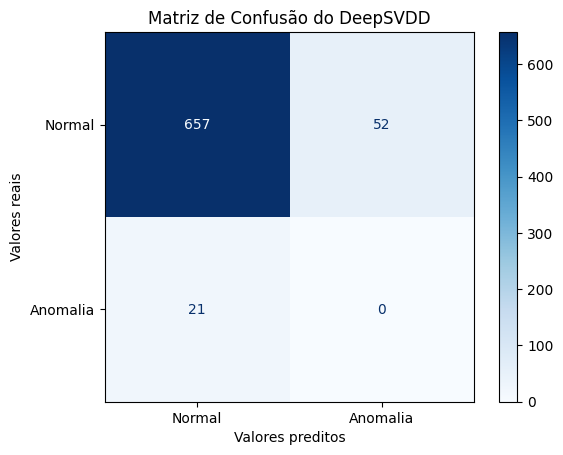

Acurácia=90,00
Precisão=0,00
Recall=0,00
F1=0,00
Falso Negativo=21
Falso Positivo=52
Verdadeiro Positivo=0


In [7]:
# Teste com só MinMax

grid_result = grid.fit(X_minmax, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_minmax)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' minmax',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

 1/21 [>.............................] - ETA: 1s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_674"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_450 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_449 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_449 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_449 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 14560.1758 - val_loss: 1989.2389 - 66ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13818.4834 - val_loss: 1966.8534 - 70ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 13388.5635 - val_loss: 1935.2075 - 64ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 12661.5859 - val_loss: 1906.8760 - 78ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 12105.2002 - val_loss: 1885.9105 - 74ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 11558.7109 - val_loss: 1858.9398 - 74ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 11143.8506 - val_loss: 1829.3022 - 73ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 10604.8760 - val_loss: 1811.7563 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 10165.8350 - val_loss: 1791.6631 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 9761.0283 - val_loss: 1759.9779 - 75ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 9353.2969 - val_loss: 1736.2123 - 87ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_677"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_452 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_451 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_451 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_451 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 25225.7422 - val_loss: 2136.1541 - 50ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 24506.7754 - val_loss: 2119.9697 - 61ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 23648.5879 - val_loss: 2091.5930 - 64ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 23038.6699 - val_loss: 2050.1125 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 23933.2520 - val_loss: 2015.3011 - 58ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 21398.3828 - val_loss: 1981.1089 - 65ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 38605.1992 - val_loss: 1956.6309 - 63ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 19995.8438 - val_loss: 1923.3820 - 61ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 18948.6699 - val_loss: 1888.8519 - 69ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 18303.1992 - val_loss: 1866.1040 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 17726.2695 - val_loss: 1830.6514 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1000us/step
Model: "model_680"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_454 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_453 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_453 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_453 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 71/100
19/19 - 0s - loss: 9022.0625 - val_loss: 4729.3281 - 79ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 8918.5391 - val_loss: 4661.9126 - 75ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 8493.4756 - val_loss: 4583.4673 - 68ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 8262.8662 - val_loss: 4501.3179 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 8044.6421 - val_loss: 4418.2036 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 7837.8281 - val_loss: 4393.1030 - 74ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 7596.1841 - val_loss: 4330.4688 - 80ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 7619.6655 - val_loss: 4305.2925 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 7461.9604 - val_loss: 4388.2461 - 69ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 7104.9673 - val_loss: 4410.3667 - 82ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 6946.0249 - val_loss: 4362.6504 - 74ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_683"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_456 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_455 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_455 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_455 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 18166.8027 - val_loss: 842.6604 - 89ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 17409.3242 - val_loss: 831.7435 - 68ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 16904.5820 - val_loss: 821.1885 - 78ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 16387.3789 - val_loss: 819.3994 - 69ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 15854.9707 - val_loss: 808.2000 - 66ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 15359.4248 - val_loss: 784.5280 - 70ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 14778.1064 - val_loss: 762.6151 - 94ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 14337.5215 - val_loss: 734.2415 - 76ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 15184.6172 - val_loss: 723.7746 - 70ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 13698.4297 - val_loss: 781.1623 - 74ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 13228.2422 - val_loss: 767.3372 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_686"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_458 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_457 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_457 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_457 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 15949.1592 - val_loss: 1674.9047 - 82ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 15495.7783 - val_loss: 1657.6865 - 86ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 15089.6328 - val_loss: 1640.4635 - 99ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 14353.0146 - val_loss: 1624.1740 - 88ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 13738.7920 - val_loss: 1610.1744 - 75ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 13465.1230 - val_loss: 1597.1556 - 75ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 12834.9658 - val_loss: 1581.0737 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 12467.8818 - val_loss: 1565.3271 - 69ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 11876.4521 - val_loss: 1549.5424 - 77ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 12365.7354 - val_loss: 1541.7783 - 93ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 11165.6777 - val_loss: 1541.3246 - 66ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_689"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_460 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_459 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_459 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_459 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 13090.6289 - val_loss: 1903.0321 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 12490.1338 - val_loss: 1888.6390 - 75ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 12044.6641 - val_loss: 1874.8008 - 75ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 11523.6338 - val_loss: 1853.4725 - 105ms/epoch - 6ms/step
Epoch 75/100
19/19 - 0s - loss: 11273.9170 - val_loss: 1824.6351 - 77ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 11354.3535 - val_loss: 1801.1708 - 90ms/epoch - 5ms/step
Epoch 77/100
19/19 - 0s - loss: 10121.9941 - val_loss: 1778.5187 - 71ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 9762.4570 - val_loss: 1757.2797 - 70ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 9278.2988 - val_loss: 1740.3165 - 67ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 9056.0859 - val_loss: 1718.6953 - 80ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 8543.8564 - val_loss: 1696.7163 - 69ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_692"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_462 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_461 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_461 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_461 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 72/100
19/19 - 0s - loss: 1211.4021 - val_loss: 337.9648 - 67ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 1141.4449 - val_loss: 335.6133 - 76ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 1095.5847 - val_loss: 332.3362 - 75ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 1052.3622 - val_loss: 333.3370 - 85ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 1005.1703 - val_loss: 331.5416 - 81ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 947.2153 - val_loss: 327.6539 - 65ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 910.5601 - val_loss: 280.9919 - 70ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 880.0593 - val_loss: 309.2603 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 828.8168 - val_loss: 342.3213 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 809.1199 - val_loss: 303.9499 - 85ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 764.6317 - val_loss: 302.8410 - 62ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 926.6896 - val_lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_695"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_464 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_463 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_463 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_463 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 19893.1289 - val_loss: 1625.4938 - 72ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 19249.7012 - val_loss: 1592.9916 - 69ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 18592.3379 - val_loss: 1555.8822 - 54ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 17659.3125 - val_loss: 1548.9609 - 70ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 17090.8945 - val_loss: 1528.6644 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 16476.9551 - val_loss: 1494.3741 - 75ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 29044.5684 - val_loss: 1466.1786 - 64ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 15134.0771 - val_loss: 1476.8833 - 77ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 14157.5508 - val_loss: 1454.0406 - 72ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 13540.1465 - val_loss: 1426.6547 - 85ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 12974.4092 - val_loss: 1398.7822 - 79ms/epoch - 4ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_698"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_466 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_465 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_465 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_465 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 11704.6357 - val_loss: 1630.9498 - 85ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 6478.3901 - val_loss: 1623.0811 - 87ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 6164.2148 - val_loss: 1615.0551 - 76ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 5784.8247 - val_loss: 1602.4078 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 5603.9224 - val_loss: 1590.9640 - 69ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 5275.1118 - val_loss: 1581.5775 - 69ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 5007.4321 - val_loss: 1568.6180 - 70ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 4834.2671 - val_loss: 1560.5719 - 94ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 4627.8320 - val_loss: 1556.0474 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 4430.4360 - val_loss: 1548.2485 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 4311.1753 - val_loss: 1537.0840 - 74ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss:

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_701"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_468 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_467 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_467 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_467 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 19933.4531 - val_loss: 11973.8330 - 98ms/epoch - 5ms/step
Epoch 71/100
19/19 - 0s - loss: 19353.6934 - val_loss: 11600.4326 - 99ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 18651.6172 - val_loss: 11276.3311 - 138ms/epoch - 7ms/step
Epoch 73/100
19/19 - 0s - loss: 18128.2871 - val_loss: 10968.3604 - 163ms/epoch - 9ms/step
Epoch 74/100
19/19 - 0s - loss: 17649.3223 - val_loss: 10590.7578 - 171ms/epoch - 9ms/step
Epoch 75/100
19/19 - 0s - loss: 16992.3066 - val_loss: 10299.8896 - 101ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 16393.4180 - val_loss: 10056.8701 - 82ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 15892.9492 - val_loss: 9811.1729 - 74ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 16551.0781 - val_loss: 9493.8047 - 92ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 14937.4395 - val_loss: 9226.0107 - 116ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 14516.2217 - val_loss: 9024.5205 - 198ms/epoch - 10ms/step
Epoch 8

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_704"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_470 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_469 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_469 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_469 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 22778.2871 - val_loss: 1166.3431 - 89ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 22033.2363 - val_loss: 1158.2156 - 72ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 21309.7754 - val_loss: 1129.9694 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 20651.8379 - val_loss: 1095.6215 - 72ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 21874.2188 - val_loss: 1082.3607 - 79ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 19480.3633 - val_loss: 1050.4647 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 18743.9043 - val_loss: 1021.8928 - 67ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 18206.0703 - val_loss: 987.9190 - 98ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 17669.8398 - val_loss: 986.7017 - 90ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 17140.8105 - val_loss: 1034.6556 - 102ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 16781.4375 - val_loss: 990.2999 - 81ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_707"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_472 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_471 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_471 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_471 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 18988.9590 - val_loss: 2234.8821 - 81ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 18428.4961 - val_loss: 2192.8838 - 83ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 17641.4785 - val_loss: 2165.9561 - 86ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 17253.7480 - val_loss: 2126.4492 - 69ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 16388.9648 - val_loss: 2089.1946 - 90ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 15716.3867 - val_loss: 2055.5005 - 97ms/epoch - 5ms/step
Epoch 77/100
19/19 - 0s - loss: 15161.9873 - val_loss: 2019.9130 - 128ms/epoch - 7ms/step
Epoch 78/100
19/19 - 0s - loss: 14765.4404 - val_loss: 2000.8451 - 76ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 13975.8047 - val_loss: 1969.2832 - 93ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 13598.2119 - val_loss: 1933.2623 - 129ms/epoch - 7ms/step
Epoch 81/100
19/19 - 0s - loss: 13011.5029 - val_loss: 1900.4183 - 97ms/epoch - 5ms/step
Epoch 82/100
19/19 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_710"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_474 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_473 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_473 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_473 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 11686.7324 - val_loss: 2051.3611 - 130ms/epoch - 7ms/step
Epoch 72/100
19/19 - 0s - loss: 11199.9346 - val_loss: 2017.2728 - 99ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 10842.2002 - val_loss: 2046.3540 - 105ms/epoch - 6ms/step
Epoch 74/100
19/19 - 0s - loss: 10366.3516 - val_loss: 2026.8724 - 111ms/epoch - 6ms/step
Epoch 75/100
19/19 - 0s - loss: 10049.7568 - val_loss: 2016.7457 - 101ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 9661.1758 - val_loss: 1991.2277 - 113ms/epoch - 6ms/step
Epoch 77/100
19/19 - 0s - loss: 9389.1953 - val_loss: 1964.5519 - 168ms/epoch - 9ms/step
Epoch 78/100
19/19 - 0s - loss: 8914.0342 - val_loss: 1928.6222 - 112ms/epoch - 6ms/step
Epoch 79/100
19/19 - 0s - loss: 8678.5137 - val_loss: 1922.9131 - 85ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 8286.7998 - val_loss: 1895.0853 - 127ms/epoch - 7ms/step
Epoch 81/100
19/19 - 0s - loss: 8025.0601 - val_loss: 1841.2871 - 105ms/epoch - 6ms/step
Epoch 82/100
19/19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_713"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_476 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_475 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_475 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_475 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 17655.6621 - val_loss: 963.2876 - 90ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 17093.3535 - val_loss: 943.3730 - 130ms/epoch - 7ms/step
Epoch 73/100
19/19 - 0s - loss: 16475.9590 - val_loss: 945.0229 - 126ms/epoch - 7ms/step
Epoch 74/100
19/19 - 0s - loss: 15893.1562 - val_loss: 937.3900 - 135ms/epoch - 7ms/step
Epoch 75/100
19/19 - 0s - loss: 15763.0166 - val_loss: 909.6089 - 102ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 14889.0332 - val_loss: 901.8679 - 85ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 14418.1533 - val_loss: 885.4100 - 83ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 13868.8916 - val_loss: 867.6883 - 171ms/epoch - 9ms/step
Epoch 79/100
19/19 - 0s - loss: 13328.9766 - val_loss: 854.1511 - 184ms/epoch - 10ms/step
Epoch 80/100
19/19 - 0s - loss: 12881.8594 - val_loss: 841.4214 - 79ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 24956.0059 - val_loss: 829.7991 - 96ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s -

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 2ms/step
Model: "model_716"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_478 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_477 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_477 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_477 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 10363.8740 - val_loss: 2308.0967 - 66ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 10030.2812 - val_loss: 2292.1221 - 85ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 9528.1914 - val_loss: 2280.6621 - 97ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 9895.2480 - val_loss: 2266.0662 - 142ms/epoch - 7ms/step
Epoch 75/100
19/19 - 0s - loss: 8768.7168 - val_loss: 2263.1016 - 134ms/epoch - 7ms/step
Epoch 76/100
19/19 - 0s - loss: 8470.6016 - val_loss: 2264.9558 - 103ms/epoch - 5ms/step
Epoch 77/100
19/19 - 0s - loss: 8062.9927 - val_loss: 2255.9111 - 81ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 8276.3594 - val_loss: 2238.4568 - 72ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 7488.3496 - val_loss: 2230.9128 - 85ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 7214.5576 - val_loss: 2230.5205 - 68ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 6856.3257 - val_loss: 2218.0671 - 73ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_719"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_480 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_479 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_479 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_479 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 4635.6455 - val_loss: 1147.2466 - 115ms/epoch - 6ms/step
Epoch 72/100
19/19 - 0s - loss: 4356.9531 - val_loss: 1138.1152 - 84ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 4132.5283 - val_loss: 1126.6820 - 68ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 3992.3618 - val_loss: 1114.1820 - 73ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 3831.0444 - val_loss: 1111.7797 - 100ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 3629.0601 - val_loss: 1104.9010 - 103ms/epoch - 5ms/step
Epoch 77/100
19/19 - 0s - loss: 3520.2673 - val_loss: 1097.5211 - 79ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 3395.4138 - val_loss: 1101.3407 - 88ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 3207.0266 - val_loss: 1101.2391 - 106ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 3106.9868 - val_loss: 1095.7770 - 116ms/epoch - 6ms/step
Epoch 81/100
19/19 - 0s - loss: 2942.6038 - val_loss: 1091.0865 - 130ms/epoch - 7ms/step
Epoch 82/100
19/19 - 0s - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_722"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_482 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_481 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_481 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_481 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

19/19 - 0s - loss: 1177.6040 - val_loss: 657.2691 - 66ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 1134.6455 - val_loss: 632.8995 - 73ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 1138.0139 - val_loss: 644.7051 - 80ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 1053.5015 - val_loss: 638.3729 - 89ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 1017.3506 - val_loss: 628.0203 - 86ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 966.4324 - val_loss: 609.3396 - 98ms/epoch - 5ms/step
Epoch 77/100
19/19 - 0s - loss: 962.2469 - val_loss: 621.1531 - 84ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 907.6489 - val_loss: 613.4031 - 90ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 877.7155 - val_loss: 603.3721 - 68ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 840.9837 - val_loss: 602.4290 - 71ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 813.5283 - val_loss: 596.3648 - 80ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 784.2706 - val_loss: 590.7778 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_725"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_484 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_483 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_483 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_483 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 10301.1436 - val_loss: 1601.1670 - 91ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 9865.6426 - val_loss: 1584.9609 - 63ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 9522.1016 - val_loss: 1567.7290 - 85ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 9184.5068 - val_loss: 1547.5840 - 86ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 8780.4658 - val_loss: 1534.8402 - 73ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 8546.7744 - val_loss: 1467.5272 - 70ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 8758.8164 - val_loss: 1515.9139 - 105ms/epoch - 6ms/step
Epoch 78/100
19/19 - 0s - loss: 7923.9185 - val_loss: 1502.3698 - 112ms/epoch - 6ms/step
Epoch 79/100
19/19 - 0s - loss: 7520.0952 - val_loss: 1482.7443 - 72ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 7092.5483 - val_loss: 1466.7098 - 98ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 6834.3721 - val_loss: 1458.4951 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_728"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_486 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_485 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_485 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_485 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

19/19 - 0s - loss: 25070.7969 - val_loss: 1115.5973 - 79ms/epoch - 4ms/step
Epoch 71/100
19/19 - 0s - loss: 23694.0098 - val_loss: 1113.2228 - 82ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 23194.9707 - val_loss: 1102.3534 - 93ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 23821.4863 - val_loss: 1090.0659 - 91ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 21011.1406 - val_loss: 1089.8568 - 70ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 20288.2832 - val_loss: 1082.2427 - 86ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 19394.9395 - val_loss: 1071.9425 - 72ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 18935.2168 - val_loss: 1061.1349 - 74ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 18051.3066 - val_loss: 1050.6974 - 82ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 17212.2539 - val_loss: 1040.4418 - 125ms/epoch - 7ms/step
Epoch 80/100
19/19 - 0s - loss: 16663.4629 - val_loss: 1029.7227 - 87ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_731"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_488 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_487 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_487 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_487 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 41780.7109 - val_loss: 3510.0195 - 88ms/epoch - 5ms/step
Epoch 71/100
19/19 - 0s - loss: 40810.3047 - val_loss: 3441.4817 - 75ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 39474.6250 - val_loss: 3369.3699 - 98ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 38279.2227 - val_loss: 3312.7000 - 113ms/epoch - 6ms/step
Epoch 74/100
19/19 - 0s - loss: 37528.3242 - val_loss: 3263.5723 - 86ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 36196.0820 - val_loss: 3251.1006 - 108ms/epoch - 6ms/step
Epoch 76/100
19/19 - 0s - loss: 35522.3438 - val_loss: 3201.0745 - 99ms/epoch - 5ms/step
Epoch 77/100
19/19 - 0s - loss: 34154.1758 - val_loss: 3141.7119 - 99ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 33302.2930 - val_loss: 3077.0476 - 90ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 32325.0371 - val_loss: 2981.2629 - 71ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 31157.4707 - val_loss: 2988.8223 - 89ms/epoch - 5ms/step
Epoch 81/100
19/19 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_734"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_490 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_489 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_489 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_489 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 13337.8574 - val_loss: 1586.2218 - 75ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 12743.2578 - val_loss: 1576.1786 - 83ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 12305.8896 - val_loss: 1558.2614 - 76ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 12536.4346 - val_loss: 1539.2811 - 76ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 11325.4287 - val_loss: 1511.7594 - 168ms/epoch - 9ms/step
Epoch 76/100
19/19 - 0s - loss: 10815.8535 - val_loss: 1498.2872 - 80ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 10419.9229 - val_loss: 1465.3737 - 94ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 9946.2031 - val_loss: 1475.7982 - 67ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 9620.8555 - val_loss: 1458.0006 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 9815.1016 - val_loss: 1441.3217 - 63ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 8818.0811 - val_loss: 1419.6113 - 82ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_737"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_492 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_491 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_491 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_491 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 12807.1084 - val_loss: 1263.7328 - 87ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 12166.9131 - val_loss: 1252.7695 - 62ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 12738.4092 - val_loss: 1243.0605 - 63ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 11171.4561 - val_loss: 1232.4213 - 75ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 10759.5771 - val_loss: 1220.9987 - 80ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 10189.9580 - val_loss: 1209.8053 - 67ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 9909.8516 - val_loss: 1206.3861 - 63ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 9449.4287 - val_loss: 1196.2731 - 77ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 9075.7734 - val_loss: 1181.3666 - 72ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 8784.8643 - val_loss: 1181.2045 - 83ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 8331.9277 - val_loss: 1172.2579 - 86ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_740"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_494 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_493 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_493 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_493 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 25635.0605 - val_loss: 1848.4731 - 71ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 24665.5039 - val_loss: 1810.2184 - 70ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 23924.0059 - val_loss: 1801.6830 - 63ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 23508.7344 - val_loss: 1771.6105 - 65ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 22291.8086 - val_loss: 1757.1343 - 66ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 21928.6914 - val_loss: 1731.0150 - 63ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 20792.0293 - val_loss: 1713.2621 - 72ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 20253.2988 - val_loss: 1683.7955 - 67ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 19500.0664 - val_loss: 1658.1127 - 81ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 20230.9668 - val_loss: 1638.7769 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 18203.4688 - val_loss: 1611.4531 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_743"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_496 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_495 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_495 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_495 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 72/100
19/19 - 0s - loss: 14109.7578 - val_loss: 472.6360 - 88ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 13395.0039 - val_loss: 465.7935 - 99ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 13157.6904 - val_loss: 461.5652 - 67ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 12291.1396 - val_loss: 455.2423 - 68ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 11755.6104 - val_loss: 449.9678 - 68ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 11220.6123 - val_loss: 444.3669 - 70ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 10705.5312 - val_loss: 438.0391 - 74ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 10279.4873 - val_loss: 433.3786 - 75ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 9788.3623 - val_loss: 427.7468 - 68ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 9391.6504 - val_loss: 422.7458 - 64ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 9008.9346 - val_loss: 417.1879 - 69ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 851

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_746"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_498 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_497 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_497 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_497 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 10948.1055 - val_loss: 2018.3141 - 79ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 10488.4434 - val_loss: 1985.1871 - 82ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 10242.2568 - val_loss: 1933.5005 - 90ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 9826.1660 - val_loss: 1889.1256 - 84ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 9579.7090 - val_loss: 1855.9327 - 96ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 9192.4688 - val_loss: 1818.3307 - 78ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 8958.3174 - val_loss: 1783.7020 - 84ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 8607.5439 - val_loss: 1757.0778 - 68ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 8361.0078 - val_loss: 1719.4857 - 92ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 8199.9609 - val_loss: 1674.6744 - 83ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 7789.7983 - val_loss: 1639.4183 - 67ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_749"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_500 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_499 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_499 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_499 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 30739.6289 - val_loss: 5914.2344 - 77ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 27667.5293 - val_loss: 5886.6108 - 76ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 28504.6914 - val_loss: 5857.9536 - 80ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 25833.1504 - val_loss: 5832.5645 - 100ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 24895.1211 - val_loss: 5806.2729 - 122ms/epoch - 6ms/step
Epoch 76/100
19/19 - 0s - loss: 24141.6934 - val_loss: 5780.3691 - 113ms/epoch - 6ms/step
Epoch 77/100
19/19 - 0s - loss: 23403.2988 - val_loss: 5759.8120 - 78ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 22674.5371 - val_loss: 5734.6733 - 88ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 21853.1504 - val_loss: 5701.9712 - 87ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 21174.1797 - val_loss: 5701.5586 - 75ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 20526.5566 - val_loss: 5686.4741 - 80ms/epoch - 4ms/step
Epoch 82/100
19/19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_752"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_502 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_501 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_501 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_501 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 72/100
19/19 - 0s - loss: 1576.5537 - val_loss: 539.4938 - 68ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 1526.3165 - val_loss: 531.0458 - 63ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 1548.5393 - val_loss: 541.7840 - 87ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 1443.1763 - val_loss: 536.5889 - 94ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 1364.1018 - val_loss: 525.6696 - 142ms/epoch - 7ms/step
Epoch 77/100
19/19 - 0s - loss: 1646.6721 - val_loss: 517.0599 - 90ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 1263.6722 - val_loss: 520.8190 - 95ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 1215.2797 - val_loss: 510.5688 - 78ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 1158.1803 - val_loss: 507.9114 - 81ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 1130.3883 - val_loss: 508.1728 - 67ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 1088.0901 - val_loss: 503.0872 - 83ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 1069.0842 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_755"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_504 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_503 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_503 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_503 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 17520.5430 - val_loss: 2561.9260 - 103ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 16811.3496 - val_loss: 2494.9387 - 103ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 18728.1172 - val_loss: 2552.7295 - 75ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 15862.7666 - val_loss: 2556.2683 - 81ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 15199.3408 - val_loss: 2543.7954 - 113ms/epoch - 6ms/step
Epoch 76/100
19/19 - 0s - loss: 14667.3291 - val_loss: 2529.7786 - 76ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 14129.1689 - val_loss: 2514.5530 - 85ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 13544.6484 - val_loss: 2458.1741 - 101ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 27320.3301 - val_loss: 2487.1570 - 71ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 13284.0713 - val_loss: 2485.9062 - 76ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 12849.6865 - val_loss: 2475.8242 - 95ms/epoch - 5ms/step
Epoch 82/100
19/1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_758"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_506 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_505 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_505 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_505 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 10321.3164 - val_loss: 777.4495 - 189ms/epoch - 10ms/step
Epoch 72/100
19/19 - 0s - loss: 9852.8311 - val_loss: 772.9470 - 89ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 9610.4326 - val_loss: 767.6089 - 111ms/epoch - 6ms/step
Epoch 74/100
19/19 - 0s - loss: 9772.1885 - val_loss: 771.4661 - 70ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 9313.3672 - val_loss: 768.6348 - 75ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 8373.9404 - val_loss: 763.1384 - 81ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 7925.9399 - val_loss: 758.3230 - 67ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 7577.0508 - val_loss: 756.2963 - 103ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 7288.8716 - val_loss: 751.5120 - 98ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 6944.8257 - val_loss: 755.6187 - 80ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 6719.8369 - val_loss: 754.8787 - 77ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 6359.9

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_761"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_508 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_507 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_507 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_507 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 6610.9155 - val_loss: 1187.4257 - 80ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 6431.8975 - val_loss: 1164.9738 - 133ms/epoch - 7ms/step
Epoch 73/100
19/19 - 0s - loss: 6374.8301 - val_loss: 1154.3618 - 92ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 5701.1821 - val_loss: 1146.9620 - 88ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 5532.2686 - val_loss: 1129.6311 - 98ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 5144.6455 - val_loss: 1126.4658 - 114ms/epoch - 6ms/step
Epoch 77/100
19/19 - 0s - loss: 4871.0820 - val_loss: 1112.9829 - 140ms/epoch - 7ms/step
Epoch 78/100
19/19 - 0s - loss: 4622.0322 - val_loss: 1096.9388 - 135ms/epoch - 7ms/step
Epoch 79/100
19/19 - 0s - loss: 4378.8267 - val_loss: 1083.6925 - 190ms/epoch - 10ms/step
Epoch 80/100
19/19 - 0s - loss: 4211.7046 - val_loss: 1067.1844 - 140ms/epoch - 7ms/step
Epoch 81/100
19/19 - 0s - loss: 4013.5762 - val_loss: 1063.0594 - 99ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s -

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_764"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_510 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_509 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_509 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_509 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 27332.6250 - val_loss: 2812.0774 - 69ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 24754.0410 - val_loss: 2801.4441 - 104ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 43115.2930 - val_loss: 2779.7341 - 106ms/epoch - 6ms/step
Epoch 74/100
19/19 - 0s - loss: 22556.7910 - val_loss: 2743.1130 - 87ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 21815.5566 - val_loss: 2736.3105 - 102ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 20944.7598 - val_loss: 2712.9758 - 125ms/epoch - 7ms/step
Epoch 77/100
19/19 - 0s - loss: 20066.7266 - val_loss: 2687.5979 - 82ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 19615.5781 - val_loss: 2653.7722 - 87ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 18772.0547 - val_loss: 2638.4861 - 99ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 18201.1484 - val_loss: 2610.1462 - 140ms/epoch - 7ms/step
Epoch 81/100
19/19 - 0s - loss: 17562.7871 - val_loss: 2586.9011 - 139ms/epoch - 7ms/step
Epoch 82/100
19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_767"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_512 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_511 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_511 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_511 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 6546.6123 - val_loss: 1986.4745 - 70ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 6211.0264 - val_loss: 1972.5204 - 73ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 5990.2598 - val_loss: 1932.6622 - 92ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 5815.0889 - val_loss: 1904.0508 - 103ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 9581.3828 - val_loss: 1874.6774 - 87ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 5211.8403 - val_loss: 1812.9691 - 88ms/epoch - 5ms/step
Epoch 77/100
19/19 - 0s - loss: 4960.1255 - val_loss: 1779.2699 - 92ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 4729.4077 - val_loss: 1757.0599 - 104ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 4573.8364 - val_loss: 1725.8290 - 104ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 4374.7686 - val_loss: 1702.4175 - 108ms/epoch - 6ms/step
Epoch 81/100
19/19 - 0s - loss: 4253.7773 - val_loss: 1670.0958 - 91ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_770"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_514 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_513 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_513 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_513 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 5795.1113 - val_loss: 1258.3837 - 143ms/epoch - 8ms/step
Epoch 72/100
19/19 - 0s - loss: 5331.7251 - val_loss: 1253.2592 - 80ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 5111.1182 - val_loss: 1253.9918 - 74ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 4842.5986 - val_loss: 1240.1954 - 83ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 4613.4580 - val_loss: 1222.2611 - 126ms/epoch - 7ms/step
Epoch 76/100
19/19 - 0s - loss: 4421.5679 - val_loss: 1219.8314 - 127ms/epoch - 7ms/step
Epoch 77/100
19/19 - 0s - loss: 4234.0898 - val_loss: 1205.8295 - 126ms/epoch - 7ms/step
Epoch 78/100
19/19 - 0s - loss: 4057.7126 - val_loss: 1216.9834 - 158ms/epoch - 8ms/step
Epoch 79/100
19/19 - 0s - loss: 3884.3647 - val_loss: 1212.2914 - 84ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 3884.0186 - val_loss: 1206.0687 - 100ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 3722.7546 - val_loss: 1197.8126 - 87ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 2ms/step
Model: "model_773"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_516 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_515 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_515 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_515 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

19/19 - 0s - loss: 24659.3906 - val_loss: 1874.3335 - 81ms/epoch - 4ms/step
Epoch 71/100
19/19 - 0s - loss: 23621.3184 - val_loss: 1853.2604 - 93ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 22972.8594 - val_loss: 1824.3629 - 162ms/epoch - 9ms/step
Epoch 73/100
19/19 - 0s - loss: 22471.4004 - val_loss: 1783.0718 - 103ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 21612.6797 - val_loss: 1785.2570 - 83ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 21132.1270 - val_loss: 1755.6465 - 86ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 20311.4883 - val_loss: 1721.7181 - 104ms/epoch - 5ms/step
Epoch 77/100
19/19 - 0s - loss: 19559.9785 - val_loss: 1692.1888 - 103ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 18862.3086 - val_loss: 1678.8506 - 145ms/epoch - 8ms/step
Epoch 79/100
19/19 - 0s - loss: 18375.0898 - val_loss: 1655.5521 - 92ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 17655.7500 - val_loss: 1635.1461 - 73ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_776"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_518 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_517 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_517 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_517 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 13136.4805 - val_loss: 6932.9004 - 76ms/epoch - 4ms/step
Epoch 71/100
19/19 - 0s - loss: 12181.7861 - val_loss: 6658.7593 - 98ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 11723.5293 - val_loss: 6352.0723 - 145ms/epoch - 8ms/step
Epoch 73/100
19/19 - 0s - loss: 11179.5391 - val_loss: 6085.0488 - 101ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 10682.8154 - val_loss: 5842.7085 - 103ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 10224.1250 - val_loss: 5631.5679 - 72ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 9760.7832 - val_loss: 5367.3071 - 100ms/epoch - 5ms/step
Epoch 77/100
19/19 - 0s - loss: 9295.3350 - val_loss: 5227.7192 - 99ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 8888.1797 - val_loss: 5038.2852 - 87ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 8682.1816 - val_loss: 4703.0894 - 169ms/epoch - 9ms/step
Epoch 80/100
19/19 - 0s - loss: 8184.0117 - val_loss: 4570.9966 - 84ms/epoch - 4ms/step
Epoch 81/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_779"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_520 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_519 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_519 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_519 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 21894.7129 - val_loss: 1941.0698 - 90ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 21396.4141 - val_loss: 1926.9771 - 64ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 20569.7695 - val_loss: 1920.2313 - 70ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 20149.2402 - val_loss: 1918.8413 - 99ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 19366.7578 - val_loss: 1902.8473 - 100ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 18822.2910 - val_loss: 1879.2467 - 70ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 18275.6406 - val_loss: 1875.2911 - 70ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 32530.0879 - val_loss: 1864.1982 - 88ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 17038.3164 - val_loss: 1899.9360 - 66ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 16302.8008 - val_loss: 1891.3472 - 101ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 15734.0430 - val_loss: 1877.4264 - 92ms/epoch - 5ms/step
Epoch 82/100
19/19 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 951us/step
Model: "model_782"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_522 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_521 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_521 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_521 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

19/19 - 0s - loss: 635.7588 - val_loss: 366.6812 - 64ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 504.9487 - val_loss: 363.7736 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 485.8842 - val_loss: 361.1869 - 90ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 463.4787 - val_loss: 357.7284 - 90ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 444.0547 - val_loss: 354.0176 - 64ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 430.0472 - val_loss: 347.8544 - 71ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 421.4809 - val_loss: 349.2883 - 66ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 416.4099 - val_loss: 351.5254 - 85ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 403.0532 - val_loss: 350.9568 - 66ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 385.2015 - val_loss: 346.6519 - 80ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 369.4008 - val_loss: 341.7953 - 86ms/epoch - 5ms/step
Epoch 83/100
19/19 - 0s - loss: 362.0254 - val_loss: 344.3182 - 90m

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_785"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_524 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_523 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_523 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_523 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 19993.0273 - val_loss: 11115.4492 - 70ms/epoch - 4ms/step
Epoch 71/100
19/19 - 0s - loss: 17989.1641 - val_loss: 10737.1846 - 83ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 32068.8613 - val_loss: 10459.4297 - 80ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 15980.7305 - val_loss: 9698.8633 - 65ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 15136.0908 - val_loss: 9290.2744 - 74ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 14746.9541 - val_loss: 9054.0850 - 67ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 14760.2930 - val_loss: 8630.6875 - 70ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 13472.4629 - val_loss: 8383.5928 - 96ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 13022.0342 - val_loss: 8038.9766 - 82ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 12468.5068 - val_loss: 7742.8716 - 83ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 11962.5078 - val_loss: 7477.2632 - 78ms/epoch - 4ms/step
Epoch 81/100
19/19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 2ms/step
Model: "model_788"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_526 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_525 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_525 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_525 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 13489.3047 - val_loss: 1052.3241 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 24188.7207 - val_loss: 1047.9485 - 70ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 12520.5869 - val_loss: 1019.1147 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 11666.9180 - val_loss: 999.2949 - 70ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 11121.7480 - val_loss: 993.6460 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 10830.2998 - val_loss: 972.5655 - 64ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 10383.8398 - val_loss: 965.8423 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 9942.5752 - val_loss: 952.0930 - 66ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 9555.5635 - val_loss: 938.1733 - 79ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 9177.6006 - val_loss: 925.9219 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 8964.0527 - val_loss: 911.1141 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 8

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_791"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_528 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_527 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_527 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_527 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

19/19 - 0s - loss: 2650.1379 - val_loss: 29560.7344 - 77ms/epoch - 4ms/step
Epoch 71/100
19/19 - 0s - loss: 2616.4690 - val_loss: 27430.3887 - 69ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 2545.3730 - val_loss: 25978.0996 - 76ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 2501.6135 - val_loss: 24979.0371 - 80ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 2444.5696 - val_loss: 23664.9707 - 66ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 2355.3738 - val_loss: 23475.3652 - 76ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 2350.1348 - val_loss: 20980.2246 - 65ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 2261.9197 - val_loss: 22068.2402 - 75ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 2238.5493 - val_loss: 19021.0176 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 2184.5488 - val_loss: 17761.1543 - 84ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 2146.3569 - val_loss: 18706.6094 - 67ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 21

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 2ms/step
Model: "model_794"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_530 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_529 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_529 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_529 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 18081.3438 - val_loss: 11028.5342 - 63ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 17417.2031 - val_loss: 10712.9287 - 80ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 16829.0723 - val_loss: 10391.9688 - 70ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 16364.3701 - val_loss: 10005.5684 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 15611.5752 - val_loss: 9729.4414 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 15206.2383 - val_loss: 9360.6826 - 99ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 14608.8818 - val_loss: 9074.7246 - 80ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 15096.4805 - val_loss: 8962.9756 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 13606.3252 - val_loss: 8562.2383 - 89ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 13149.0371 - val_loss: 8358.2598 - 74ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 12635.4365 - val_loss: 8064.1421 - 56ms/epoch - 3ms/step
Epoch 81/100
19/1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_797"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_532 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_531 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_531 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_531 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 70/100
19/19 - 0s - loss: 1308.2321 - val_loss: 19799.7910 - 63ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 1244.2887 - val_loss: 18915.2871 - 79ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 1206.6887 - val_loss: 17095.2012 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 1140.6289 - val_loss: 16494.3008 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 1122.2017 - val_loss: 15049.2344 - 65ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 1074.8789 - val_loss: 14234.2705 - 130ms/epoch - 7ms/step
Epoch 76/100
19/19 - 0s - loss: 1030.4375 - val_loss: 13260.9844 - 80ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 987.8836 - val_loss: 12663.0400 - 85ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 944.8516 - val_loss: 11722.3818 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 914.6774 - val_loss: 11049.4805 - 67ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 878.0044 - val_loss: 10032.1572 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 978us/step
Model: "model_800"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_534 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_533 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_533 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_533 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 70/100
19/19 - 0s - loss: 40793.8555 - val_loss: 21931.6035 - 61ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 39504.9297 - val_loss: 21424.3047 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 38483.1758 - val_loss: 20783.1484 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 37510.3438 - val_loss: 20117.6348 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 36558.5117 - val_loss: 19506.8008 - 63ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 35329.3438 - val_loss: 19010.8027 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 67413.5000 - val_loss: 18708.8457 - 75ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 33411.0430 - val_loss: 17516.9590 - 68ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 31584.1777 - val_loss: 16948.8789 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 30668.5039 - val_loss: 16429.0645 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 29647.3906 - val_loss: 16120.7109 - 80ms/epoch - 4ms/step
Epoch 81/1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_803"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_536 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_535 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_535 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_535 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

19/19 - 0s - loss: 7325.2090 - val_loss: 356.4655 - 118ms/epoch - 6ms/step
Epoch 72/100
19/19 - 0s - loss: 6946.3032 - val_loss: 350.6943 - 82ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 6721.2607 - val_loss: 344.1233 - 62ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 6313.1108 - val_loss: 336.4161 - 63ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 6137.6641 - val_loss: 325.3503 - 61ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 5777.3457 - val_loss: 326.4877 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 5607.4854 - val_loss: 321.5319 - 59ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 5321.7773 - val_loss: 315.2931 - 70ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 5070.7886 - val_loss: 306.2589 - 80ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 4810.0479 - val_loss: 301.8510 - 59ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 4617.3970 - val_loss: 294.9049 - 101ms/epoch - 5ms/step
Epoch 82/100
19/19 - 0s - loss: 4373.8486 - val_loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_806"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_538 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_537 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_537 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_537 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 16820.1621 - val_loss: 2902.9797 - 58ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 16290.1035 - val_loss: 2847.8242 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 15614.5674 - val_loss: 2815.2004 - 79ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 15130.4180 - val_loss: 2781.6418 - 63ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 14725.1396 - val_loss: 2758.6262 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 14017.1904 - val_loss: 2705.5139 - 65ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 13585.1113 - val_loss: 2671.5950 - 61ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 12987.1514 - val_loss: 2629.1619 - 56ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 12561.5859 - val_loss: 2600.9346 - 66ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 12124.6094 - val_loss: 2562.2649 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 11595.1611 - val_loss: 2567.1667 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_809"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_540 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_539 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_539 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_539 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 14199.9209 - val_loss: 1785.1187 - 88ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 13702.5557 - val_loss: 1770.3878 - 66ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13361.6592 - val_loss: 1750.8802 - 78ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 13819.7783 - val_loss: 1730.4204 - 56ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12440.6875 - val_loss: 1722.0599 - 76ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 12048.2949 - val_loss: 1713.6504 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 11663.5029 - val_loss: 1696.8418 - 78ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 12068.0654 - val_loss: 1678.6982 - 101ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 10924.3750 - val_loss: 1661.1608 - 64ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 10488.2354 - val_loss: 1648.1763 - 63ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 10145.2314 - val_loss: 1632.2206 - 90ms/epoch - 5ms/step
Epoch 82/100
19/19 -

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_812"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_542 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_541 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_541 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_541 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 72/100
19/19 - 0s - loss: 1388.9781 - val_loss: 490.4119 - 100ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 1330.5641 - val_loss: 485.2759 - 77ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 1281.0771 - val_loss: 483.2268 - 67ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 1222.7987 - val_loss: 478.3505 - 95ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 1178.1051 - val_loss: 473.0927 - 64ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 1173.2141 - val_loss: 471.9183 - 82ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 1117.1539 - val_loss: 466.6239 - 62ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 1054.0018 - val_loss: 462.7147 - 61ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 1011.8282 - val_loss: 458.0681 - 79ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 966.8240 - val_loss: 453.0499 - 79ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 936.2023 - val_loss: 451.1432 - 63ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 906.0670 - v

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_815"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_544 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_543 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_543 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_543 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 6192.5850 - val_loss: 1738.0576 - 120ms/epoch - 6ms/step
Epoch 72/100
19/19 - 0s - loss: 5833.8911 - val_loss: 1720.7875 - 70ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 5599.2319 - val_loss: 1699.9274 - 89ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 5365.7793 - val_loss: 1676.8442 - 70ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 5088.5737 - val_loss: 1658.4215 - 76ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 4812.4990 - val_loss: 1642.3311 - 87ms/epoch - 5ms/step
Epoch 77/100
19/19 - 0s - loss: 4628.4102 - val_loss: 1627.2352 - 62ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 4437.7627 - val_loss: 1605.6705 - 80ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 4255.2329 - val_loss: 1586.9766 - 69ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 4027.2910 - val_loss: 1572.3628 - 80ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 3901.3389 - val_loss: 1548.6512 - 68ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss:

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_818"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_546 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_545 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_545 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_545 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 19692.5723 - val_loss: 4292.0698 - 94ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 18780.2969 - val_loss: 4256.7480 - 112ms/epoch - 6ms/step
Epoch 73/100
19/19 - 0s - loss: 18213.9102 - val_loss: 4221.4497 - 103ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 17761.7656 - val_loss: 4181.9214 - 113ms/epoch - 6ms/step
Epoch 75/100
19/19 - 0s - loss: 17010.5566 - val_loss: 4162.6841 - 87ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 16579.7031 - val_loss: 4118.1948 - 72ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 16047.1123 - val_loss: 4085.3386 - 90ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 15419.7910 - val_loss: 4051.1804 - 88ms/epoch - 5ms/step
Epoch 79/100
19/19 - 0s - loss: 14982.6748 - val_loss: 4030.9236 - 70ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 14536.6377 - val_loss: 4001.3733 - 70ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 14117.1709 - val_loss: 3971.7393 - 67ms/epoch - 4ms/step
Epoch 82/100
19/19

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 2ms/step
Model: "model_821"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_548 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_547 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_547 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_547 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 10533.2158 - val_loss: 7777.4868 - 105ms/epoch - 6ms/step
Epoch 71/100
19/19 - 0s - loss: 10258.7783 - val_loss: 7628.8267 - 101ms/epoch - 5ms/step
Epoch 72/100
19/19 - 0s - loss: 9890.3428 - val_loss: 7342.1401 - 87ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 9647.2344 - val_loss: 7198.2046 - 73ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 9250.0781 - val_loss: 7012.4058 - 94ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 8880.3369 - val_loss: 6782.8462 - 78ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 8596.5186 - val_loss: 6640.6089 - 81ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 8285.0752 - val_loss: 6475.6431 - 72ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 8086.7515 - val_loss: 6235.9375 - 71ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 7732.1704 - val_loss: 6019.9390 - 118ms/epoch - 6ms/step
Epoch 80/100
19/19 - 0s - loss: 7557.0542 - val_loss: 5959.4468 - 90ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_824"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_550 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_549 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_549 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_549 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

19/19 - 0s - loss: 14514.3604 - val_loss: 363.9154 - 63ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13644.6055 - val_loss: 361.9408 - 63ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13134.7617 - val_loss: 331.5841 - 64ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 12558.2217 - val_loss: 344.3712 - 70ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 12147.4893 - val_loss: 338.9261 - 70ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 11621.8564 - val_loss: 332.9531 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 12010.5654 - val_loss: 333.2175 - 66ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 10744.9199 - val_loss: 323.4377 - 61ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 10240.6084 - val_loss: 327.3809 - 64ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 9751.4756 - val_loss: 321.4792 - 74ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 9517.3408 - val_loss: 315.3280 - 69ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 8950.1748 - val

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_827"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_552 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_551 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_551 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_551 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 25985.6016 - val_loss: 15340.3955 - 65ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 24796.5254 - val_loss: 14859.4092 - 61ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 23889.8613 - val_loss: 14453.4131 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 23059.5566 - val_loss: 14040.6533 - 75ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 22463.2168 - val_loss: 13355.9756 - 74ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 21792.8496 - val_loss: 12882.6553 - 68ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 20757.7422 - val_loss: 12369.8506 - 68ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 19899.7422 - val_loss: 11953.2021 - 86ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 19132.1504 - val_loss: 11661.8252 - 63ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 20081.3691 - val_loss: 11203.6494 - 76ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 17730.8477 - val_loss: 10817.1143 - 65ms/epoch - 3ms/step
Epoch 81/1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_830"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_554 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_553 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_553 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_553 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 7369.2905 - val_loss: 1533.3885 - 68ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 7146.4795 - val_loss: 1513.0122 - 70ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 6751.6860 - val_loss: 1488.7911 - 69ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 7351.8027 - val_loss: 1471.9893 - 67ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 6304.1606 - val_loss: 1463.7858 - 64ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 6002.9883 - val_loss: 1442.3082 - 63ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 5737.9624 - val_loss: 1412.5752 - 69ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 5423.0063 - val_loss: 1398.7277 - 68ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 5276.6294 - val_loss: 1415.7257 - 68ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 4978.6890 - val_loss: 1398.3314 - 70ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 4761.8472 - val_loss: 1378.2716 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_833"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_556 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_555 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_555 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_555 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 14113.3320 - val_loss: 1544.0914 - 64ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13617.3057 - val_loss: 1534.6353 - 73ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 13393.2529 - val_loss: 1523.1722 - 96ms/epoch - 5ms/step
Epoch 74/100
19/19 - 0s - loss: 12722.0986 - val_loss: 1515.3658 - 70ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 12399.6611 - val_loss: 1509.6923 - 73ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 11891.6709 - val_loss: 1502.8818 - 73ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 11527.0039 - val_loss: 1488.9281 - 95ms/epoch - 5ms/step
Epoch 78/100
19/19 - 0s - loss: 11031.0293 - val_loss: 1478.4344 - 81ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 10739.7686 - val_loss: 1479.4374 - 72ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 10390.9824 - val_loss: 1471.5488 - 93ms/epoch - 5ms/step
Epoch 81/100
19/19 - 0s - loss: 10005.0391 - val_loss: 1467.4316 - 64ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_836"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_558 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_557 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_557 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_557 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 15586.0293 - val_loss: 2573.6497 - 66ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 14979.6348 - val_loss: 2570.2131 - 75ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 14373.2168 - val_loss: 2557.7793 - 73ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 13925.6904 - val_loss: 2543.9275 - 72ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 13379.0596 - val_loss: 2533.1277 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 13774.6533 - val_loss: 2521.3694 - 58ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 12338.3994 - val_loss: 2509.0549 - 70ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 11930.8164 - val_loss: 2496.4617 - 71ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 11461.6904 - val_loss: 2486.0217 - 70ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 11208.2520 - val_loss: 2478.0779 - 67ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 10657.0088 - val_loss: 2468.4656 - 66ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 1s 1ms/step
Model: "model_839"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_560 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_559 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_559 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_559 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 8902.5596 - val_loss: 1600.8900 - 66ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 4777.5000 - val_loss: 1591.6953 - 64ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 4509.7085 - val_loss: 1582.4935 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 4232.9448 - val_loss: 1568.9149 - 79ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 4092.3582 - val_loss: 1561.5280 - 94ms/epoch - 5ms/step
Epoch 76/100
19/19 - 0s - loss: 3866.2302 - val_loss: 1530.9017 - 64ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 3663.1838 - val_loss: 1520.8610 - 76ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 3499.1567 - val_loss: 1508.0055 - 71ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 3374.9863 - val_loss: 1491.8051 - 69ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 3212.0168 - val_loss: 1491.1749 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 3125.0586 - val_loss: 1482.9038 - 71ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_842"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_562 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_561 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_561 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_561 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

19/19 - 0s - loss: 2026.9897 - val_loss: 1191.5615 - 67ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 1931.4159 - val_loss: 1172.8292 - 62ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 1860.7819 - val_loss: 1152.4307 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 1791.1840 - val_loss: 1141.4673 - 63ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 1723.8351 - val_loss: 1127.6196 - 63ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 1678.2617 - val_loss: 1099.6530 - 63ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 1625.5419 - val_loss: 1100.3363 - 62ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 1566.3309 - val_loss: 1093.2899 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 1528.0087 - val_loss: 1077.3861 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 1469.3976 - val_loss: 1069.1510 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 1412.9530 - val_loss: 1053.2047 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 1379.9133 - v

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_845"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_564 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_563 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_563 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_563 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 6858.8413 - val_loss: 2330.8423 - 72ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 6610.8433 - val_loss: 2308.5959 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 6261.8232 - val_loss: 2290.3223 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 5907.8901 - val_loss: 2272.4287 - 68ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 5666.9644 - val_loss: 2258.1729 - 75ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 5469.3535 - val_loss: 2239.4338 - 67ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 5164.8999 - val_loss: 2223.0090 - 65ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 4974.6421 - val_loss: 2205.8762 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 4809.6675 - val_loss: 2206.9519 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 4602.2124 - val_loss: 2193.7786 - 68ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 4429.0195 - val_loss: 2181.2732 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_848"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_566 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_565 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_565 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_565 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 19568.2969 - val_loss: 2199.5222 - 58ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 18073.7227 - val_loss: 2184.6565 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 19286.0703 - val_loss: 2144.1165 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 16940.2090 - val_loss: 2171.8904 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 16207.6064 - val_loss: 2104.8123 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 15558.1133 - val_loss: 2118.4160 - 62ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 14846.6641 - val_loss: 2077.2100 - 62ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 14239.1172 - val_loss: 2047.3590 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 14795.8320 - val_loss: 2039.3893 - 61ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 13111.5928 - val_loss: 2003.0248 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 12585.0283 - val_loss: 2019.7780 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 978us/step
Model: "model_851"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_568 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_567 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_567 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_567 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 70/100
19/19 - 0s - loss: 11580.2305 - val_loss: 7453.8359 - 62ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 11284.5186 - val_loss: 7170.3647 - 69ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 10875.9922 - val_loss: 6940.4062 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 10585.7070 - val_loss: 6790.2280 - 73ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 10146.3701 - val_loss: 6601.0054 - 63ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 9833.3271 - val_loss: 6370.6089 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 9470.1748 - val_loss: 6254.9653 - 61ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 9173.5234 - val_loss: 6100.5942 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 8971.2344 - val_loss: 5835.4780 - 58ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 8551.4453 - val_loss: 5688.1685 - 61ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 8304.6289 - val_loss: 5570.8687 - 63ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 976us/step
Model: "model_854"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_570 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_569 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_569 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_569 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 2393.0127 - val_loss: 11245.0088 - 59ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 2341.0366 - val_loss: 11817.2158 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 2304.6140 - val_loss: 10549.5635 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 2273.6987 - val_loss: 10565.3984 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 2276.7156 - val_loss: 9884.0186 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 2184.0425 - val_loss: 10435.2295 - 61ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 2237.6948 - val_loss: 9319.5322 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 2161.9185 - val_loss: 8059.2593 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 2150.6650 - val_loss: 8743.6836 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 2112.1550 - val_loss: 8569.2500 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 2122.2312 - val_loss: 6664.9766 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_857"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_572 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_571 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_571 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_571 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 14708.0703 - val_loss: 3085.3665 - 58ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 14157.4033 - val_loss: 3060.9746 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13473.8613 - val_loss: 3036.2402 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 13037.5654 - val_loss: 3012.7996 - 70ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 12507.3721 - val_loss: 2992.7874 - 70ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 12142.7158 - val_loss: 2948.8440 - 68ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 12086.5439 - val_loss: 2955.3545 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 11180.6758 - val_loss: 2936.3167 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 10803.9141 - val_loss: 2907.9138 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 10802.7021 - val_loss: 2913.8108 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 10064.3799 - val_loss: 2912.5195 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_860"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_574 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_573 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_573 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_573 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 12771.7881 - val_loss: 1126.5615 - 63ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 11291.8389 - val_loss: 1112.5283 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 10652.7002 - val_loss: 1099.7493 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 10202.5469 - val_loss: 1093.6674 - 58ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 9880.7109 - val_loss: 1076.9370 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 9369.0898 - val_loss: 1065.8138 - 58ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 8893.4688 - val_loss: 1060.8824 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 8612.5693 - val_loss: 1049.5913 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 8734.7285 - val_loss: 1036.1927 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 7814.6523 - val_loss: 1035.6971 - 59ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 7472.2534 - val_loss: 1020.7523 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_863"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_576 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_575 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_575 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_575 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 15669.6514 - val_loss: 2170.5222 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 15153.1279 - val_loss: 2112.6538 - 56ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 14687.0439 - val_loss: 2044.1993 - 62ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 14150.3105 - val_loss: 1989.2792 - 61ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 13667.7598 - val_loss: 1931.8887 - 54ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 13178.4785 - val_loss: 1885.7352 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 26250.1934 - val_loss: 1851.7437 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 12119.3818 - val_loss: 1740.3207 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 11463.9395 - val_loss: 1690.2900 - 75ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 11063.5146 - val_loss: 1637.9713 - 69ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 10701.4082 - val_loss: 1590.2523 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 995us/step
Model: "model_866"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_578 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_577 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_577 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_577 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 17729.4395 - val_loss: 1192.3340 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 17108.8359 - val_loss: 1183.9171 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 16438.0176 - val_loss: 1177.2848 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 15881.1709 - val_loss: 1171.2594 - 54ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 15472.7686 - val_loss: 1163.4833 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 14814.8105 - val_loss: 1156.0131 - 61ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 14304.3936 - val_loss: 1147.3429 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 24947.4746 - val_loss: 1137.8812 - 56ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 12860.0576 - val_loss: 1133.7948 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 12029.8389 - val_loss: 1128.4222 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 11511.1016 - val_loss: 1121.6324 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 998us/step
Model: "model_869"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_580 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_579 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_579 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_579 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 18834.4668 - val_loss: 2567.1458 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 18334.2031 - val_loss: 2545.1882 - 52ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 17678.9434 - val_loss: 2516.8604 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 16937.5312 - val_loss: 2497.9438 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 16573.4883 - val_loss: 2474.6375 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 15852.4443 - val_loss: 2447.6377 - 58ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 16418.6699 - val_loss: 2432.4180 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 14660.7266 - val_loss: 2412.2129 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 14252.8535 - val_loss: 2385.5273 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 13700.6064 - val_loss: 2363.4573 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 13310.8730 - val_loss: 2335.9109 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_872"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_582 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_581 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_581 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_581 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 72/100
19/19 - 0s - loss: 3482.9226 - val_loss: 434.9808 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 3334.3228 - val_loss: 427.9846 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 3224.8206 - val_loss: 422.1747 - 53ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 3111.0928 - val_loss: 414.2796 - 57ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 2971.6362 - val_loss: 411.1759 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 2858.5774 - val_loss: 406.7345 - 52ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 2720.7073 - val_loss: 397.3074 - 59ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 2617.5305 - val_loss: 388.7323 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 2507.7141 - val_loss: 383.6978 - 56ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 2428.7957 - val_loss: 377.9391 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 2303.3242 - val_loss: 372.0075 - 53ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 2215.4250 -

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_875"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_584 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_583 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_583 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_583 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 11959.1035 - val_loss: 2284.0786 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 11477.3496 - val_loss: 2255.5107 - 51ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 11046.2881 - val_loss: 2242.0735 - 56ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 10721.7070 - val_loss: 2213.4521 - 54ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 10220.7939 - val_loss: 2173.8601 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 9813.3203 - val_loss: 2165.2949 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 9630.1846 - val_loss: 2142.5598 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 9077.3564 - val_loss: 2121.4124 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 8815.9658 - val_loss: 2094.3750 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 8484.8906 - val_loss: 2059.2893 - 50ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 8114.2920 - val_loss: 2057.0923 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 996us/step
Model: "model_878"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_586 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_585 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_585 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_585 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 9821.4941 - val_loss: 2153.0940 - 59ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 9414.1865 - val_loss: 2150.8867 - 61ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 9115.4785 - val_loss: 2143.7988 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 8717.0830 - val_loss: 2132.8201 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 8351.9395 - val_loss: 2119.7590 - 105ms/epoch - 6ms/step
Epoch 76/100
19/19 - 0s - loss: 7965.6914 - val_loss: 2110.5044 - 69ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 13058.9082 - val_loss: 2100.1897 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 7462.9375 - val_loss: 2067.9382 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 7987.1392 - val_loss: 2089.4636 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 6747.6616 - val_loss: 2084.4353 - 59ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 6496.8452 - val_loss: 2071.1855 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_881"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_588 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_587 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_587 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_587 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 20384.7695 - val_loss: 3131.6013 - 59ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 19626.8262 - val_loss: 3086.9866 - 58ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 18839.3379 - val_loss: 3043.3264 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 32409.7559 - val_loss: 3004.0593 - 56ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 17467.1875 - val_loss: 2961.6064 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 16458.5195 - val_loss: 2905.8367 - 54ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 15785.8203 - val_loss: 2892.5967 - 56ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 15332.8438 - val_loss: 2889.2842 - 52ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 14766.6729 - val_loss: 2857.4863 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 14189.2422 - val_loss: 2815.8086 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 13612.3369 - val_loss: 2771.2539 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_884"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_590 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_589 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_589 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_589 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 28593.7930 - val_loss: 1315.9318 - 56ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 27352.9434 - val_loss: 1302.2686 - 80ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 26635.5234 - val_loss: 1284.2604 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 26122.5488 - val_loss: 1280.8219 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 25258.7070 - val_loss: 1270.4965 - 52ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 26666.6543 - val_loss: 1257.7284 - 53ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 23929.8066 - val_loss: 1243.0880 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 23342.4531 - val_loss: 1228.9806 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 22608.3652 - val_loss: 1212.2136 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 22091.0566 - val_loss: 1210.2556 - 68ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 23147.5879 - val_loss: 1197.2491 - 78ms/epoch - 4ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_887"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_592 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_591 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_591 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_591 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 24770.7402 - val_loss: 13929.2930 - 58ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 24281.1094 - val_loss: 13637.9648 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 23297.0684 - val_loss: 13115.7822 - 53ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 22806.9512 - val_loss: 12649.7812 - 58ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 21940.9355 - val_loss: 12287.7549 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 21251.9531 - val_loss: 11955.8633 - 51ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 20651.1191 - val_loss: 11621.2100 - 58ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 20170.5840 - val_loss: 11381.5859 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 19615.3418 - val_loss: 10957.9688 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 18916.1406 - val_loss: 10590.8320 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 18221.9707 - val_loss: 10268.3271 - 58ms/epoch - 3ms/step
Epoch 81/1

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 992us/step
Model: "model_890"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_594 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_593 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_593 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_593 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 18850.9434 - val_loss: 954.1079 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 18111.7148 - val_loss: 937.9610 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 17393.5781 - val_loss: 919.8691 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 16663.6406 - val_loss: 903.2241 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 15912.5693 - val_loss: 896.8849 - 61ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 15367.1709 - val_loss: 882.7718 - 65ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 14718.8506 - val_loss: 868.4268 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 13993.0078 - val_loss: 859.1733 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 13464.9756 - val_loss: 843.1421 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 12917.7422 - val_loss: 829.9846 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 12486.6885 - val_loss: 814.8010 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_893"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_596 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_595 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_595 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_595 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 10301.0742 - val_loss: 1241.2750 - 65ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 9796.3877 - val_loss: 1226.7163 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 9406.7539 - val_loss: 1201.7209 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 9066.4463 - val_loss: 1177.3551 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 8775.6826 - val_loss: 1155.2240 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 8367.1553 - val_loss: 1128.8719 - 56ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 8601.1934 - val_loss: 1150.8252 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 8049.7583 - val_loss: 1203.6841 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 7697.0073 - val_loss: 1180.2179 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 7386.2837 - val_loss: 1158.7135 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 7000.7163 - val_loss: 1144.9567 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss:

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_896"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_598 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_597 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_597 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_597 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 12962.2734 - val_loss: 1654.4366 - 65ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 12487.5391 - val_loss: 1630.0846 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 11793.5137 - val_loss: 1606.0751 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 11228.1201 - val_loss: 1600.8693 - 65ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 19411.8848 - val_loss: 1587.6598 - 63ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 10061.5342 - val_loss: 1564.8090 - 59ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 9472.2578 - val_loss: 1543.8623 - 61ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 9555.7764 - val_loss: 1540.4067 - 67ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 8532.6377 - val_loss: 1544.4532 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 8115.3857 - val_loss: 1520.9808 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 7751.5171 - val_loss: 1500.2593 - 66ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_899"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_600 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_599 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_599 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_599 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 8812.9814 - val_loss: 3012.4602 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 8353.4658 - val_loss: 2956.0410 - 61ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 8110.2437 - val_loss: 2982.3601 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 7794.6431 - val_loss: 2992.0149 - 56ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 7460.2417 - val_loss: 2956.7727 - 56ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 7191.4834 - val_loss: 2919.0828 - 57ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 6946.0688 - val_loss: 2874.3333 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 6573.3760 - val_loss: 2835.3933 - 58ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 6412.7451 - val_loss: 2800.9531 - 62ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 6113.4019 - val_loss: 2849.7644 - 58ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 5899.3247 - val_loss: 2854.5706 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_902"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_602 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_601 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_601 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_601 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 72/100
19/19 - 0s - loss: 1812.4026 - val_loss: 780.4924 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 1730.4469 - val_loss: 766.8235 - 57ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 1700.4742 - val_loss: 765.6623 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 1633.0990 - val_loss: 769.3040 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 1580.0400 - val_loss: 761.5045 - 57ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 1538.1365 - val_loss: 748.2546 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 1789.9366 - val_loss: 737.9008 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 1424.7687 - val_loss: 728.9943 - 70ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 1385.8364 - val_loss: 717.0674 - 70ms/epoch - 4ms/step
Epoch 81/100
19/19 - 0s - loss: 1337.5973 - val_loss: 704.4543 - 67ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 1292.3904 - val_loss: 694.3867 - 68ms/epoch - 4ms/step
Epoch 83/100
19/19 - 0s - loss: 1255.0879 -

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_905"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_604 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_603 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_603 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_603 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 1621.5973 - val_loss: 16799.0078 - 70ms/epoch - 4ms/step
Epoch 71/100
19/19 - 0s - loss: 1572.7317 - val_loss: 15544.5127 - 64ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 1523.4149 - val_loss: 15189.2227 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 1484.4598 - val_loss: 13764.9424 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 1442.1542 - val_loss: 12981.7314 - 63ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 1414.3699 - val_loss: 11994.8174 - 63ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 1354.2314 - val_loss: 30246.2520 - 61ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 1442.6729 - val_loss: 10752.5615 - 65ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 1470.1556 - val_loss: 10140.6631 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 1277.1978 - val_loss: 8933.6396 - 66ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 1230.1108 - val_loss: 8472.8057 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 983us/step
Model: "model_908"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_606 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_605 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_605 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_605 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 8294.2676 - val_loss: 1275.5112 - 75ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 7840.2461 - val_loss: 1265.2601 - 75ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 7491.1636 - val_loss: 1255.9945 - 75ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 7134.5195 - val_loss: 1248.7363 - 57ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 6853.6294 - val_loss: 1243.6974 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 6517.3594 - val_loss: 1243.6115 - 75ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 6240.9014 - val_loss: 1239.4398 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 5942.2832 - val_loss: 1231.6075 - 64ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 5704.5918 - val_loss: 1223.1222 - 62ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 5391.2773 - val_loss: 1214.3828 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 5173.2417 - val_loss: 1206.7928 - 80ms/epoch - 4ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 965us/step
Model: "model_911"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_608 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_607 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_607 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_607 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

19/19 - 0s - loss: 6494.9907 - val_loss: 3647.6448 - 72ms/epoch - 4ms/step
Epoch 71/100
19/19 - 0s - loss: 6134.6851 - val_loss: 3481.4045 - 70ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 5833.2905 - val_loss: 3330.7878 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 5606.1147 - val_loss: 3130.6238 - 76ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 5214.3228 - val_loss: 2996.9880 - 69ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 5002.3164 - val_loss: 2807.9688 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 4640.8013 - val_loss: 2733.2610 - 68ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 4464.3018 - val_loss: 2573.9021 - 64ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 4192.9849 - val_loss: 2417.6309 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 3945.8684 - val_loss: 2303.8826 - 52ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 3757.6335 - val_loss: 2161.9614 - 61ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 3603.7336 - v

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 995us/step
Model: "model_914"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_610 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_609 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_609 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_609 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 9309.4102 - val_loss: 1810.3483 - 63ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 8898.8662 - val_loss: 1788.2246 - 61ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 8557.7012 - val_loss: 1761.1561 - 64ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 8140.7485 - val_loss: 1732.1025 - 80ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 7706.5288 - val_loss: 1709.4274 - 80ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 7391.2861 - val_loss: 1722.0166 - 71ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 7092.7500 - val_loss: 1738.7491 - 70ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 6809.8984 - val_loss: 1721.1422 - 63ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 6516.6738 - val_loss: 1699.8099 - 62ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 6639.7920 - val_loss: 1677.0238 - 66ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 5889.1484 - val_loss: 1661.7086 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 962us/step
Model: "model_917"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_612 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_611 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_611 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_611 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 70/100
19/19 - 0s - loss: 2908.9912 - val_loss: 49791.6914 - 64ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 2806.3601 - val_loss: 47126.7227 - 63ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 2721.6531 - val_loss: 45426.8086 - 80ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 2653.1064 - val_loss: 42213.6484 - 83ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 2518.0293 - val_loss: 47695.9805 - 80ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 2643.4690 - val_loss: 41226.4219 - 85ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 2503.5837 - val_loss: 36264.8711 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 2314.3547 - val_loss: 34591.7578 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 2249.8738 - val_loss: 32529.0605 - 65ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 2165.7129 - val_loss: 30464.2949 - 64ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 2090.8811 - val_loss: 28922.6230 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_920"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_614 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_613 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_613 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_613 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 12210.2949 - val_loss: 2090.9373 - 67ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 11786.1953 - val_loss: 2074.8386 - 61ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 11522.1025 - val_loss: 2057.7732 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 10964.7061 - val_loss: 2040.1439 - 65ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 10612.1270 - val_loss: 2016.4000 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 11062.8555 - val_loss: 1994.9271 - 70ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 9934.1963 - val_loss: 1988.3007 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 9504.8096 - val_loss: 1975.1270 - 66ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 9096.7637 - val_loss: 1957.5853 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 8787.8857 - val_loss: 1938.6855 - 63ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 8915.1689 - val_loss: 1924.2622 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_923"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_616 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_615 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_615 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_615 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 72/100
19/19 - 0s - loss: 5354.6108 - val_loss: 393.7898 - 62ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 5048.8521 - val_loss: 387.9970 - 61ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 4859.3921 - val_loss: 381.1535 - 62ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 4619.6514 - val_loss: 377.8407 - 58ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 4405.5371 - val_loss: 371.2028 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 4246.8501 - val_loss: 372.0096 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 4099.5352 - val_loss: 370.4704 - 66ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 3834.9712 - val_loss: 366.6944 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 3685.8496 - val_loss: 362.0694 - 62ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 3499.8015 - val_loss: 362.2927 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 3374.4402 - val_loss: 361.8189 - 61ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 3212.5156 -

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_926"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_618 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_617 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_617 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_617 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 17430.0801 - val_loss: 4167.5659 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 15865.5410 - val_loss: 4026.7913 - 64ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 14912.1133 - val_loss: 3970.7737 - 63ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 14367.8535 - val_loss: 3892.7410 - 61ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 13877.2939 - val_loss: 3806.9609 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 13257.7568 - val_loss: 3726.4646 - 65ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 12782.2402 - val_loss: 3665.6816 - 61ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 12368.7031 - val_loss: 3578.3840 - 59ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 11856.2939 - val_loss: 3520.7129 - 64ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 11451.9541 - val_loss: 3469.8528 - 66ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 10900.9707 - val_loss: 3430.1035 - 65ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1000us/step
Model: "model_929"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_620 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_619 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_619 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_619 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 71/100
19/19 - 0s - loss: 18271.1660 - val_loss: 1610.7280 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 17609.0703 - val_loss: 1617.0874 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 18361.6523 - val_loss: 1600.0199 - 65ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 16274.9326 - val_loss: 1575.6173 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 15799.4297 - val_loss: 1547.4395 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 15052.7578 - val_loss: 1506.1255 - 59ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 14374.7354 - val_loss: 1502.3890 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 14002.8984 - val_loss: 1491.5094 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 13332.7861 - val_loss: 1464.7291 - 90ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 12939.3252 - val_loss: 1505.7980 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 12348.3389 - val_loss: 1493.1041 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_932"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_622 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_621 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_621 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_621 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 72/100
19/19 - 0s - loss: 1454.1550 - val_loss: 521.8105 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 1398.9607 - val_loss: 506.7372 - 58ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 1328.7184 - val_loss: 493.8877 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 1267.2933 - val_loss: 479.7185 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 1211.5707 - val_loss: 465.7643 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 1171.0135 - val_loss: 446.5970 - 57ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 1102.2859 - val_loss: 440.2389 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 1061.2802 - val_loss: 426.3917 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 1007.3920 - val_loss: 408.5634 - 65ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 982.4744 - val_loss: 408.9742 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 937.9331 - val_loss: 394.6343 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 893.8304 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1000us/step
Model: "model_935"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_624 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_623 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_623 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_623 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 71/100
19/19 - 0s - loss: 14517.7686 - val_loss: 1221.5205 - 57ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13510.3848 - val_loss: 1234.5459 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13512.6348 - val_loss: 1227.0460 - 54ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 11973.5361 - val_loss: 1221.6787 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 11413.2666 - val_loss: 1215.0383 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 10953.2842 - val_loss: 1202.3438 - 65ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 10569.7031 - val_loss: 1191.7822 - 70ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 10105.9199 - val_loss: 1182.3197 - 56ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 10435.7471 - val_loss: 1171.3638 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 9341.7715 - val_loss: 1160.2561 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 8896.6729 - val_loss: 1149.1826 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_938"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_626 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_625 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_625 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_625 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 8700.2617 - val_loss: 958.7378 - 59ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 8399.0381 - val_loss: 949.2014 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 7929.2285 - val_loss: 942.0892 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 7626.2222 - val_loss: 934.2361 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 7265.6782 - val_loss: 925.1848 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 6828.3262 - val_loss: 915.7056 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 6645.2646 - val_loss: 905.7651 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 6294.6621 - val_loss: 893.5886 - 59ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 5979.2397 - val_loss: 884.2396 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 5718.4121 - val_loss: 869.7736 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 5433.2227 - val_loss: 869.3169 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 5128.7725 -

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_941"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_628 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_627 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_627 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_627 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 8696.3486 - val_loss: 1524.1981 - 56ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 8483.3662 - val_loss: 1506.8434 - 56ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 8035.5903 - val_loss: 1485.0336 - 70ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 7522.0732 - val_loss: 1469.3004 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 7288.9580 - val_loss: 1449.9225 - 56ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 6891.2471 - val_loss: 1442.2764 - 59ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 6964.5889 - val_loss: 1428.5312 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 6262.3770 - val_loss: 1410.5023 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 5954.7021 - val_loss: 1396.4209 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 5635.1206 - val_loss: 1381.2021 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 5451.1172 - val_loss: 1365.5533 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 977us/step
Model: "model_944"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_630 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_629 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_629 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_629 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 28500.6094 - val_loss: 2589.0042 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 27766.4570 - val_loss: 2546.2903 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 28958.4004 - val_loss: 2546.7166 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 26183.2441 - val_loss: 2520.2744 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 25538.6523 - val_loss: 2477.6289 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 24730.7480 - val_loss: 2478.1663 - 51ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 24086.2246 - val_loss: 2435.2532 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 23530.0156 - val_loss: 2419.7327 - 51ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 22620.0449 - val_loss: 2397.0542 - 59ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 22043.8887 - val_loss: 2368.3994 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 22854.4531 - val_loss: 2354.4502 - 53ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 806us/step
Model: "model_947"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_632 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_631 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_631 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_631 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 13545.9033 - val_loss: 1626.6808 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 12899.7256 - val_loss: 1613.2980 - 49ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 12456.8672 - val_loss: 1597.8014 - 58ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 11936.6904 - val_loss: 1583.4396 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 11431.5723 - val_loss: 1565.7191 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 10983.4531 - val_loss: 1552.4896 - 58ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 10529.8516 - val_loss: 1534.9540 - 67ms/epoch - 4ms/step
Epoch 78/100
19/19 - 0s - loss: 9992.9229 - val_loss: 1515.7720 - 76ms/epoch - 4ms/step
Epoch 79/100
19/19 - 0s - loss: 9640.3203 - val_loss: 1503.9071 - 101ms/epoch - 5ms/step
Epoch 80/100
19/19 - 0s - loss: 9144.1943 - val_loss: 1494.1405 - 62ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 8810.1475 - val_loss: 1479.6954 - 48ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_950"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_634 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_633 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_633 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_633 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 12507.0996 - val_loss: 2876.2275 - 72ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 11728.9395 - val_loss: 2882.8828 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 11427.5811 - val_loss: 2867.0400 - 56ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 10873.8711 - val_loss: 2847.2615 - 54ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 10334.1748 - val_loss: 2838.7832 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 9963.5752 - val_loss: 2820.8723 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 10071.8008 - val_loss: 2798.4863 - 52ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 15054.8125 - val_loss: 2790.4463 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 8907.8818 - val_loss: 2799.2693 - 52ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 8795.9785 - val_loss: 2784.3164 - 52ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 7878.3657 - val_loss: 2771.1628 - 56ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s -

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 752us/step
Model: "model_953"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_636 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_635 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_635 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_635 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 14517.9355 - val_loss: 1201.5979 - 56ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13782.6689 - val_loss: 1191.4323 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13222.2949 - val_loss: 1181.7081 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 12858.0908 - val_loss: 1170.7656 - 59ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12282.4873 - val_loss: 1145.7162 - 54ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 11909.1377 - val_loss: 1136.4487 - 56ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 11362.9424 - val_loss: 1125.2065 - 64ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 10916.0342 - val_loss: 1104.2510 - 62ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 10521.2109 - val_loss: 1078.7709 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 10081.9590 - val_loss: 1081.4404 - 53ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 9720.1104 - val_loss: 1083.6597 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 991us/step
Model: "model_956"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_638 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_637 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_637 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_637 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 17508.9434 - val_loss: 1608.3112 - 54ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 9483.2666 - val_loss: 1599.2764 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 9152.2090 - val_loss: 1584.6592 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 8720.6406 - val_loss: 1573.7687 - 57ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 8363.6221 - val_loss: 1583.5162 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 8022.1157 - val_loss: 1570.2284 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 9788.0879 - val_loss: 1575.3320 - 50ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 7851.0420 - val_loss: 1568.6689 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 7376.2476 - val_loss: 1556.9945 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 7105.2104 - val_loss: 1546.9941 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 6681.5850 - val_loss: 1533.6591 - 55ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss:

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 827us/step
Model: "model_959"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_640 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_639 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_639 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_639 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 6652.3730 - val_loss: 2648.3870 - 44ms/epoch - 2ms/step
Epoch 72/100
19/19 - 0s - loss: 6440.1592 - val_loss: 2646.6204 - 51ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 6485.5806 - val_loss: 2633.2891 - 40ms/epoch - 2ms/step
Epoch 74/100
19/19 - 0s - loss: 5842.4648 - val_loss: 2609.3728 - 58ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 5649.2969 - val_loss: 2581.5645 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 5338.6299 - val_loss: 2565.2239 - 54ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 8686.8057 - val_loss: 2539.0134 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 4886.5356 - val_loss: 2528.5466 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 4636.9619 - val_loss: 2509.5193 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 4374.9453 - val_loss: 2503.9697 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 4225.9629 - val_loss: 2469.7617 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 981us/step
Model: "model_962"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_642 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_641 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_641 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_641 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 72/100
19/19 - 0s - loss: 1273.4690 - val_loss: 681.7158 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 1171.0377 - val_loss: 669.1986 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 1095.0570 - val_loss: 655.3361 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 1043.2046 - val_loss: 641.6904 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 998.8618 - val_loss: 623.1760 - 56ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 960.2938 - val_loss: 614.9312 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 933.7454 - val_loss: 604.2840 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 895.1492 - val_loss: 599.9619 - 50ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 866.0511 - val_loss: 583.3503 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 831.9133 - val_loss: 560.9276 - 56ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 998.9268 - val_loss: 596.2383 - 50ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 799.4694 - val_los

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_965"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_644 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_643 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_643 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_643 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 9152.3975 - val_loss: 1656.9403 - 56ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 8832.4170 - val_loss: 1647.8414 - 54ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 8352.5186 - val_loss: 1628.0468 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 7993.1396 - val_loss: 1613.0542 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 7775.7778 - val_loss: 1594.1074 - 63ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 7355.2559 - val_loss: 1582.9795 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 7062.6357 - val_loss: 1561.1605 - 58ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 6678.7241 - val_loss: 1527.2574 - 55ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 6398.0020 - val_loss: 1498.1909 - 57ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 6173.9634 - val_loss: 1485.0363 - 57ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 5933.1260 - val_loss: 1475.5973 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_968"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_646 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_645 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_645 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_645 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 4928.6035 - val_loss: 30654.3301 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 4780.6855 - val_loss: 28411.0215 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 4740.6641 - val_loss: 28151.0410 - 54ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 4691.1782 - val_loss: 25584.4609 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 4583.3579 - val_loss: 24644.9238 - 62ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 4604.4243 - val_loss: 23206.7832 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 4477.0562 - val_loss: 21880.4551 - 54ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 4402.4839 - val_loss: 21264.9297 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 4303.6733 - val_loss: 19834.3906 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 4272.9980 - val_loss: 19399.2910 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 4191.0483 - val_loss: 17987.3730 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_971"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_648 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_647 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_647 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_647 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 24554.3906 - val_loss: 2061.5994 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 23711.5566 - val_loss: 2064.2773 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 22770.7871 - val_loss: 2059.6091 - 65ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 21920.8672 - val_loss: 2053.2263 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 20836.7422 - val_loss: 2045.7592 - 57ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 20018.7637 - val_loss: 2037.6051 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 19194.0918 - val_loss: 2032.6415 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 18590.6641 - val_loss: 2026.5863 - 57ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 17665.8555 - val_loss: 2015.1367 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 31195.2441 - val_loss: 2010.7152 - 55ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 16311.4473 - val_loss: 2047.2095 - 53ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 853us/step
Model: "model_974"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_650 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_649 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_649 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_649 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 16084.1748 - val_loss: 1978.4619 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 15366.1221 - val_loss: 1984.6176 - 58ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 14789.5127 - val_loss: 1962.8486 - 56ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 14318.9443 - val_loss: 1948.0186 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 13724.4326 - val_loss: 1939.2808 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 13184.0654 - val_loss: 1924.8265 - 68ms/epoch - 4ms/step
Epoch 77/100
19/19 - 0s - loss: 12808.2461 - val_loss: 1908.9381 - 55ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 12198.9238 - val_loss: 1907.3887 - 58ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 11791.7822 - val_loss: 1884.2782 - 58ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 11392.4297 - val_loss: 1869.9528 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 10949.8506 - val_loss: 1861.1061 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_977"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_652 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_651 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_651 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_651 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 21022.8691 - val_loss: 2312.3469 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 20323.0645 - val_loss: 2288.8416 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 19663.2363 - val_loss: 2269.2849 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 19164.3418 - val_loss: 2259.0886 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 18200.0645 - val_loss: 2243.6064 - 56ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 17619.4082 - val_loss: 2231.8423 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 17262.0566 - val_loss: 2232.1565 - 56ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 16413.9844 - val_loss: 2218.3210 - 54ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 15846.5654 - val_loss: 2200.3774 - 55ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 15389.9756 - val_loss: 2178.9114 - 59ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 14755.0840 - val_loss: 2161.8948 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_980"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_654 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_653 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_653 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_653 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 14975.5918 - val_loss: 3579.1348 - 58ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 14397.1318 - val_loss: 3543.8738 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 14007.9355 - val_loss: 3472.0344 - 58ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 13374.9111 - val_loss: 3399.8743 - 59ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12797.2969 - val_loss: 3382.3235 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 13720.3281 - val_loss: 3377.8574 - 58ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 12188.9277 - val_loss: 3351.2493 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 11522.6621 - val_loss: 3313.1133 - 59ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 11053.0322 - val_loss: 3258.2288 - 56ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 10543.5293 - val_loss: 3204.4407 - 66ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 10090.4922 - val_loss: 3165.3699 - 69ms/epoch - 4ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 993us/step
Model: "model_983"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_656 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_655 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_655 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_655 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 31086.6836 - val_loss: 956.2513 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 30101.0820 - val_loss: 968.3872 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 29136.2461 - val_loss: 949.7586 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 28519.7598 - val_loss: 926.5236 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 27828.0781 - val_loss: 940.9548 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 26416.5098 - val_loss: 916.6291 - 59ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 25581.8379 - val_loss: 899.2993 - 59ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 25022.0469 - val_loss: 889.0922 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 24013.2031 - val_loss: 879.2236 - 61ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 23255.3867 - val_loss: 874.7922 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 22434.5566 - val_loss: 858.6353 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_986"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_658 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_657 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_657 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_657 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 t

Epoch 71/100
19/19 - 0s - loss: 12894.6045 - val_loss: 720.1288 - 65ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 12164.7188 - val_loss: 707.4268 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 11828.7881 - val_loss: 686.7271 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 11164.6064 - val_loss: 672.8157 - 65ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 10716.1689 - val_loss: 657.8127 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 10239.4561 - val_loss: 641.2463 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 9792.0225 - val_loss: 636.7433 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 9578.3125 - val_loss: 618.4421 - 61ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 9002.5166 - val_loss: 603.2493 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 8558.0713 - val_loss: 586.9444 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 8135.2837 - val_loss: 578.6083 - 60ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 7828.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_989"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_660 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_659 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_659 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_659 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 20235.8027 - val_loss: 3104.7869 - 59ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 19395.7344 - val_loss: 3092.5613 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 18916.0156 - val_loss: 3063.9402 - 63ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 18155.1914 - val_loss: 3048.0090 - 62ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 17639.5625 - val_loss: 3034.3918 - 78ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 17008.6309 - val_loss: 3018.7969 - 62ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 16344.4668 - val_loss: 2991.8623 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 15912.0215 - val_loss: 2978.3899 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 15363.5234 - val_loss: 2960.3704 - 64ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 15755.9473 - val_loss: 2947.3171 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 14245.8936 - val_loss: 2926.3020 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_992"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_662 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_661 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_661 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_661 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

19/19 - 0s - loss: 561.1163 - val_loss: 515.5732 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 550.2964 - val_loss: 514.5031 - 65ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 543.6475 - val_loss: 516.7057 - 69ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 531.9073 - val_loss: 509.9501 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 520.1999 - val_loss: 506.9724 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 503.6153 - val_loss: 504.0609 - 66ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 494.4142 - val_loss: 495.6616 - 66ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 495.0624 - val_loss: 503.6656 - 70ms/epoch - 4ms/step
Epoch 80/100
19/19 - 0s - loss: 488.9024 - val_loss: 489.9315 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 478.1790 - val_loss: 502.6846 - 61ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss: 471.3709 - val_loss: 502.0115 - 65ms/epoch - 3ms/step
Epoch 83/100
19/19 - 0s - loss: 465.8102 - val_loss: 495.8494 - 64m

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_995"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_664 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_663 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_663 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_663 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 71/100
19/19 - 0s - loss: 29325.1914 - val_loss: 3136.8098 - 63ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 28539.2500 - val_loss: 3099.1453 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 27593.2070 - val_loss: 3065.0859 - 63ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 26459.1387 - val_loss: 3030.1926 - 61ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 25962.2148 - val_loss: 2995.2493 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 24761.5547 - val_loss: 2965.5615 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 24141.3438 - val_loss: 2930.6736 - 64ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 23205.2871 - val_loss: 2875.9434 - 61ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 22448.4277 - val_loss: 2830.4260 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 21638.9219 - val_loss: 2750.1375 - 66ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 20994.5996 - val_loss: 2681.5527 - 59ms/epoch - 3ms/step
Epoch 82/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_998"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_666 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_665 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_665 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_665 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.

Epoch 70/100
19/19 - 0s - loss: 1472.2943 - val_loss: 33957.1367 - 61ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 1441.6478 - val_loss: 32373.9219 - 66ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 1390.2706 - val_loss: 31092.5801 - 66ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 1368.2379 - val_loss: 28967.6660 - 69ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 1328.2733 - val_loss: 27174.3516 - 64ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 1296.7219 - val_loss: 24887.7031 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 1260.9326 - val_loss: 23302.3926 - 65ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 1224.9141 - val_loss: 22079.4824 - 58ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 1197.1946 - val_loss: 21102.9062 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 1168.1620 - val_loss: 19692.8359 - 65ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 1130.6260 - val_loss: 19079.8496 - 64ms/epoch - 3ms/step
Epoch 81/100
19/19 - 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_668 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_667 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_667 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_667 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 71/100
19/19 - 0s - loss: 9858.9883 - val_loss: 2432.2473 - 66ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 9814.6191 - val_loss: 2470.4536 - 64ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 9419.7139 - val_loss: 2460.6035 - 61ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 8795.3447 - val_loss: 2408.8601 - 61ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 8495.1201 - val_loss: 2380.6848 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 8019.7461 - val_loss: 2365.4407 - 62ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 7671.1851 - val_loss: 2328.5623 - 60ms/epoch - 3ms/step
Epoch 78/100
19/19 - 0s - loss: 12167.2734 - val_loss: 2285.4846 - 60ms/epoch - 3ms/step
Epoch 79/100
19/19 - 0s - loss: 6862.6694 - val_loss: 2245.9534 - 60ms/epoch - 3ms/step
Epoch 80/100
19/19 - 0s - loss: 6602.4888 - val_loss: 2264.3828 - 60ms/epoch - 3ms/step
Epoch 81/100
19/19 - 0s - loss: 6285.1313 - val_loss: 2258.9263 - 63ms/epoch - 3ms/step
Epoch 82/100
19/19 - 0s - loss:

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


23/23 [==============================] - 0s 906us/step
Model: "model_1004"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_670 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_669 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_669 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_669 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 71/100
21/21 - 0s - loss: 9659.2168 - val_loss: 1384.8496 - 65ms/epoch - 3ms/step
Epoch 72/100
21/21 - 0s - loss: 9206.4248 - val_loss: 1364.7365 - 65ms/epoch - 3ms/step
Epoch 73/100
21/21 - 0s - loss: 9359.0312 - val_loss: 1344.9512 - 64ms/epoch - 3ms/step
Epoch 74/100
21/21 - 0s - loss: 9050.7031 - val_loss: 1319.2280 - 65ms/epoch - 3ms/step
Epoch 75/100
21/21 - 0s - loss: 8153.8140 - val_loss: 1297.6910 - 92ms/epoch - 4ms/step
Epoch 76/100
21/21 - 0s - loss: 7743.9038 - val_loss: 1277.9857 - 60ms/epoch - 3ms/step
Epoch 77/100
21/21 - 0s - loss: 7563.8408 - val_loss: 1255.2565 - 60ms/epoch - 3ms/step
Epoch 78/100
21/21 - 0s - loss: 7157.0127 - val_loss: 1235.8044 - 65ms/epoch - 3ms/step
Epoch 79/100
21/21 - 0s - loss: 6873.8462 - val_loss: 1218.4537 - 65ms/epoch - 3ms/step
Epoch 80/100
21/21 - 0s - loss: 6621.4985 - val_loss: 1195.2991 - 65ms/epoch - 3ms/step
Epoch 81/100
21/21 - 0s - loss: 6335.6123 - val_loss: 1176.4941 - 67ms/epoch - 3ms/step
Epoch 82/100
21/21 - 0s - loss: 

21/21 - 0s - loss: 35424.1055 - val_loss: 3389.8547 - 65ms/epoch - 3ms/step
Epoch 40/100
21/21 - 0s - loss: 34086.5898 - val_loss: 3362.1917 - 60ms/epoch - 3ms/step
Epoch 41/100
21/21 - 0s - loss: 32999.4805 - val_loss: 3301.5422 - 66ms/epoch - 3ms/step
Epoch 42/100
21/21 - 0s - loss: 31737.8477 - val_loss: 3264.2292 - 63ms/epoch - 3ms/step
Epoch 43/100
21/21 - 0s - loss: 30882.8809 - val_loss: 3203.4500 - 61ms/epoch - 3ms/step
Epoch 44/100
21/21 - 0s - loss: 29713.1543 - val_loss: 3146.0449 - 66ms/epoch - 3ms/step
Epoch 45/100
21/21 - 0s - loss: 28616.0508 - val_loss: 3102.4492 - 65ms/epoch - 3ms/step
Epoch 46/100
21/21 - 0s - loss: 27880.1602 - val_loss: 2984.9993 - 65ms/epoch - 3ms/step
Epoch 47/100
21/21 - 0s - loss: 32605.4316 - val_loss: 3030.4817 - 64ms/epoch - 3ms/step
Epoch 48/100
21/21 - 0s - loss: 26157.7090 - val_loss: 3008.8938 - 66ms/epoch - 3ms/step
Epoch 49/100
21/21 - 0s - loss: 25224.0215 - val_loss: 2961.2234 - 66ms/epoch - 3ms/step
Epoch 50/100
21/21 - 0s - loss: 24

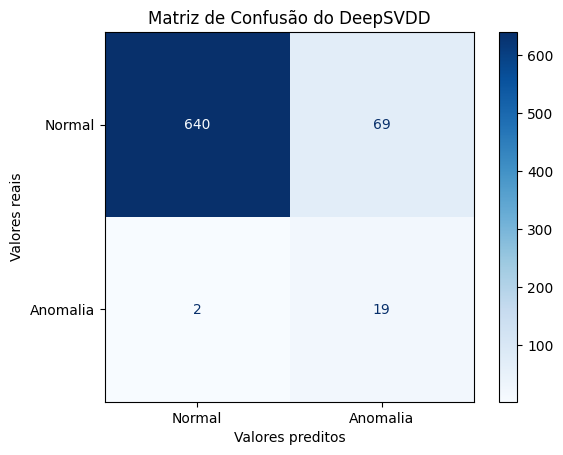

Acurácia=90,27
Precisão=21,59
Recall=90,48
F1=34,86
Falso Negativo=2
Falso Positivo=69
Verdadeiro Positivo=19


In [8]:
# Teste com só Robusta

grid_result = grid.fit(X_robust, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_robust)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' Robusta',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

 1/21 [>.............................] - ETA: 1s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1010"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_674 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_673 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_673 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_673 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 27333926.0000 - val_loss: 5894255.5000 - 69ms/epoch - 4ms/step
Epoch 67/100
19/19 - 0s - loss: 26571332.0000 - val_loss: 5842913.5000 - 73ms/epoch - 4ms/step
Epoch 68/100
19/19 - 0s - loss: 25550962.0000 - val_loss: 5811107.5000 - 63ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 24634806.0000 - val_loss: 5766759.5000 - 50ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 23979974.0000 - val_loss: 5678500.5000 - 42ms/epoch - 2ms/step
Epoch 71/100
19/19 - 0s - loss: 23067276.0000 - val_loss: 5617292.5000 - 71ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 22271808.0000 - val_loss: 5590052.5000 - 68ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 22720144.0000 - val_loss: 5569487.0000 - 69ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 21117760.0000 - val_loss: 5532242.5000 - 68ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 20260378.0000 - val_loss: 5489471.0000 - 74ms/epoch - 4ms/step
Epoch 76/100
19/19 - 0s - loss: 21655532.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1013"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_676 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_675 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_675 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_675 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 36637936.0000 - val_loss: 17711548.0000 - 54ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 35692176.0000 - val_loss: 17177402.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 35994184.0000 - val_loss: 17038072.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 33842036.0000 - val_loss: 16687499.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 32622636.0000 - val_loss: 16951394.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 31730382.0000 - val_loss: 16363827.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 31098884.0000 - val_loss: 16538219.0000 - 56ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 30079596.0000 - val_loss: 16025709.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 29391784.0000 - val_loss: 15951253.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 28748858.0000 - val_loss: 15899371.0000 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 28002508

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1016"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_678 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_677 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_677 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_677 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 22060954.0000 - val_loss: 8122612.0000 - 64ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 21223508.0000 - val_loss: 8098324.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 20596234.0000 - val_loss: 8077654.5000 - 56ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 19858574.0000 - val_loss: 8064912.0000 - 61ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 19284128.0000 - val_loss: 8046536.5000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 18790610.0000 - val_loss: 8043932.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 18055314.0000 - val_loss: 8039222.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 17571480.0000 - val_loss: 8009310.0000 - 65ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 25324640.0000 - val_loss: 7999809.5000 - 61ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 16403870.0000 - val_loss: 8004335.5000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 15617371.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 767us/step
Model: "model_1019"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_680 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_679 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_679 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_679 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

19/19 - 0s - loss: 13214258.0000 - val_loss: 4248039.5000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 12561429.0000 - val_loss: 4226838.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 12198332.0000 - val_loss: 4221146.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 11782173.0000 - val_loss: 4196088.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 11324974.0000 - val_loss: 4176053.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 10910473.0000 - val_loss: 4159205.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 10738824.0000 - val_loss: 4141344.7500 - 56ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 10382792.0000 - val_loss: 4138093.2500 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 9987708.0000 - val_loss: 4140924.2500 - 58ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 9622427.0000 - val_loss: 4138978.2500 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 9306959.0000 - val_loss: 4123247.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 993us/step
Model: "model_1022"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_682 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_681 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_681 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_681 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 26422868.0000 - val_loss: 5030635.5000 - 58ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 25611368.0000 - val_loss: 5041847.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 24504864.0000 - val_loss: 5041304.5000 - 51ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 23777784.0000 - val_loss: 5047386.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 22556728.0000 - val_loss: 5030475.0000 - 59ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 21818682.0000 - val_loss: 5034421.5000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 22262640.0000 - val_loss: 5041679.5000 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 20335710.0000 - val_loss: 5046948.0000 - 58ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 19553104.0000 - val_loss: 5047353.5000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 18733500.0000 - val_loss: 5030404.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 18920024.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1025"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_684 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_683 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_683 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_683 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 31738600.0000 - val_loss: 7125622.0000 - 54ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 31365124.0000 - val_loss: 7092967.5000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 30088602.0000 - val_loss: 7170090.5000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 29076026.0000 - val_loss: 7115249.5000 - 53ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 28342582.0000 - val_loss: 7069183.5000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 27386448.0000 - val_loss: 7061780.5000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 26587036.0000 - val_loss: 7023160.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 25799846.0000 - val_loss: 6980912.0000 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 25026772.0000 - val_loss: 6983982.5000 - 58ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 24546410.0000 - val_loss: 6950140.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 23615484.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 813us/step
Model: "model_1028"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_686 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_685 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_685 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_685 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 67/100
19/19 - 0s - loss: 6402404.5000 - val_loss: 5387781.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 5739286.5000 - val_loss: 5379989.5000 - 56ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 5585148.0000 - val_loss: 5361374.0000 - 56ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 5478883.0000 - val_loss: 5336445.5000 - 53ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 5724810.0000 - val_loss: 5340206.5000 - 52ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 5382225.5000 - val_loss: 5334918.5000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 5331368.5000 - val_loss: 5310699.5000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 5263033.5000 - val_loss: 5294233.5000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 5201219.5000 - val_loss: 5306502.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 5195196.5000 - val_loss: 5272161.5000 - 62ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 5093886.5000 - val_loss: 526

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 948us/step
Model: "model_1031"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_688 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_687 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_687 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_687 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

19/19 - 0s - loss: 39949516.0000 - val_loss: 24346370.0000 - 58ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 67813192.0000 - val_loss: 23948904.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 36544820.0000 - val_loss: 22839626.0000 - 57ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 35425212.0000 - val_loss: 21906590.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 33833960.0000 - val_loss: 21377456.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 56581416.0000 - val_loss: 21061354.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 31724830.0000 - val_loss: 19880570.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 29770906.0000 - val_loss: 19427490.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 28917878.0000 - val_loss: 19022382.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 28064416.0000 - val_loss: 18500522.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 27167394.0000 - val_l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 751us/step
Model: "model_1034"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_690 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_689 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_689 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_689 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

19/19 - 0s - loss: 41240904.0000 - val_loss: 24142320.0000 - 55ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 39824012.0000 - val_loss: 23674402.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 38774328.0000 - val_loss: 23015426.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 37699276.0000 - val_loss: 22363304.0000 - 52ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 36613416.0000 - val_loss: 21710842.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 35430316.0000 - val_loss: 21145590.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 34424588.0000 - val_loss: 20626528.0000 - 57ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 60158560.0000 - val_loss: 20333948.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 31838704.0000 - val_loss: 19266406.0000 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 30689506.0000 - val_loss: 18717368.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 29681606.0000 - val_l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_1037"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_692 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_691 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_691 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_691 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_691 (TFO  (None,)                  0

Epoch 66/100
19/19 - 0s - loss: 19677626.0000 - val_loss: 213581200.0000 - 59ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 19266364.0000 - val_loss: 207397456.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 19210662.0000 - val_loss: 206368768.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 21861912.0000 - val_loss: 198598080.0000 - 59ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 18820582.0000 - val_loss: 180152080.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 18499046.0000 - val_loss: 174508048.0000 - 59ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 18315790.0000 - val_loss: 170144240.0000 - 70ms/epoch - 4ms/step
Epoch 73/100
19/19 - 0s - loss: 17971970.0000 - val_loss: 165436528.0000 - 80ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 17880624.0000 - val_loss: 159589056.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 19932360.0000 - val_loss: 157318400.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1040"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_694 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_693 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_693 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_693 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 31834934.0000 - val_loss: 14506137.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 31218470.0000 - val_loss: 14442981.0000 - 56ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 30169448.0000 - val_loss: 14464085.0000 - 56ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 29685908.0000 - val_loss: 14514680.0000 - 59ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 28888966.0000 - val_loss: 14491885.0000 - 59ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 28414790.0000 - val_loss: 14471756.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 27607226.0000 - val_loss: 14491865.0000 - 56ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 27073350.0000 - val_loss: 14493299.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 27001114.0000 - val_loss: 14018525.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 25500346.0000 - val_loss: 13678420.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 24848012

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 903us/step
Model: "model_1043"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_696 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_695 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_695 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_695 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 22096538.0000 - val_loss: 9908572.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 21725038.0000 - val_loss: 9901508.0000 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 20757796.0000 - val_loss: 9897349.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 20357522.0000 - val_loss: 9907179.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 19713576.0000 - val_loss: 9896503.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 19207886.0000 - val_loss: 9884103.0000 - 62ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 19355514.0000 - val_loss: 9877472.0000 - 58ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 18131952.0000 - val_loss: 9868825.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 17655174.0000 - val_loss: 9871387.0000 - 57ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 17813874.0000 - val_loss: 9863845.0000 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 16742659.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1046"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_698 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_697 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_697 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_697 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 19874306.0000 - val_loss: 12681683.0000 - 65ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 19169864.0000 - val_loss: 12633153.0000 - 57ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 18804450.0000 - val_loss: 12607283.0000 - 57ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 18429786.0000 - val_loss: 12621444.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 17945478.0000 - val_loss: 12619497.0000 - 57ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 17437314.0000 - val_loss: 12571819.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 17192026.0000 - val_loss: 12556773.0000 - 64ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 16716955.0000 - val_loss: 12528831.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 16915618.0000 - val_loss: 12474515.0000 - 70ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 15961093.0000 - val_loss: 12521360.0000 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 15785300

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1049"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_700 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_699 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_699 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_699 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 47582080.0000 - val_loss: 12536304.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 46308448.0000 - val_loss: 12392003.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 45134368.0000 - val_loss: 12265325.0000 - 58ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 43847392.0000 - val_loss: 12146136.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 42846884.0000 - val_loss: 11996921.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 41970032.0000 - val_loss: 11820480.0000 - 56ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 40649504.0000 - val_loss: 11715073.0000 - 56ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 39405088.0000 - val_loss: 11592761.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 38421992.0000 - val_loss: 11429884.0000 - 57ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 37290316.0000 - val_loss: 11325584.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 36418060

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 852us/step
Model: "model_1052"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_702 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_701 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_701 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_701 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 7654032.0000 - val_loss: 4852516.5000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 7307842.5000 - val_loss: 4705039.5000 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 7059005.0000 - val_loss: 4581010.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 6791955.0000 - val_loss: 4425823.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 6453750.5000 - val_loss: 4359563.5000 - 53ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 6142574.5000 - val_loss: 4238722.5000 - 59ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 5932916.0000 - val_loss: 4158680.0000 - 58ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 5650172.0000 - val_loss: 4076850.7500 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 5481262.0000 - val_loss: 3978183.2500 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 5315813.0000 - val_loss: 3895411.2500 - 56ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 5139287.5000 - val_loss: 384

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1055"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_704 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_703 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_703 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_703 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 67/100
19/19 - 0s - loss: 12428735.0000 - val_loss: 4525846.5000 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 18391972.0000 - val_loss: 4534077.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 11508533.0000 - val_loss: 4513284.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 11054712.0000 - val_loss: 4444831.5000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 11275930.0000 - val_loss: 4474821.5000 - 62ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 10443735.0000 - val_loss: 4421374.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 10234020.0000 - val_loss: 4443293.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 9856407.0000 - val_loss: 4466736.5000 - 61ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 9654045.0000 - val_loss: 4412253.0000 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 9422589.0000 - val_loss: 4452937.0000 - 56ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 9129130.0000 - val_lo

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1058"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_706 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_705 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_705 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_705 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 67/100
19/19 - 0s - loss: 10691673.0000 - val_loss: 5266505.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 9717704.0000 - val_loss: 5289048.5000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 9526927.0000 - val_loss: 5278719.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 9344132.0000 - val_loss: 5256060.5000 - 65ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 9176131.0000 - val_loss: 5222170.0000 - 56ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 9044323.0000 - val_loss: 5210022.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 8942540.0000 - val_loss: 4982167.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 8597009.0000 - val_loss: 4801294.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 8404637.0000 - val_loss: 4768466.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 8329169.0000 - val_loss: 4775603.5000 - 59ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 8229128.5000 - val_loss: 47

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1061"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_708 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_707 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_707 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_707 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 65/100
19/19 - 0s - loss: 9820522.0000 - val_loss: 63605244.0000 - 60ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 9355869.0000 - val_loss: 60704608.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 9359973.0000 - val_loss: 57673888.0000 - 66ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 9000654.0000 - val_loss: 55790332.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 8862220.0000 - val_loss: 52378412.0000 - 61ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 8858116.0000 - val_loss: 49695676.0000 - 57ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 8560797.0000 - val_loss: 46954704.0000 - 58ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 8441438.0000 - val_loss: 44405268.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 8259318.0000 - val_loss: 42718056.0000 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 8643507.0000 - val_loss: 40481416.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 8055356.0000 - val

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1064"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_710 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_709 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_709 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_709 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 38803928.0000 - val_loss: 24660264.0000 - 64ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 37594116.0000 - val_loss: 23916502.0000 - 64ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 36266360.0000 - val_loss: 23376944.0000 - 65ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 61819040.0000 - val_loss: 22969328.0000 - 65ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 33680320.0000 - val_loss: 21881538.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 32414758.0000 - val_loss: 21304130.0000 - 62ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 31185344.0000 - val_loss: 20748408.0000 - 66ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 30229436.0000 - val_loss: 20224430.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 29147930.0000 - val_loss: 19955732.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 28570512.0000 - val_loss: 19389284.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 27541404

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1067"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_712 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_711 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_711 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_711 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 65/100
19/19 - 0s - loss: 85930384.0000 - val_loss: 16232816.0000 - 60ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 83974824.0000 - val_loss: 16006917.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 81845496.0000 - val_loss: 15883137.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 80388288.0000 - val_loss: 15666807.0000 - 62ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 78267584.0000 - val_loss: 15516601.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 76853696.0000 - val_loss: 15314480.0000 - 59ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 74764000.0000 - val_loss: 15213616.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 73173040.0000 - val_loss: 15105351.0000 - 56ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 71545920.0000 - val_loss: 14898661.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 70291384.0000 - val_loss: 14653364.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 68193640

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1070"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_714 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_713 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_713 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_713 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 12649893.0000 - val_loss: 7448926.0000 - 65ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 12065121.0000 - val_loss: 7385025.5000 - 66ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 11706968.0000 - val_loss: 7368747.5000 - 59ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 11442993.0000 - val_loss: 7317996.0000 - 65ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 11133852.0000 - val_loss: 7305418.5000 - 64ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 10863793.0000 - val_loss: 7306035.5000 - 61ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 10940156.0000 - val_loss: 7264825.5000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 10355090.0000 - val_loss: 7226756.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 10101571.0000 - val_loss: 7178690.5000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 9829688.0000 - val_loss: 7197130.0000 - 64ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 9746684.0000 - val_

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1073"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_716 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_715 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_715 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_715 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 59376296.0000 - val_loss: 6588449.5000 - 65ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 57286716.0000 - val_loss: 6601107.5000 - 61ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 55582668.0000 - val_loss: 6570314.5000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 53828896.0000 - val_loss: 6575568.5000 - 63ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 52367812.0000 - val_loss: 6557664.0000 - 44ms/epoch - 2ms/step
Epoch 71/100
19/19 - 0s - loss: 51370252.0000 - val_loss: 6547922.5000 - 45ms/epoch - 2ms/step
Epoch 72/100
19/19 - 0s - loss: 49357696.0000 - val_loss: 6525795.5000 - 61ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 47759372.0000 - val_loss: 6424554.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 46113288.0000 - val_loss: 6394690.5000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 44947396.0000 - val_loss: 6377808.0000 - 45ms/epoch - 2ms/step
Epoch 76/100
19/19 - 0s - loss: 43596236.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_1076"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_718 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_717 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_717 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_717 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 30459910.0000 - val_loss: 6087978.0000 - 64ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 29202054.0000 - val_loss: 6002556.0000 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 28390400.0000 - val_loss: 5929189.5000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 27503720.0000 - val_loss: 5850240.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 26454912.0000 - val_loss: 5762957.5000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 25561532.0000 - val_loss: 5692704.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 24759820.0000 - val_loss: 5640541.5000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 24154856.0000 - val_loss: 5566235.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 23237620.0000 - val_loss: 5524344.5000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 22441156.0000 - val_loss: 5455538.5000 - 56ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 21768494.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 982us/step
Model: "model_1079"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_720 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_719 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_719 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_719 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 33304508.0000 - val_loss: 14419296.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 32471258.0000 - val_loss: 14192624.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 31602202.0000 - val_loss: 13794108.0000 - 57ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 30898940.0000 - val_loss: 13604160.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 29867318.0000 - val_loss: 13581032.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 29123226.0000 - val_loss: 13200379.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 51685832.0000 - val_loss: 12820492.0000 - 58ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 27150406.0000 - val_loss: 12610467.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 26473400.0000 - val_loss: 12825569.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 25768620.0000 - val_loss: 11929867.0000 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 24892924

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 852us/step
Model: "model_1082"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_722 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_721 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_721 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_721 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 37586868.0000 - val_loss: 11676947.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 59049532.0000 - val_loss: 11353799.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 34822300.0000 - val_loss: 11011525.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 33512472.0000 - val_loss: 10833974.0000 - 65ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 32486444.0000 - val_loss: 10735370.0000 - 62ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 33482344.0000 - val_loss: 10595077.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 30502778.0000 - val_loss: 10523701.0000 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 30263710.0000 - val_loss: 10432585.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 29190114.0000 - val_loss: 10338823.0000 - 59ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 28269914.0000 - val_loss: 10273969.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 27629804

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1085"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_724 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_723 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_723 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_723 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 31489024.0000 - val_loss: 6307216.5000 - 58ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 30422336.0000 - val_loss: 6295681.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 29047940.0000 - val_loss: 6183360.5000 - 40ms/epoch - 2ms/step
Epoch 69/100
19/19 - 0s - loss: 28229812.0000 - val_loss: 6290131.5000 - 47ms/epoch - 2ms/step
Epoch 70/100
19/19 - 0s - loss: 27639146.0000 - val_loss: 6133122.0000 - 50ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 26160142.0000 - val_loss: 6271936.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 25330956.0000 - val_loss: 6211969.5000 - 90ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 24872786.0000 - val_loss: 6268866.0000 - 64ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 23603160.0000 - val_loss: 6147993.5000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 37586728.0000 - val_loss: 6201652.0000 - 54ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 23683546.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 981us/step
Model: "model_1088"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_726 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_725 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_725 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_725 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 67/100
19/19 - 0s - loss: 6410667.0000 - val_loss: 6425400.5000 - 65ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 6325971.0000 - val_loss: 6373014.5000 - 56ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 6305676.0000 - val_loss: 6388603.5000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 6197462.5000 - val_loss: 6356750.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 6131258.5000 - val_loss: 6360292.0000 - 56ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 6075639.0000 - val_loss: 6357267.5000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 6097162.5000 - val_loss: 6336540.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 6028681.5000 - val_loss: 6346586.5000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 6107179.0000 - val_loss: 6315577.5000 - 56ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 5915793.5000 - val_loss: 6331760.0000 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 6128805.0000 - val_loss: 631

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_1091"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_728 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_727 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_727 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_727 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_727 (TFO  (None,)                  0

19/19 - 0s - loss: 4676380.5000 - val_loss: 20715610.0000 - 52ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 4248129.5000 - val_loss: 20049482.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 4142628.7500 - val_loss: 18522504.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 4105558.7500 - val_loss: 16958234.0000 - 61ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 3961870.7500 - val_loss: 18483686.0000 - 54ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 3879543.5000 - val_loss: 15214323.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 3812821.5000 - val_loss: 16728125.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 3713943.5000 - val_loss: 12810387.0000 - 54ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 3655080.5000 - val_loss: 14178780.0000 - 58ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 3576379.7500 - val_loss: 15007768.0000 - 50ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 3499409.5000 - val_loss: 125930

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1094"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_730 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_729 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_729 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_729 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 47340360.0000 - val_loss: 7980397.5000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 45942708.0000 - val_loss: 7952396.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 45137632.0000 - val_loss: 7938425.5000 - 57ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 43741812.0000 - val_loss: 7928893.5000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 42994668.0000 - val_loss: 7893479.5000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 41754724.0000 - val_loss: 7912149.5000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 40773084.0000 - val_loss: 7895881.5000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 39706884.0000 - val_loss: 7901004.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 38414744.0000 - val_loss: 7886900.5000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 37911236.0000 - val_loss: 7875929.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 36503528.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_1097"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_732 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_731 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_731 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_731 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 33010236.0000 - val_loss: 14399435.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 33756572.0000 - val_loss: 14229200.0000 - 54ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 31097136.0000 - val_loss: 14056161.0000 - 58ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 30318720.0000 - val_loss: 13924984.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 29438030.0000 - val_loss: 13756288.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 28708602.0000 - val_loss: 13605971.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 29009394.0000 - val_loss: 13512173.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 27095910.0000 - val_loss: 13386279.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 26396310.0000 - val_loss: 13250968.0000 - 57ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 25871888.0000 - val_loss: 13101416.0000 - 54ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 26023054

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_734 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_733 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_733 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_733 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

19/19 - 0s - loss: 14279175.0000 - val_loss: 43562508.0000 - 50ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 14118739.0000 - val_loss: 41687948.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 14090907.0000 - val_loss: 39355012.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 13838367.0000 - val_loss: 37700336.0000 - 50ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 13698494.0000 - val_loss: 35692300.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 13595279.0000 - val_loss: 34692312.0000 - 57ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 13435121.0000 - val_loss: 33075920.0000 - 53ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13371078.0000 - val_loss: 31347206.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13244133.0000 - val_loss: 30041366.0000 - 51ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 13210115.0000 - val_loss: 30216342.0000 - 58ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 13001878.0000 - val_l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 761us/step
Model: "model_1103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_736 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_735 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_735 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_735 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 16062617.0000 - val_loss: 14222712.0000 - 56ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 15480054.0000 - val_loss: 13909400.0000 - 54ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 15103683.0000 - val_loss: 13679971.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 14868783.0000 - val_loss: 13403660.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 14292659.0000 - val_loss: 13156743.0000 - 54ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 13914227.0000 - val_loss: 12924488.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13743903.0000 - val_loss: 12763385.0000 - 50ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13292657.0000 - val_loss: 12553663.0000 - 56ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 13152733.0000 - val_loss: 12314187.0000 - 57ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12763725.0000 - val_loss: 12129984.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 12491432

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 760us/step
Model: "model_1106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_738 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_737 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_737 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_737 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 30184360.0000 - val_loss: 7478939.5000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 29299836.0000 - val_loss: 7481928.0000 - 51ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 28406248.0000 - val_loss: 7480455.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 27399054.0000 - val_loss: 7468034.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 26612740.0000 - val_loss: 7473700.0000 - 58ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 25709380.0000 - val_loss: 7476292.0000 - 50ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 24965070.0000 - val_loss: 7472508.5000 - 53ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 24287572.0000 - val_loss: 7468824.0000 - 51ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 23348428.0000 - val_loss: 7469168.0000 - 50ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 22821908.0000 - val_loss: 7461991.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 22060506.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 998us/step
Model: "model_1109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_740 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_739 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_739 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_739 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

19/19 - 0s - loss: 23367738.0000 - val_loss: 5208180.5000 - 51ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 22451382.0000 - val_loss: 5174134.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 21705138.0000 - val_loss: 5116217.5000 - 59ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 20799194.0000 - val_loss: 5096547.5000 - 50ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 20443062.0000 - val_loss: 5092161.5000 - 59ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 19586104.0000 - val_loss: 5083859.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 18939674.0000 - val_loss: 5068982.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 18093950.0000 - val_loss: 5069613.5000 - 50ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 17484312.0000 - val_loss: 5057662.5000 - 54ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 16813736.0000 - val_loss: 5048946.5000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 16465543.0000 - val_loss: 50550

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_742 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_741 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_741 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_741 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 40376324.0000 - val_loss: 9830627.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 37137416.0000 - val_loss: 9825016.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 35657452.0000 - val_loss: 9831820.0000 - 53ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 34924132.0000 - val_loss: 9794924.0000 - 54ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 33772928.0000 - val_loss: 9808741.0000 - 53ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 32806460.0000 - val_loss: 9810465.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 31695198.0000 - val_loss: 9764551.0000 - 56ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 31411066.0000 - val_loss: 9850581.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 30145678.0000 - val_loss: 9698137.0000 - 59ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 29308998.0000 - val_loss: 9808108.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 28430814.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 828us/step
Model: "model_1115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_744 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_743 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_743 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_743 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 27196986.0000 - val_loss: 5949477.5000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 26034832.0000 - val_loss: 5913727.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 25283644.0000 - val_loss: 5937414.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 24572984.0000 - val_loss: 5857532.0000 - 59ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 23828072.0000 - val_loss: 5896328.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 23120940.0000 - val_loss: 5820934.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 22455246.0000 - val_loss: 5839720.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 21748332.0000 - val_loss: 5820336.0000 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 21325634.0000 - val_loss: 5833574.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 20688646.0000 - val_loss: 5812043.5000 - 54ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 20086982.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_746 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_745 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_745 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_745 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 7721279.0000 - val_loss: 7702176.5000 - 56ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 7602406.0000 - val_loss: 7936729.5000 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 7510577.5000 - val_loss: 7919042.5000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 7424098.5000 - val_loss: 7654444.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 7313645.5000 - val_loss: 7706741.5000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 7223800.5000 - val_loss: 7584234.5000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 7653584.0000 - val_loss: 7454318.0000 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 7036522.0000 - val_loss: 7378269.5000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 6951909.0000 - val_loss: 7378389.5000 - 52ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 6931459.0000 - val_loss: 7379550.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 6826396.5000 - val_loss: 759

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 981us/step
Model: "model_1121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_748 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_747 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_747 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_747 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 32484584.0000 - val_loss: 13166019.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 31775872.0000 - val_loss: 12896741.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 51580544.0000 - val_loss: 12387000.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 28878154.0000 - val_loss: 12190008.0000 - 53ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 28265936.0000 - val_loss: 12033028.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 27234736.0000 - val_loss: 11739893.0000 - 50ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 26119622.0000 - val_loss: 11580432.0000 - 57ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 25345272.0000 - val_loss: 11490943.0000 - 61ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 24563620.0000 - val_loss: 11273735.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 23779164.0000 - val_loss: 11202341.0000 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 23009210

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 977us/step
Model: "model_1124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_750 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_749 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_749 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_749 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 20270182.0000 - val_loss: 9239117.0000 - 54ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 19822844.0000 - val_loss: 9225511.0000 - 57ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 19017794.0000 - val_loss: 9210604.0000 - 57ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 18572870.0000 - val_loss: 9204547.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 18376824.0000 - val_loss: 9194049.0000 - 54ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 17473360.0000 - val_loss: 9178052.0000 - 53ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 17573024.0000 - val_loss: 9170121.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 16601649.0000 - val_loss: 9160124.0000 - 52ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 16137359.0000 - val_loss: 9163358.0000 - 59ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 15698031.0000 - val_loss: 9137185.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 15357061.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_1127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_752 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_751 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_751 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_751 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 16288807.0000 - val_loss: 9040601.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 16073612.0000 - val_loss: 8783182.0000 - 56ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 15344977.0000 - val_loss: 8436212.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 14672515.0000 - val_loss: 8128872.0000 - 57ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 23875438.0000 - val_loss: 8016043.5000 - 59ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 13238395.0000 - val_loss: 7582654.5000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 12852855.0000 - val_loss: 7280076.0000 - 57ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 12195170.0000 - val_loss: 7138353.5000 - 56ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 11850820.0000 - val_loss: 6904458.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 11385816.0000 - val_loss: 6725626.5000 - 56ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 11113891.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_754 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_753 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_753 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_753 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 27282220.0000 - val_loss: 21345400.0000 - 76ms/epoch - 4ms/step
Epoch 67/100
19/19 - 0s - loss: 26297904.0000 - val_loss: 21119292.0000 - 85ms/epoch - 4ms/step
Epoch 68/100
19/19 - 0s - loss: 25865340.0000 - val_loss: 20540158.0000 - 71ms/epoch - 4ms/step
Epoch 69/100
19/19 - 0s - loss: 25117066.0000 - val_loss: 20134170.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 24449040.0000 - val_loss: 19751790.0000 - 65ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 23691216.0000 - val_loss: 19435240.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 22980806.0000 - val_loss: 19161990.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 22567998.0000 - val_loss: 18773368.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 21998722.0000 - val_loss: 18569730.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 21596580.0000 - val_loss: 18156690.0000 - 61ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 21013280

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 994us/step
Model: "model_1133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_756 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_755 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_755 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_755 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 20519160.0000 - val_loss: 17730650.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 20838784.0000 - val_loss: 17516078.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 19689958.0000 - val_loss: 17365206.0000 - 61ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 19111110.0000 - val_loss: 17114428.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 18796230.0000 - val_loss: 16946378.0000 - 50ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 18462554.0000 - val_loss: 16767283.0000 - 42ms/epoch - 2ms/step
Epoch 72/100
19/19 - 0s - loss: 18339406.0000 - val_loss: 16642185.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 18129230.0000 - val_loss: 16537408.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 17414250.0000 - val_loss: 16343560.0000 - 88ms/epoch - 5ms/step
Epoch 75/100
19/19 - 0s - loss: 17236028.0000 - val_loss: 16075885.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 16733802

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_758 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_757 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_757 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_757 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 45465904.0000 - val_loss: 7002129.5000 - 58ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 44356144.0000 - val_loss: 6977572.0000 - 61ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 42953460.0000 - val_loss: 6957536.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 42095476.0000 - val_loss: 6914093.5000 - 62ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 40769296.0000 - val_loss: 6899718.0000 - 61ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 39533004.0000 - val_loss: 6878314.5000 - 63ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 38807264.0000 - val_loss: 6843045.5000 - 58ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 37367396.0000 - val_loss: 6832300.0000 - 61ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 36599392.0000 - val_loss: 6801158.5000 - 65ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 35684116.0000 - val_loss: 6765619.5000 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 34555328.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_760 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_759 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_759 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_759 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

19/19 - 0s - loss: 16827200.0000 - val_loss: 3715960.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 16026168.0000 - val_loss: 3708924.0000 - 57ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 15516973.0000 - val_loss: 3704993.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 14861389.0000 - val_loss: 3703603.2500 - 62ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 14137610.0000 - val_loss: 3699572.2500 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 13587491.0000 - val_loss: 3690678.7500 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 12989875.0000 - val_loss: 3702001.0000 - 57ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 12716445.0000 - val_loss: 3696598.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 12052697.0000 - val_loss: 3692268.2500 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 11657186.0000 - val_loss: 3694615.2500 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 11177872.0000 - val_loss: 36858

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_762 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_761 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_761 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_761 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 65/100
19/19 - 0s - loss: 20079020.0000 - val_loss: 112326728.0000 - 56ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 19268474.0000 - val_loss: 109264168.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 18963344.0000 - val_loss: 102724312.0000 - 58ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 18138234.0000 - val_loss: 96544664.0000 - 61ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 17637366.0000 - val_loss: 92117280.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 17035368.0000 - val_loss: 89765248.0000 - 61ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 16745469.0000 - val_loss: 82904776.0000 - 61ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 16150171.0000 - val_loss: 79832160.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 15492637.0000 - val_loss: 74662936.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 15119667.0000 - val_loss: 71270616.0000 - 61ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 14641

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_764 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_763 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_763 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_763 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 3392227.7500 - val_loss: 13375749.0000 - 65ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 3363016.7500 - val_loss: 12429459.0000 - 65ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 3341758.0000 - val_loss: 11810432.0000 - 65ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 3307657.0000 - val_loss: 11119813.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 3304221.0000 - val_loss: 10424439.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 3269676.7500 - val_loss: 9909830.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 3267004.2500 - val_loss: 9418027.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 3215190.0000 - val_loss: 8880239.0000 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 3220936.7500 - val_loss: 8426457.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 3176881.5000 - val_loss: 8069979.5000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 3187550.7500 - val_loss

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_766 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_765 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_765 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_765 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 67/100
19/19 - 0s - loss: 7650474.0000 - val_loss: 2470119.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 7377172.0000 - val_loss: 2459187.7500 - 61ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 7174122.0000 - val_loss: 2464292.7500 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 6922607.5000 - val_loss: 2460746.7500 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 6647288.0000 - val_loss: 2449475.2500 - 65ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 6632298.0000 - val_loss: 2446727.2500 - 64ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 6427652.5000 - val_loss: 2438154.2500 - 63ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 6048246.5000 - val_loss: 2445557.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 5830505.5000 - val_loss: 2446018.5000 - 64ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 5668850.0000 - val_loss: 2432502.2500 - 63ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 5492486.5000 - val_loss: 243

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 993us/step
Model: "model_1151"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_768 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_767 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_767 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_767 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

19/19 - 0s - loss: 13713073.0000 - val_loss: 6436956.0000 - 59ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 13301746.0000 - val_loss: 6424706.0000 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 12849139.0000 - val_loss: 6418962.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 12442872.0000 - val_loss: 6418160.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 12059484.0000 - val_loss: 6412396.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 11655744.0000 - val_loss: 6401802.0000 - 57ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 11278024.0000 - val_loss: 6399245.5000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 10897184.0000 - val_loss: 6397809.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 10606235.0000 - val_loss: 6385545.5000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 10413987.0000 - val_loss: 6395174.0000 - 63ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 10281535.0000 - val_loss: 63852

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 980us/step
Model: "model_1154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_770 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_769 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_769 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_769 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 65/100
19/19 - 0s - loss: 11044244.0000 - val_loss: 82174992.0000 - 61ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 10891456.0000 - val_loss: 78647696.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 10746368.0000 - val_loss: 75933648.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 10570165.0000 - val_loss: 73116776.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 10461921.0000 - val_loss: 69391232.0000 - 65ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 10343329.0000 - val_loss: 66637952.0000 - 65ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 10178194.0000 - val_loss: 63895132.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 10059178.0000 - val_loss: 61499596.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 9864894.0000 - val_loss: 59086284.0000 - 56ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 9796106.0000 - val_loss: 56614928.0000 - 61ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 9759326.00

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 974us/step
Model: "model_1157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_772 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_771 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_771 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_771 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 38928164.0000 - val_loss: 4708382.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 37411856.0000 - val_loss: 4706415.5000 - 56ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 36473848.0000 - val_loss: 4704652.5000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 34981888.0000 - val_loss: 4700902.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 33662656.0000 - val_loss: 4697635.0000 - 61ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 32608004.0000 - val_loss: 4698476.0000 - 66ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 31833900.0000 - val_loss: 4689079.5000 - 64ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 30189854.0000 - val_loss: 4693777.5000 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 29545388.0000 - val_loss: 4690439.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 28145296.0000 - val_loss: 4684808.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 27227324.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_1160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_774 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_773 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_773 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_773 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_773 (TFO  (None,)                  0

19/19 - 0s - loss: 35309452.0000 - val_loss: 5610707.5000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 34224272.0000 - val_loss: 5486926.0000 - 67ms/epoch - 4ms/step
Epoch 68/100
19/19 - 0s - loss: 32810560.0000 - val_loss: 5432054.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 32053828.0000 - val_loss: 5334292.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 30724652.0000 - val_loss: 5236599.5000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 31561830.0000 - val_loss: 5145751.5000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 28656198.0000 - val_loss: 5059736.5000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 27482294.0000 - val_loss: 4987253.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 26684592.0000 - val_loss: 4888722.0000 - 59ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 25523766.0000 - val_loss: 4839784.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 25004910.0000 - val_loss: 47713

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 920us/step
Model: "model_1163"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_776 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_775 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_775 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_775 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

19/19 - 0s - loss: 8580102.0000 - val_loss: 52862208.0000 - 55ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 8507040.0000 - val_loss: 50361908.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 8398546.0000 - val_loss: 48692940.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 8265575.5000 - val_loss: 45994172.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 8172814.5000 - val_loss: 45332076.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 8042086.5000 - val_loss: 41118116.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 7938534.0000 - val_loss: 39027964.0000 - 56ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 7793000.5000 - val_loss: 38082368.0000 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 7726188.5000 - val_loss: 35070212.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 7649886.5000 - val_loss: 33838816.0000 - 64ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 7484667.0000 - val_loss: 321289

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 750us/step
Model: "model_1166"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_778 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_777 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_777 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_777 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

19/19 - 0s - loss: 9375789.0000 - val_loss: 44991044.0000 - 60ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 9453182.0000 - val_loss: 42337284.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 9023034.0000 - val_loss: 39549600.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 8864448.0000 - val_loss: 37186380.0000 - 59ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 8711406.0000 - val_loss: 35645516.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 8570623.0000 - val_loss: 33335784.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 8400305.0000 - val_loss: 31810898.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 8309020.5000 - val_loss: 29890656.0000 - 58ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 8179396.0000 - val_loss: 28056158.0000 - 65ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 8027596.0000 - val_loss: 27347104.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 7974030.5000 - val_loss: 254853

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 875us/step
Model: "model_1169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_780 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_779 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_779 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_779 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 27975152.0000 - val_loss: 7107336.0000 - 65ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 27252968.0000 - val_loss: 6980209.5000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 26279136.0000 - val_loss: 6819561.5000 - 57ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 26404268.0000 - val_loss: 6668185.5000 - 58ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 25126330.0000 - val_loss: 6648102.5000 - 53ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 24195952.0000 - val_loss: 6354933.5000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 23298378.0000 - val_loss: 6237258.0000 - 58ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 22542704.0000 - val_loss: 6073894.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 21926850.0000 - val_loss: 5956854.5000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 21242136.0000 - val_loss: 5977574.5000 - 54ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 20785406.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_782 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_781 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_781 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_781 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 16589976.0000 - val_loss: 5598305.5000 - 54ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 16105809.0000 - val_loss: 5580860.5000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 15515522.0000 - val_loss: 5551075.5000 - 56ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 15029846.0000 - val_loss: 5529042.5000 - 54ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 14448653.0000 - val_loss: 5503521.5000 - 57ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 13917930.0000 - val_loss: 5482284.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13822451.0000 - val_loss: 5464935.5000 - 53ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13168888.0000 - val_loss: 5436595.5000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 12601267.0000 - val_loss: 5432434.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12343363.0000 - val_loss: 5400630.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 11806168.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1175"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_784 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_783 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_783 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_783 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

19/19 - 0s - loss: 48040260.0000 - val_loss: 26204754.0000 - 53ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 90437760.0000 - val_loss: 25905720.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 45121728.0000 - val_loss: 24220906.0000 - 65ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 42615312.0000 - val_loss: 23424358.0000 - 65ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 40989600.0000 - val_loss: 22984328.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 39929052.0000 - val_loss: 22509074.0000 - 57ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 38993632.0000 - val_loss: 21668558.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 37906972.0000 - val_loss: 20934156.0000 - 58ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 36450144.0000 - val_loss: 20605520.0000 - 58ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 35697816.0000 - val_loss: 19863166.0000 - 50ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 34603632.0000 - val_l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_1178"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_786 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_785 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_785 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_785 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 67/100
19/19 - 0s - loss: 3920477.5000 - val_loss: 1720254.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 3803218.5000 - val_loss: 1716741.6250 - 53ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 3792269.5000 - val_loss: 1711362.8750 - 50ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 3552437.0000 - val_loss: 1706541.1250 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 3387699.0000 - val_loss: 1701395.6250 - 52ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 3304949.0000 - val_loss: 1699148.3750 - 50ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 3302135.2500 - val_loss: 1695108.6250 - 52ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 3080531.7500 - val_loss: 1691352.6250 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 3000184.5000 - val_loss: 1689696.3750 - 57ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 2885041.7500 - val_loss: 1683283.0000 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 3134613.7500 - val_loss: 168

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 923us/step
Model: "model_1181"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_788 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_787 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_787 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_787 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 17763182.0000 - val_loss: 5106297.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 17141518.0000 - val_loss: 5029021.5000 - 54ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 16504369.0000 - val_loss: 5009783.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 24762458.0000 - val_loss: 4988445.5000 - 58ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 15106440.0000 - val_loss: 4963696.5000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 14481165.0000 - val_loss: 4948928.5000 - 52ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 14031876.0000 - val_loss: 4934789.5000 - 50ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13606566.0000 - val_loss: 4931370.0000 - 57ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 13311218.0000 - val_loss: 4894393.5000 - 57ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 13011308.0000 - val_loss: 4872866.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 12627392.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 748us/step
Model: "model_1184"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_790 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_789 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_789 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_789 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 17246400.0000 - val_loss: 11515483.0000 - 53ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 16700502.0000 - val_loss: 11266427.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 16251714.0000 - val_loss: 11079739.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 15766117.0000 - val_loss: 10855345.0000 - 52ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 15228111.0000 - val_loss: 10666930.0000 - 53ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 14842590.0000 - val_loss: 10531603.0000 - 50ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 14617922.0000 - val_loss: 10361275.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 14150981.0000 - val_loss: 10175012.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 13927539.0000 - val_loss: 9981219.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 13547856.0000 - val_loss: 9795952.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 13172082.0

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 996us/step
Model: "model_1187"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_792 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_791 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_791 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_791 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 46367692.0000 - val_loss: 15293308.0000 - 56ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 25921034.0000 - val_loss: 14495415.0000 - 58ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 25025144.0000 - val_loss: 13854275.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 23975288.0000 - val_loss: 13457847.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 23146932.0000 - val_loss: 13144500.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 23812222.0000 - val_loss: 12800156.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 21872188.0000 - val_loss: 12383783.0000 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 21069950.0000 - val_loss: 12059388.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 33419622.0000 - val_loss: 11791020.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 31505840.0000 - val_loss: 11326992.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 18413480

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_1190"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_794 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_793 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_793 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_793 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 18203410.0000 - val_loss: 6630185.5000 - 53ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 17370200.0000 - val_loss: 6572305.5000 - 53ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 16836744.0000 - val_loss: 6501984.5000 - 50ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 16142745.0000 - val_loss: 6473405.5000 - 53ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 15545214.0000 - val_loss: 6425442.5000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 15014343.0000 - val_loss: 6387649.5000 - 53ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 14439141.0000 - val_loss: 6333582.5000 - 50ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13796765.0000 - val_loss: 6312235.5000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 13407842.0000 - val_loss: 6269116.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12962388.0000 - val_loss: 6237952.5000 - 49ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 12506437.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 751us/step
Model: "model_1193"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_796 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_795 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_795 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_795 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 65/100
19/19 - 0s - loss: 12968038.0000 - val_loss: 45619468.0000 - 55ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 12799780.0000 - val_loss: 43195200.0000 - 56ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 12717906.0000 - val_loss: 41432408.0000 - 58ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 12504317.0000 - val_loss: 40197136.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 12773511.0000 - val_loss: 38351076.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 12354807.0000 - val_loss: 35268136.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 12145896.0000 - val_loss: 34227168.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 12076972.0000 - val_loss: 32544858.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 11954552.0000 - val_loss: 31491720.0000 - 51ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 11830952.0000 - val_loss: 30422560.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12072893

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 991us/step
Model: "model_1196"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_798 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_797 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_797 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_797 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 12029581.0000 - val_loss: 5181650.5000 - 54ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 11510514.0000 - val_loss: 5064608.0000 - 58ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 10982700.0000 - val_loss: 4988650.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 10391941.0000 - val_loss: 4903750.5000 - 51ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 10372337.0000 - val_loss: 4810972.5000 - 56ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 9583124.0000 - val_loss: 4720254.5000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 9076556.0000 - val_loss: 4656668.5000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 8674838.0000 - val_loss: 4598906.5000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 8439215.0000 - val_loss: 4501537.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 7881416.5000 - val_loss: 4379885.5000 - 56ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 7530822.0000 - val_loss

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_800 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_799 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_799 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_799 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 65/100
19/19 - 0s - loss: 68309448.0000 - val_loss: 23052354.0000 - 55ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 66942632.0000 - val_loss: 22388208.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 65848840.0000 - val_loss: 22094076.0000 - 52ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 64310548.0000 - val_loss: 21520708.0000 - 58ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 119139304.0000 - val_loss: 20409886.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 60199436.0000 - val_loss: 20169456.0000 - 52ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 58260636.0000 - val_loss: 19682454.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 56901552.0000 - val_loss: 19196334.0000 - 54ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 55318540.0000 - val_loss: 18579976.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 60265648.0000 - val_loss: 20867242.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 5364136

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 942us/step
Model: "model_1202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_802 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_801 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_801 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_801 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 16592862.0000 - val_loss: 8458111.0000 - 58ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 16191887.0000 - val_loss: 8522449.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 15507429.0000 - val_loss: 8496868.0000 - 56ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 14936275.0000 - val_loss: 8483869.0000 - 62ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 14410250.0000 - val_loss: 8476239.0000 - 99ms/epoch - 5ms/step
Epoch 71/100
19/19 - 0s - loss: 14047106.0000 - val_loss: 8465692.0000 - 58ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13532802.0000 - val_loss: 8470650.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13771373.0000 - val_loss: 8453188.0000 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 12837138.0000 - val_loss: 8457606.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12364741.0000 - val_loss: 8423689.0000 - 63ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 12198858.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 867us/step
Model: "model_1205"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_804 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_803 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_803 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_803 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 67/100
19/19 - 0s - loss: 13857555.0000 - val_loss: 2208556.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 7843162.0000 - val_loss: 2202165.2500 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 7222800.0000 - val_loss: 2201249.2500 - 52ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 6907955.5000 - val_loss: 2203192.2500 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 6562860.0000 - val_loss: 2202168.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 6427903.0000 - val_loss: 2200147.7500 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 6082143.0000 - val_loss: 2196890.2500 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 5774817.5000 - val_loss: 2193442.7500 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 5683406.0000 - val_loss: 2190872.5000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 5389625.5000 - val_loss: 2199213.2500 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 5136417.5000 - val_loss: 21

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 946us/step
Model: "model_1208"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_806 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_805 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_805 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_805 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 67/100
19/19 - 0s - loss: 7647716.0000 - val_loss: 4463251.5000 - 63ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 8757744.0000 - val_loss: 4451744.5000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 7195937.5000 - val_loss: 4466877.5000 - 65ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 7078167.5000 - val_loss: 4467105.5000 - 64ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 6919109.0000 - val_loss: 4461684.5000 - 61ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 6797646.0000 - val_loss: 4440160.5000 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 6699642.0000 - val_loss: 4480816.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 6565433.0000 - val_loss: 4465786.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 6458948.0000 - val_loss: 4462950.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 6384444.0000 - val_loss: 4454422.0000 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 6228703.5000 - val_loss: 444

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1211"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_808 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_807 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_807 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_807 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

19/19 - 0s - loss: 16068520.0000 - val_loss: 6159594.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 15618447.0000 - val_loss: 6181445.5000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 15154698.0000 - val_loss: 6176286.5000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 14617649.0000 - val_loss: 6170910.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 14037593.0000 - val_loss: 6151544.0000 - 59ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 13658846.0000 - val_loss: 6104241.5000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13219699.0000 - val_loss: 6080758.5000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 12757424.0000 - val_loss: 6120510.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 12558069.0000 - val_loss: 6081454.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12062911.0000 - val_loss: 6101680.5000 - 61ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 11885983.0000 - val_loss: 61779

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1214"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_810 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_809 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_809 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_809 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 65/100
19/19 - 0s - loss: 2746978.7500 - val_loss: 460102752.0000 - 60ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 2723135.0000 - val_loss: 440085216.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 2709309.7500 - val_loss: 454669536.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 2665198.2500 - val_loss: 410692640.0000 - 65ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 2676277.2500 - val_loss: 380909856.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 2655922.5000 - val_loss: 375283616.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 2622959.7500 - val_loss: 345306368.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 2627640.0000 - val_loss: 321562176.0000 - 64ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 2617849.2500 - val_loss: 327037376.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 2608598.7500 - val_loss: 292604384.0000 - 58ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 2642921.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 993us/step
Model: "model_1217"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_812 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_811 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_811 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_811 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 26801126.0000 - val_loss: 5819314.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 26113132.0000 - val_loss: 5806662.5000 - 58ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 24623522.0000 - val_loss: 5803676.5000 - 64ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 24017406.0000 - val_loss: 5781597.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 23157640.0000 - val_loss: 5760849.5000 - 65ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 21932244.0000 - val_loss: 5773372.0000 - 65ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 20986116.0000 - val_loss: 5752492.0000 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 20341156.0000 - val_loss: 5756262.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 19469390.0000 - val_loss: 5737164.0000 - 61ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 18838824.0000 - val_loss: 5740888.0000 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 18093342.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1220"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_814 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_813 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_813 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_813 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 21600730.0000 - val_loss: 12108063.0000 - 62ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 21052738.0000 - val_loss: 11915387.0000 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 20546046.0000 - val_loss: 11625117.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 20122820.0000 - val_loss: 11487465.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 19697922.0000 - val_loss: 11257192.0000 - 59ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 19182896.0000 - val_loss: 11110257.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 18963922.0000 - val_loss: 10883150.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 18600856.0000 - val_loss: 10717877.0000 - 65ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 18166174.0000 - val_loss: 10579053.0000 - 54ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 17896858.0000 - val_loss: 10401101.0000 - 57ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 17593944

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 975us/step
Model: "model_1223"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_816 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_815 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_815 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_815 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 13383581.0000 - val_loss: 11351664.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 13082779.0000 - val_loss: 10889495.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 13049427.0000 - val_loss: 10479173.0000 - 65ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 12307333.0000 - val_loss: 10143125.0000 - 62ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 11964904.0000 - val_loss: 9825563.0000 - 58ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 11964243.0000 - val_loss: 9663966.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 11469027.0000 - val_loss: 9350338.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 11141117.0000 - val_loss: 9096674.0000 - 61ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 10739763.0000 - val_loss: 8788775.0000 - 59ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 10491494.0000 - val_loss: 8498129.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 10297809.0000 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1226"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_818 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_817 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_817 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_817 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 65/100
19/19 - 0s - loss: 14637359.0000 - val_loss: 55165184.0000 - 61ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 14589145.0000 - val_loss: 56657984.0000 - 63ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 14302675.0000 - val_loss: 71199024.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 13675437.0000 - val_loss: 45593420.0000 - 64ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 13355539.0000 - val_loss: 43523444.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 13265307.0000 - val_loss: 43025860.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 12879446.0000 - val_loss: 41627872.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 12547507.0000 - val_loss: 38290292.0000 - 61ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 12504596.0000 - val_loss: 37156080.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 12375909.0000 - val_loss: 35181236.0000 - 66ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12328872

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1229"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_820 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_819 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_819 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_819 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 43178428.0000 - val_loss: 13286543.0000 - 61ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 41634780.0000 - val_loss: 13267032.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 40874288.0000 - val_loss: 13206660.0000 - 62ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 39713932.0000 - val_loss: 13213069.0000 - 65ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 39506680.0000 - val_loss: 13149635.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 37912788.0000 - val_loss: 13200148.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 37159564.0000 - val_loss: 13089125.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 36185516.0000 - val_loss: 13076036.0000 - 65ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 35296588.0000 - val_loss: 13041239.0000 - 61ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 34585760.0000 - val_loss: 12993459.0000 - 65ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 33552462

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 934us/step
Model: "model_1232"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_822 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_821 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_821 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_821 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 39558372.0000 - val_loss: 5761226.5000 - 59ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 36775508.0000 - val_loss: 5753402.0000 - 45ms/epoch - 2ms/step
Epoch 68/100
19/19 - 0s - loss: 35714232.0000 - val_loss: 5670691.5000 - 50ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 34686748.0000 - val_loss: 5623696.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 33666420.0000 - val_loss: 5580889.5000 - 56ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 32552964.0000 - val_loss: 5513715.5000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 31799960.0000 - val_loss: 5459446.0000 - 51ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 30691682.0000 - val_loss: 5414859.5000 - 50ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 31768458.0000 - val_loss: 5397312.5000 - 45ms/epoch - 2ms/step
Epoch 75/100
19/19 - 0s - loss: 29100264.0000 - val_loss: 5341877.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 27978676.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_1235"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_824 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_823 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_823 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_823 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

19/19 - 0s - loss: 7869295.0000 - val_loss: 55137604.0000 - 55ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 7663628.5000 - val_loss: 53017680.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 7644179.5000 - val_loss: 49844896.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 7562172.0000 - val_loss: 48485488.0000 - 61ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 7437358.5000 - val_loss: 46372996.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 7447621.0000 - val_loss: 42710364.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 7278592.0000 - val_loss: 41609420.0000 - 64ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 7225664.0000 - val_loss: 38969724.0000 - 63ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 7347318.0000 - val_loss: 39711268.0000 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 7133934.5000 - val_loss: 37046344.0000 - 59ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 7074371.5000 - val_loss: 345946

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 979us/step
Model: "model_1238"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_826 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_825 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_825 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_825 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 67/100
19/19 - 0s - loss: 5918894.5000 - val_loss: 3950421.2500 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 5821317.5000 - val_loss: 3925947.0000 - 58ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 5647766.0000 - val_loss: 3920915.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 5985410.5000 - val_loss: 3908619.2500 - 57ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 5459611.0000 - val_loss: 3891509.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 5309328.5000 - val_loss: 3896230.7500 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 5247364.0000 - val_loss: 3871631.2500 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 5571739.0000 - val_loss: 3884946.7500 - 62ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 5060100.0000 - val_loss: 3878028.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 5272678.5000 - val_loss: 3885642.7500 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 4880851.0000 - val_loss: 386

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1241"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_828 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_827 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_827 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_827 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 29340338.0000 - val_loss: 8778396.0000 - 64ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 28356560.0000 - val_loss: 8726251.0000 - 75ms/epoch - 4ms/step
Epoch 68/100
19/19 - 0s - loss: 27254768.0000 - val_loss: 8671875.0000 - 65ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 26445018.0000 - val_loss: 8652251.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 27109334.0000 - val_loss: 8639177.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 24899316.0000 - val_loss: 8625352.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 24125250.0000 - val_loss: 8620973.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 23385202.0000 - val_loss: 8606013.0000 - 64ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 22670554.0000 - val_loss: 8591400.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 22043472.0000 - val_loss: 8574286.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 21294534.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 979us/step
Model: "model_1244"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_830 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_829 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_829 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_829 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 45787980.0000 - val_loss: 9275837.0000 - 56ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 44313300.0000 - val_loss: 9102392.0000 - 57ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 42175136.0000 - val_loss: 8958230.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 40624148.0000 - val_loss: 8779905.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 39094860.0000 - val_loss: 8656828.0000 - 57ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 37745964.0000 - val_loss: 8532527.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 36439028.0000 - val_loss: 8405535.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 35247136.0000 - val_loss: 8254646.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 33860056.0000 - val_loss: 8097817.5000 - 56ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 32546782.0000 - val_loss: 7977313.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 31265516.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1247"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_832 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_831 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_831 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_831 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 79348296.0000 - val_loss: 16376755.0000 - 58ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 48090628.0000 - val_loss: 16382309.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 46524108.0000 - val_loss: 16349529.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 46551320.0000 - val_loss: 16304015.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 44655564.0000 - val_loss: 16368683.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 43954104.0000 - val_loss: 16355059.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 43173088.0000 - val_loss: 16298475.0000 - 56ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 42729100.0000 - val_loss: 16307056.0000 - 56ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 41517992.0000 - val_loss: 16318283.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 40601676.0000 - val_loss: 16301116.0000 - 56ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 39890540

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1250"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_834 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_833 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_833 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_833 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 22782062.0000 - val_loss: 11698032.0000 - 58ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 22281780.0000 - val_loss: 11622899.0000 - 53ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 21525104.0000 - val_loss: 11567705.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 21057486.0000 - val_loss: 11513727.0000 - 52ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 20455210.0000 - val_loss: 11474831.0000 - 53ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 20096370.0000 - val_loss: 11387021.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 19437370.0000 - val_loss: 11323784.0000 - 52ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 19127380.0000 - val_loss: 11305656.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 18478002.0000 - val_loss: 11284739.0000 - 58ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 18212180.0000 - val_loss: 11235819.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 17678262

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1253"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_836 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_835 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_835 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_835 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 25708606.0000 - val_loss: 5593198.5000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 24989670.0000 - val_loss: 5594697.5000 - 51ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 23983686.0000 - val_loss: 5579596.5000 - 53ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 23419212.0000 - val_loss: 5552978.5000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 24900292.0000 - val_loss: 5534117.0000 - 52ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 21810032.0000 - val_loss: 5520768.5000 - 51ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 20852424.0000 - val_loss: 5518959.5000 - 57ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 20522420.0000 - val_loss: 5508554.0000 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 19826828.0000 - val_loss: 5506632.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 19401048.0000 - val_loss: 5495962.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 19801564.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 882us/step
Model: "model_1256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_838 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_837 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_837 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_837 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 23904538.0000 - val_loss: 5273810.5000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 23210118.0000 - val_loss: 5271073.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 22120940.0000 - val_loss: 5271938.0000 - 59ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 21375352.0000 - val_loss: 5268026.0000 - 50ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 20644090.0000 - val_loss: 5262373.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 19837472.0000 - val_loss: 5260533.0000 - 53ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 19244216.0000 - val_loss: 5256818.5000 - 52ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 18445588.0000 - val_loss: 5252238.5000 - 56ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 18197320.0000 - val_loss: 5238730.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 17255768.0000 - val_loss: 5258546.0000 - 58ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 16761487.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_1259"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_840 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_839 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_839 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_839 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_839 (TFO  (None,)                  0

Epoch 67/100
19/19 - 0s - loss: 25050862.0000 - val_loss: 4607572.5000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 23906458.0000 - val_loss: 4628553.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 41890856.0000 - val_loss: 4588701.5000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 21789742.0000 - val_loss: 4605934.5000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 21203180.0000 - val_loss: 4595773.0000 - 50ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 20133810.0000 - val_loss: 4597447.5000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 19455586.0000 - val_loss: 4578820.0000 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 19129246.0000 - val_loss: 4583407.5000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 18593958.0000 - val_loss: 4567971.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 17666728.0000 - val_loss: 4586445.5000 - 59ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 17045104.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_1262"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_842 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_841 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_841 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_841 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

19/19 - 0s - loss: 24200020.0000 - val_loss: 5140253.5000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 23435988.0000 - val_loss: 5125068.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 22506646.0000 - val_loss: 5125168.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 21663522.0000 - val_loss: 5115868.0000 - 51ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 21260916.0000 - val_loss: 5115823.5000 - 56ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 20285906.0000 - val_loss: 5108580.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 19709728.0000 - val_loss: 5099765.5000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 18976044.0000 - val_loss: 5103254.5000 - 53ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 19257114.0000 - val_loss: 5087685.0000 - 50ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 17828140.0000 - val_loss: 5114122.5000 - 57ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 18196724.0000 - val_loss: 51047

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_1265"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_844 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_843 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_843 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_843 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 20493720.0000 - val_loss: 3934860.7500 - 58ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 19610096.0000 - val_loss: 3722004.7500 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 18867904.0000 - val_loss: 3553918.2500 - 58ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 17574730.0000 - val_loss: 3637229.2500 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 16954696.0000 - val_loss: 3357600.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 16089509.0000 - val_loss: 3249312.7500 - 61ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 15327121.0000 - val_loss: 3239046.7500 - 64ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 16019045.0000 - val_loss: 3306118.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 14058937.0000 - val_loss: 3186370.7500 - 62ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 13592627.0000 - val_loss: 3199645.2500 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 13151265.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_1268"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_846 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_845 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_845 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_845 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 11524927.0000 - val_loss: 10462057.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 11260062.0000 - val_loss: 10228405.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 12968403.0000 - val_loss: 10057020.0000 - 56ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 10745485.0000 - val_loss: 9789366.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 11703646.0000 - val_loss: 9567062.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 10073879.0000 - val_loss: 9330091.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 9860000.0000 - val_loss: 9069691.0000 - 57ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 9561661.0000 - val_loss: 8926997.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 9258376.0000 - val_loss: 8726027.0000 - 52ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 9097903.0000 - val_loss: 8562473.0000 - 50ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 8988311.0000 - val_

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1000us/step
Model: "model_1271"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_848 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_847 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_847 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_847 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 


Epoch 66/100
19/19 - 0s - loss: 14197703.0000 - val_loss: 5890646.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 13735846.0000 - val_loss: 5797560.0000 - 54ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 13377453.0000 - val_loss: 5885107.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 12693980.0000 - val_loss: 5829677.5000 - 56ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 12216782.0000 - val_loss: 5820871.5000 - 51ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 11648141.0000 - val_loss: 5811972.0000 - 53ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 11175881.0000 - val_loss: 5768070.0000 - 50ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 11272427.0000 - val_loss: 5783394.5000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 10447757.0000 - val_loss: 5770350.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 10007798.0000 - val_loss: 5754018.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 9715270.0000 - val

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1274"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_850 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_849 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_849 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_849 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 31680360.0000 - val_loss: 15385743.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 31053444.0000 - val_loss: 15328245.0000 - 53ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 30186958.0000 - val_loss: 15193337.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 29584216.0000 - val_loss: 15092121.0000 - 59ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 28779052.0000 - val_loss: 15079775.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 28325434.0000 - val_loss: 15064872.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 27715208.0000 - val_loss: 15024880.0000 - 57ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 27352696.0000 - val_loss: 15036948.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 26543286.0000 - val_loss: 15014963.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 25915878.0000 - val_loss: 14995316.0000 - 57ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 34688708

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 877us/step
Model: "model_1277"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_852 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_851 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_851 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_851 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 22677466.0000 - val_loss: 13511145.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 21826246.0000 - val_loss: 13291921.0000 - 50ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 21326486.0000 - val_loss: 12916427.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 20593498.0000 - val_loss: 12632529.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 20176974.0000 - val_loss: 12295803.0000 - 54ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 19295664.0000 - val_loss: 12146567.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 18783678.0000 - val_loss: 11878803.0000 - 53ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 18171194.0000 - val_loss: 11594989.0000 - 50ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 17740870.0000 - val_loss: 11275244.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 17059760.0000 - val_loss: 11075167.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 16575096

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_1280"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_854 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_853 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_853 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_853 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_853 (TFO  (None,)                  0

Epoch 67/100
19/19 - 0s - loss: 15763247.0000 - val_loss: 7411263.5000 - 56ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 15194835.0000 - val_loss: 7396010.5000 - 56ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 14835633.0000 - val_loss: 7365552.0000 - 59ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 14452192.0000 - val_loss: 7345068.5000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 13830442.0000 - val_loss: 7317449.5000 - 56ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13539592.0000 - val_loss: 7314097.5000 - 54ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13056334.0000 - val_loss: 7293670.5000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 12790329.0000 - val_loss: 7276656.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12386337.0000 - val_loss: 7253682.5000 - 56ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 12041447.0000 - val_loss: 7244928.5000 - 56ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 11758290.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 964us/step
Model: "model_1283"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_856 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_855 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_855 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_855 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 48930936.0000 - val_loss: 16999056.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 49741300.0000 - val_loss: 16764851.0000 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 46593016.0000 - val_loss: 16773304.0000 - 59ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 45275700.0000 - val_loss: 16520253.0000 - 58ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 44017004.0000 - val_loss: 16458848.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 45989492.0000 - val_loss: 16319093.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 41791088.0000 - val_loss: 16272828.0000 - 56ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 40605524.0000 - val_loss: 16152116.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 39613400.0000 - val_loss: 16076424.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 38672424.0000 - val_loss: 15890293.0000 - 63ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 37765360

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 925us/step
Model: "model_1286"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_858 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_857 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_857 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_857 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 31667254.0000 - val_loss: 9872497.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 30546768.0000 - val_loss: 9843793.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 29834010.0000 - val_loss: 9786576.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 28778574.0000 - val_loss: 9785495.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 44018020.0000 - val_loss: 9761461.0000 - 56ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 26755250.0000 - val_loss: 9740559.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 27116368.0000 - val_loss: 9703648.0000 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 25128614.0000 - val_loss: 9658606.0000 - 58ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 24473490.0000 - val_loss: 9618335.0000 - 81ms/epoch - 4ms/step
Epoch 75/100
19/19 - 0s - loss: 23713808.0000 - val_loss: 9611052.0000 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 23074590.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 998us/step
Model: "model_1289"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_860 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_859 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_859 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_859 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

19/19 - 0s - loss: 21613058.0000 - val_loss: 4505340.0000 - 61ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 21004816.0000 - val_loss: 4496906.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 20295002.0000 - val_loss: 4484676.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 20337220.0000 - val_loss: 4471080.5000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 18914202.0000 - val_loss: 4468663.5000 - 59ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 18139318.0000 - val_loss: 4466995.0000 - 54ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 17565964.0000 - val_loss: 4449044.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 16922720.0000 - val_loss: 4493535.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 16547857.0000 - val_loss: 4485741.5000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 15760244.0000 - val_loss: 4440492.0000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 15264691.0000 - val_loss: 44417

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_1292"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_862 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_861 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_861 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_861 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 13232431.0000 - val_loss: 4660597.5000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 12804877.0000 - val_loss: 4648268.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 12328123.0000 - val_loss: 4631264.5000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 11849207.0000 - val_loss: 4613500.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 11734401.0000 - val_loss: 4613736.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 11120552.0000 - val_loss: 4601323.5000 - 56ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 10861663.0000 - val_loss: 4580171.5000 - 57ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 10591073.0000 - val_loss: 4578126.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 10178866.0000 - val_loss: 4571591.5000 - 54ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 9880244.0000 - val_loss: 4543938.5000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 9562949.0000 - val_

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_1295"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_864 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_863 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_863 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_863 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 67/100
19/19 - 0s - loss: 17062854.0000 - val_loss: 7191326.0000 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 15912977.0000 - val_loss: 7142902.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 15487111.0000 - val_loss: 7053722.5000 - 65ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 15089214.0000 - val_loss: 7051737.5000 - 57ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 14808488.0000 - val_loss: 7105325.5000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 14285718.0000 - val_loss: 7057508.0000 - 57ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 14083010.0000 - val_loss: 7044796.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 13827805.0000 - val_loss: 7052184.5000 - 57ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 19034832.0000 - val_loss: 7018430.5000 - 58ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 12936989.0000 - val_loss: 7036332.5000 - 60ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 13037560.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_1298"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_866 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_865 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_865 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_865 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 65/100
19/19 - 0s - loss: 6966999.0000 - val_loss: 135444912.0000 - 61ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 6852985.5000 - val_loss: 130666520.0000 - 65ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 6714979.5000 - val_loss: 124437512.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 7923204.0000 - val_loss: 120357152.0000 - 64ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 6797403.0000 - val_loss: 110550984.0000 - 58ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 6519484.0000 - val_loss: 103971080.0000 - 56ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 6388998.5000 - val_loss: 97543104.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 6301148.0000 - val_loss: 93673256.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 6256200.0000 - val_loss: 88953280.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 6166870.5000 - val_loss: 84732432.0000 - 57ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 6108832.5000

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1301"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_868 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_867 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_867 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_867 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

19/19 - 0s - loss: 20884588.0000 - val_loss: 7908041.5000 - 58ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 19998006.0000 - val_loss: 7901694.5000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 19631738.0000 - val_loss: 7905346.0000 - 65ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 18881520.0000 - val_loss: 7900678.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 18149242.0000 - val_loss: 7909752.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 17661904.0000 - val_loss: 7906397.5000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 17131422.0000 - val_loss: 7908665.5000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 16493629.0000 - val_loss: 7913589.5000 - 61ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 16127955.0000 - val_loss: 7925232.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 15591800.0000 - val_loss: 7918881.5000 - 61ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 15104283.0000 - val_loss: 79269

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1304"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_870 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_869 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_869 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_869 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

19/19 - 0s - loss: 34601952.0000 - val_loss: 21873918.0000 - 59ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 33332456.0000 - val_loss: 21004854.0000 - 64ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 31800656.0000 - val_loss: 20284646.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 30824384.0000 - val_loss: 19666720.0000 - 65ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 29581306.0000 - val_loss: 19129518.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 28650610.0000 - val_loss: 18659480.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 27681328.0000 - val_loss: 18276818.0000 - 58ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 42838836.0000 - val_loss: 18014496.0000 - 62ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 25946846.0000 - val_loss: 17101558.0000 - 61ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 24498390.0000 - val_loss: 16683200.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 23666154.0000 - val_l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1307"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_872 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_871 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_871 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_871 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 18428876.0000 - val_loss: 7203963.5000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 17729220.0000 - val_loss: 7190572.5000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 17186488.0000 - val_loss: 7179460.5000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 16782868.0000 - val_loss: 7176048.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 16363837.0000 - val_loss: 7166636.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 15754355.0000 - val_loss: 7168604.5000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 15783318.0000 - val_loss: 7167046.0000 - 65ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 14792015.0000 - val_loss: 7152262.5000 - 66ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 14390843.0000 - val_loss: 7141259.5000 - 62ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 13941287.0000 - val_loss: 7137304.0000 - 59ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 13667014.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 981us/step
Model: "model_1310"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_874 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_873 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_873 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_873 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 13318856.0000 - val_loss: 10168844.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 12891694.0000 - val_loss: 9881903.0000 - 56ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 18236796.0000 - val_loss: 9781908.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 11690811.0000 - val_loss: 9385752.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 11385399.0000 - val_loss: 9110373.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 11000660.0000 - val_loss: 8878804.0000 - 59ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 10499624.0000 - val_loss: 8384290.5000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 9944339.0000 - val_loss: 8055688.0000 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 9623952.0000 - val_loss: 7821021.5000 - 59ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 9273236.0000 - val_loss: 7698841.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 9104881.0000 - val_l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Model: "model_1313"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_876 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_875 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_875 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_875 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf.math.reduce_sum_875 (TFO  (None,)                  0

Epoch 66/100
19/19 - 0s - loss: 16728601.0000 - val_loss: 14021119.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 16237026.0000 - val_loss: 13686239.0000 - 59ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 16485046.0000 - val_loss: 13453361.0000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 15260307.0000 - val_loss: 13224675.0000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 14703037.0000 - val_loss: 12821212.0000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 14146306.0000 - val_loss: 12725829.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13838563.0000 - val_loss: 12463776.0000 - 60ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13358829.0000 - val_loss: 12333093.0000 - 64ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 13146293.0000 - val_loss: 12118368.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12578140.0000 - val_loss: 11913531.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 12330519

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 997us/step
Model: "model_1316"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_878 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_877 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_877 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_877 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 23901256.0000 - val_loss: 12588972.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 23477658.0000 - val_loss: 12416115.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 23963162.0000 - val_loss: 12296616.0000 - 59ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 22101412.0000 - val_loss: 12320877.0000 - 61ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 21725370.0000 - val_loss: 12114781.0000 - 59ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 21151046.0000 - val_loss: 12029100.0000 - 58ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 20851052.0000 - val_loss: 11819605.0000 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 20048464.0000 - val_loss: 11691583.0000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 19390430.0000 - val_loss: 11575667.0000 - 50ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 19145778.0000 - val_loss: 11413071.0000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 18646016

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 989us/step
Model: "model_1319"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_880 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_879 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_879 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_879 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 16101922.0000 - val_loss: 7134712.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 15604659.0000 - val_loss: 7107602.0000 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 15321854.0000 - val_loss: 7081354.5000 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 14587983.0000 - val_loss: 7061187.5000 - 60ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 14250046.0000 - val_loss: 7041685.5000 - 60ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 13732589.0000 - val_loss: 7040140.0000 - 60ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 13325178.0000 - val_loss: 7036364.0000 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 13048615.0000 - val_loss: 7015264.5000 - 60ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 12531494.0000 - val_loss: 7029694.5000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 12253469.0000 - val_loss: 7015882.5000 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 11884392.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 989us/step
Model: "model_1322"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_882 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_881 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_881 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_881 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 20030054.0000 - val_loss: 8605115.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 19252978.0000 - val_loss: 8518223.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 18914670.0000 - val_loss: 8397147.0000 - 56ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 17907494.0000 - val_loss: 8313070.0000 - 54ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 17546392.0000 - val_loss: 8215095.5000 - 57ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 16749925.0000 - val_loss: 8154248.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 16533912.0000 - val_loss: 8073076.0000 - 53ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 15818595.0000 - val_loss: 7962583.5000 - 57ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 15306413.0000 - val_loss: 7920172.0000 - 56ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 14903437.0000 - val_loss: 7838078.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 14613849.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 999us/step
Model: "model_1325"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_884 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_883 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_883 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_883 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 29305876.0000 - val_loss: 2788386.7500 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 28572240.0000 - val_loss: 2758124.2500 - 60ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 27487112.0000 - val_loss: 2735809.7500 - 60ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 26834916.0000 - val_loss: 2734810.7500 - 56ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 25974370.0000 - val_loss: 2713413.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 25341554.0000 - val_loss: 2660202.0000 - 57ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 24419024.0000 - val_loss: 2664820.0000 - 59ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 23769802.0000 - val_loss: 2634248.7500 - 59ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 22963746.0000 - val_loss: 2620778.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 23932950.0000 - val_loss: 2596093.2500 - 60ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 21568666.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 778us/step
Model: "model_1328"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_886 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_885 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_885 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_885 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 67/100
19/19 - 0s - loss: 5254717.5000 - val_loss: 3970275.7500 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 5174172.5000 - val_loss: 3966938.0000 - 59ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 5102686.5000 - val_loss: 3958546.7500 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 5207677.0000 - val_loss: 3941742.2500 - 56ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 4909068.0000 - val_loss: 3931661.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 4871311.5000 - val_loss: 3970481.2500 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 5106185.5000 - val_loss: 3952292.7500 - 58ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 4734402.5000 - val_loss: 3928303.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 4665127.5000 - val_loss: 3951712.7500 - 50ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 4673244.0000 - val_loss: 3928167.2500 - 55ms/epoch - 3ms/step
Epoch 77/100
19/19 - 0s - loss: 4595689.0000 - val_loss: 392

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1331"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_888 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_887 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_887 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_887 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
19/19 - 0s - loss: 23826230.0000 - val_loss: 13596136.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 22899846.0000 - val_loss: 13492867.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 22212538.0000 - val_loss: 13399059.0000 - 58ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 21860418.0000 - val_loss: 13296435.0000 - 50ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 21257102.0000 - val_loss: 13222140.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 20809182.0000 - val_loss: 13144040.0000 - 59ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 20536516.0000 - val_loss: 13057927.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 20024336.0000 - val_loss: 12989389.0000 - 51ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 19626138.0000 - val_loss: 12978864.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 19221658.0000 - val_loss: 12926811.0000 - 52ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 19113104

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 952us/step
Model: "model_1334"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_890 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_889 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_889 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_889 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 

Epoch 66/100
19/19 - 0s - loss: 13527064.0000 - val_loss: 8163434.0000 - 60ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 13188339.0000 - val_loss: 7981508.5000 - 53ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 12816711.0000 - val_loss: 7931771.5000 - 52ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 12400888.0000 - val_loss: 7844962.5000 - 55ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 12307373.0000 - val_loss: 7668360.0000 - 57ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 11782675.0000 - val_loss: 7644318.5000 - 51ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 11459034.0000 - val_loss: 7500148.0000 - 55ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 11168744.0000 - val_loss: 7359685.5000 - 55ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 10849737.0000 - val_loss: 7433432.0000 - 55ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 10619365.0000 - val_loss: 7287108.5000 - 55ms/epoch - 3ms/step
Epoch 76/100
19/19 - 0s - loss: 10268654.0000 - va

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


21/21 [==============================] - 0s 1ms/step
Model: "model_1337"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_892 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_891 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_891 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_891 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 65/100
19/19 - 0s - loss: 50702612.0000 - val_loss: 56162412.0000 - 59ms/epoch - 3ms/step
Epoch 66/100
19/19 - 0s - loss: 49159324.0000 - val_loss: 53870624.0000 - 55ms/epoch - 3ms/step
Epoch 67/100
19/19 - 0s - loss: 48103844.0000 - val_loss: 51160032.0000 - 56ms/epoch - 3ms/step
Epoch 68/100
19/19 - 0s - loss: 46015952.0000 - val_loss: 49504948.0000 - 55ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 44677600.0000 - val_loss: 47386004.0000 - 50ms/epoch - 3ms/step
Epoch 70/100
19/19 - 0s - loss: 43539508.0000 - val_loss: 45163340.0000 - 54ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 42144036.0000 - val_loss: 43193300.0000 - 55ms/epoch - 3ms/step
Epoch 72/100
19/19 - 0s - loss: 40485792.0000 - val_loss: 41454160.0000 - 51ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 39343332.0000 - val_loss: 40181804.0000 - 54ms/epoch - 3ms/step
Epoch 74/100
19/19 - 0s - loss: 38517376.0000 - val_loss: 39064132.0000 - 50ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 36825996

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


23/23 [==============================] - 0s 1ms/step
Model: "model_1340"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_894 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_893 (Dense)           (None, 64)                192       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_893 (TFOpL  (None, 32)               0         
 ambda)                                                          
                                                                 
 tf.math.pow_893 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 tf

Epoch 66/100
21/21 - 0s - loss: 24080230.0000 - val_loss: 9917005.0000 - 58ms/epoch - 3ms/step
Epoch 67/100
21/21 - 0s - loss: 23197052.0000 - val_loss: 9760234.0000 - 55ms/epoch - 3ms/step
Epoch 68/100
21/21 - 0s - loss: 22474508.0000 - val_loss: 9680494.0000 - 57ms/epoch - 3ms/step
Epoch 69/100
21/21 - 0s - loss: 21881646.0000 - val_loss: 9613519.0000 - 55ms/epoch - 3ms/step
Epoch 70/100
21/21 - 0s - loss: 21293388.0000 - val_loss: 9524416.0000 - 55ms/epoch - 3ms/step
Epoch 71/100
21/21 - 0s - loss: 20505526.0000 - val_loss: 9493308.0000 - 50ms/epoch - 2ms/step
Epoch 72/100
21/21 - 0s - loss: 20226160.0000 - val_loss: 9432175.0000 - 58ms/epoch - 3ms/step
Epoch 73/100
21/21 - 0s - loss: 19458704.0000 - val_loss: 9395688.0000 - 60ms/epoch - 3ms/step
Epoch 74/100
21/21 - 0s - loss: 19039030.0000 - val_loss: 9367867.0000 - 60ms/epoch - 3ms/step
Epoch 75/100
21/21 - 0s - loss: 18479562.0000 - val_loss: 9317856.0000 - 46ms/epoch - 2ms/step
Epoch 76/100
21/21 - 0s - loss: 17817016.0000 - va

Epoch 29/100
21/21 - 0s - loss: 78483856.0000 - val_loss: 33109222.0000 - 55ms/epoch - 3ms/step
Epoch 30/100
21/21 - 0s - loss: 77065696.0000 - val_loss: 32500590.0000 - 60ms/epoch - 3ms/step
Epoch 31/100
21/21 - 0s - loss: 77309416.0000 - val_loss: 31814192.0000 - 58ms/epoch - 3ms/step
Epoch 32/100
21/21 - 0s - loss: 71743320.0000 - val_loss: 30988426.0000 - 53ms/epoch - 3ms/step
Epoch 33/100
21/21 - 0s - loss: 69453888.0000 - val_loss: 30161546.0000 - 57ms/epoch - 3ms/step
Epoch 34/100
21/21 - 0s - loss: 68319424.0000 - val_loss: 29625808.0000 - 55ms/epoch - 3ms/step
Epoch 35/100
21/21 - 0s - loss: 65079016.0000 - val_loss: 28893898.0000 - 60ms/epoch - 3ms/step
Epoch 36/100
21/21 - 0s - loss: 63265640.0000 - val_loss: 28364274.0000 - 52ms/epoch - 2ms/step
Epoch 37/100
21/21 - 0s - loss: 61754940.0000 - val_loss: 27779728.0000 - 58ms/epoch - 3ms/step
Epoch 38/100
21/21 - 0s - loss: 59310872.0000 - val_loss: 27361226.0000 - 55ms/epoch - 3ms/step
Epoch 39/100
21/21 - 0s - loss: 57805960

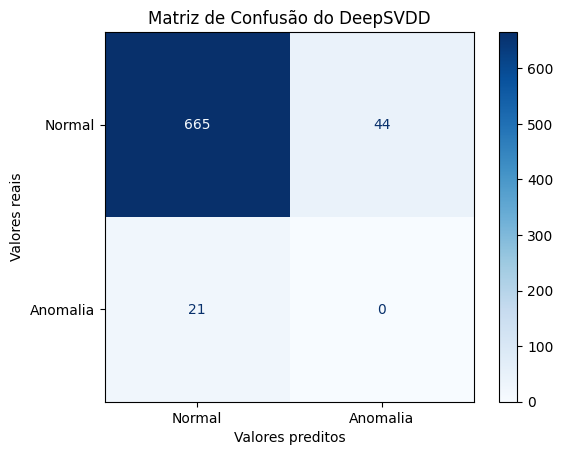

Acurácia=91,10
Precisão=0,00
Recall=0,00
F1=0,00
Falso Negativo=21
Falso Positivo=44
Verdadeiro Positivo=0


In [9]:
# Teste sem Normalização

grid_result = grid.fit(X, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name,Y,clf.decision_scores_,clf.labels_,round(contamination,2))

# Imprime a tabela final de avaliação

In [10]:
tabelafinal.sort_values("fn", axis = 0, ascending = True,
                 inplace = True, na_position ='last')
print(tabelafinal)

                   algoritmo contaminacao acuracia precisao recall     f1  fn  \
2           DeepSVDD Robusta         0,12    90,27    21,59  90,48  34,86   2   
0  DeepSVDD Robusta e minmax          0,1    87,12     0,00   0,00   0,00  21   
1            DeepSVDD minmax         0,07    90,00     0,00   0,00   0,00  21   
3                   DeepSVDD         0,06    91,10     0,00   0,00   0,00  21   

   fp  tp  
2  69  19  
0  73   0  
1  52   0  
3  44   0  
